In [1]:
import json

with open('../data/train.json', 'r') as file:
    train_data = json.load(file)

with open('../data/dev.json', 'r') as file:
    test_data = json.load(file)

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

/home/kshitij/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class Dataset_Reader(Dataset):
    def __init__(self, data):
        self.data = data

        self.texts = []
        self.labels = []
        for idx, document in enumerate(data):
            current_id = document['id']
            # current_meta = document['meta']['group']
            for annotation in document['annotations']:
                for sentence in annotation['result']:
                    text = sentence['value']['text'].lower().replace('\n', '')
                    label = sentence['value']['labels'][0]

                    self.texts.append(text)
                    self.labels.append(label)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'text': self.texts[idx],
            'label': self.labels[idx],
        }

In [4]:
data_train = Dataset_Reader(train_data)
data_test = Dataset_Reader(test_data)

In [5]:
for idx, label in enumerate(data_train.labels):
    if label == 'ARG_RESPONDENT' or label == 'ARG_PETITIONER':
        data_train.labels[idx] = "ARG"
    elif label == 'PRE_NOT_RELIED' or label == 'PRE_RELIED':
        data_train.labels[idx] = 'PRE'
for idx, label in enumerate(data_test.labels):
    if label == 'ARG_RESPONDENT' or label == 'ARG_PETITIONER':
        data_train.labels[idx] = "ARG"
    elif label == 'PRE_NOT_RELIED' or label == 'PRE_RELIED':
        data_train.labels[idx] = 'PRE'

In [6]:
dataset_size = len(data_train)
val_size = int(dataset_size * 0.1)
train_size = dataset_size - val_size
train_set, val_set = torch.utils.data.random_split(data_train, [train_size, val_size])
train_set.augment = True


batch_size = 8
train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_set,batch_size=batch_size)

print(len(train_dataloader))
print(len(val_dataloader))


3261
363


In [7]:
list_of_targets = ['ISSUE', 'FAC', 'NONE', 'ARG_PETITIONER', 'PRE_NOT_RELIED', 'STA', 'RPC', 'ARG_RESPONDENT', 'PREAMBLE', 'ANALYSIS', 'RLC', 'PRE_RELIED', 'RATIO']
label_encoder1 = LabelEncoder().fit(list_of_targets)
list_of_targets = list(set(data_train.labels))
label_encoder = LabelEncoder().fit(list_of_targets)

In [8]:
len(label_encoder1.classes_)

13

In [9]:
len(label_encoder.classes_)

11

In [10]:
def remap_targets(target_tensor: torch.TensorType, old_le, new_le):
    inverse_tensor = old_le.inverse_transform(target_tensor.long())
    for idx, label in enumerate(inverse_tensor):
        if label == 'ARG_RESPONDENT' or label == 'ARG_PETITIONER':
            inverse_tensor[idx] = "ARG"
        elif label == 'PRE_NOT_RELIED' or label == 'PRE_RELIED':
            inverse_tensor[idx] = 'PRE'
    new_tensor = torch.tensor(new_le.transform(inverse_tensor))
    return new_tensor

In [11]:
from tqdm import tqdm
import os, sys

import torch
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))
from utils import load_tensor

/home/kshitij/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
sample_input, sample_target = None, None
for idx in range(246):
    if sample_input is None:
        sample_input = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
        sample_target = load_tensor(filepath=f"../train_document/doc_{idx}/label")
    else:
        sample_input = torch.cat((sample_input,load_tensor(filepath=f"../train_document/doc_{idx}/embedding")), dim=0)
        sample_target = torch.cat((sample_target,load_tensor(filepath=f"../train_document/doc_{idx}/label")), dim=0)

In [13]:
# sample_input, sample_target = None, None
# for idx in range(29):
#     if sample_input is None:
#         sample_input = load_tensor(filepath=f"../test_document/doc_{idx}/embedding")
#         sample_target = load_tensor(filepath=f"../test_document/doc_{idx}/label")
#     else:
#         sample_input = torch.cat((sample_input,load_tensor(filepath=f"../test_document/doc_{idx}/embedding")), dim=0)
#         sample_target = torch.cat((sample_target,load_tensor(filepath=f"../test_document/doc_{idx}/label")), dim=0)

In [14]:
import numpy as np

def uniform_sample(input_tensor, target_tensor, num_classes):
    class_indices = [np.where(target_tensor.numpy() == i)[0] for i in range(num_classes)]
    min_class_samples = min(len(indices) for indices in class_indices)
    print([len(indices) for indices in class_indices]) 
    print(min_class_samples)
    sampled_indices = []
    for indices in class_indices:
        sampled_indices.extend(np.random.choice(indices, min_class_samples, replace=False))
    
    sampled_indices = np.random.permutation(sampled_indices)
    # print(sampled_indices)
    
    return input_tensor[sampled_indices], target_tensor[sampled_indices]

In [15]:
sample_input.size()

torch.Size([28864, 1, 768])

In [16]:
sample_target.size()

torch.Size([28864])

In [17]:
x, y = uniform_sample(sample_input, sample_target, 13)

[10667, 1315, 687, 5724, 367, 1415, 4134, 158, 1419, 673, 749, 1078, 478]
158


In [18]:
label_encoder1.inverse_transform(sample_target.long())

array(['PREAMBLE', 'PREAMBLE', 'PREAMBLE', ..., 'RPC', 'RPC', 'NONE'],
      dtype='<U14')

In [19]:
remapped_target = remap_targets(sample_target, label_encoder1, label_encoder)

In [20]:
x, y = uniform_sample(sample_input, remapped_target,11)

[10667, 2002, 5724, 367, 1415, 1577, 4134, 673, 749, 1078, 478]
367


## Training with new classes


In [21]:
from evaluation import *
from tqdm import tqdm
from itertools import product

In [22]:
def get_accuracy_value(item):
    return item[1][0]

def grid_search(parameters):
    keys = parameters.keys()
    values = parameters.values()
    
    combinations = list(product(*values))
    
    parameter_configurations = [{k: v for k, v in zip(keys, combination)} for combination in combinations]
    
    return parameter_configurations

In [23]:
def calculate_confusion_matrix(test_emb, test_labels, model, num_labels):
    model.eval()
    output = model(test_emb)
    return confusion_matrix(output, test_labels, num_labels)

In [24]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class BiLSTM(nn.Module):
    def __init__(self,
                input_size:int = 768,
                hidden_size:int = 256,
                num_layers:int = 2,
                output_size:int = 13,
                dropout:float = 0.1
                ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.bilstm = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size,
                              num_layers = num_layers,
                              bidirectional=True)
        
        self.dense = nn.Sequential(nn.Dropout(p=dropout),
                                   nn.Linear(hidden_size*2, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, output_size),
                                   nn.Softmax(dim=1))
        
        self.apply(init_weights)
        
    def forward(self, x):
        x = x.permute(1,0,2)
        lstm_out, _ = self.bilstm(x.squeeze(0))

        # Fully connected layers
        out = self.dense(lstm_out)

        return out

In [25]:
def grid_search_train_test(parameters, class_weights = None):
    result = []
    
    parameter_configs = grid_search(parameters)
    for config in parameter_configs:
        loss_list = []
        running_lr = []
        model = BiLSTM(hidden_size=config['hidden_size'], num_layers=config['num_layers'], dropout=config['dropout'], output_size= 11)
        model_opt = torch.optim.Adam(model.parameters(), lr= config['learning_rate'])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model_opt, T_max= config['epochs'], eta_min= config['learning_rate_floor'])
        scheduler1 = torch.optim.lr_scheduler.ConstantLR(model_opt, factor= 0.8, total_iters= config['epochs']*0.4)
        scheduler2 = torch.optim.lr_scheduler.ConstantLR(model_opt, factor= 0.6, total_iters= config['epochs']*0.7)
        loss_function = nn.CrossEntropyLoss(weight= class_weights)
        print("Working with: ")
        print(config)
        print(f'{"Starting Training":-^100}')
        model.train()
        for epoch in tqdm(range(config['epochs'])):
            running_loss = []
            for idx in range(246):
                TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
                TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
                TRAIN_labels = remap_targets(TRAIN_labels, label_encoder1, label_encoder)
                if TRAIN_emb.size(0) == 0:
                    continue
                output = model(TRAIN_emb)
                loss = loss_function(output,TRAIN_labels)
                
                model_opt.zero_grad()
                loss.backward()
                model_opt.step()
                running_loss.append(loss.item())
            scheduler.step()
            scheduler1.step()
            scheduler2.step()
            running_lr.append(model_opt.state_dict()['param_groups'][0]['lr'])
            loss_list.append(np.mean(running_loss))
            print(f"Epoch: {epoch+1} \t Loss: {np.mean(running_loss):.5f} \t LR: {model_opt.state_dict()['param_groups'][0]['lr']}")
        # batch_loss.append(loss.item())
        cm = None
        for i in range(29):
            TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
            TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
            TEST_labels = remap_targets(TEST_labels, label_encoder1, label_encoder)
            conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model, num_labels= 11)
            if cm is None:
                cm = conf_matrix_helper
            else:
                cm = np.add(cm, conf_matrix_helper)
                
        accuracies = class_accuracy(cm)
        f1_scores = class_f1_score(cm)
        average_accuracy = np.mean(accuracies)
        average_f1 = np.mean(f1_scores)

        print("Accuracies: {} \n Average acccuracy: {}".format(accuracies, average_accuracy))
        print("F1 Scores: {} \n Average F1: {}".format(f1_scores, average_f1))
        result.append((config, (average_accuracy, average_f1)))
    return cm, loss_list, result, running_lr, model

In [163]:
parameter_configs = {
    'epochs': [200],
    'learning_rate': [5e-4],
    'learning_rate_floor': [5e-6],
    'dropout': [0.25],
    'hidden_size': [256],
    'num_layers': [1]
    }

cm, loss_list, result, lrs, trained_model = grid_search_train_test(parameter_configs)

max_accuracy_config = max(result, key=get_accuracy_value)

print(max_accuracy_config)

Working with: 
{'epochs': 200, 'learning_rate': 0.0005, 'learning_rate_floor': 5e-06, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}
-----------------------------------------Starting Training------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:25<1:25:03, 25.65s/it]

Epoch: 1 	 Loss: 2.18306 	 LR: 0.00023998550431659512


  1%|          | 2/200 [00:48<1:18:47, 23.88s/it]

Epoch: 2 	 Loss: 2.00981 	 LR: 0.00023994202084297347


  2%|▏         | 3/200 [01:11<1:17:57, 23.75s/it]

Epoch: 3 	 Loss: 1.97913 	 LR: 0.0002398695603080315


  2%|▏         | 4/200 [01:33<1:15:06, 22.99s/it]

Epoch: 4 	 Loss: 1.94971 	 LR: 0.00023976814059032192


  2%|▎         | 5/200 [01:55<1:13:34, 22.64s/it]

Epoch: 5 	 Loss: 1.91760 	 LR: 0.00023963778671364254


  3%|▎         | 6/200 [02:16<1:11:13, 22.03s/it]

Epoch: 6 	 Loss: 1.87074 	 LR: 0.00023947853084086188


  4%|▎         | 7/200 [02:36<1:08:33, 21.31s/it]

Epoch: 7 	 Loss: 1.86182 	 LR: 0.0002392904122659836


  4%|▍         | 8/200 [02:57<1:08:06, 21.28s/it]

Epoch: 8 	 Loss: 1.87135 	 LR: 0.00023907347740445114


  4%|▍         | 9/200 [03:17<1:06:06, 20.77s/it]

Epoch: 9 	 Loss: 1.85861 	 LR: 0.00023882777978169548


  5%|▌         | 10/200 [03:40<1:07:43, 21.39s/it]

Epoch: 10 	 Loss: 1.83350 	 LR: 0.00023855338001992866


  6%|▌         | 11/200 [04:02<1:07:59, 21.58s/it]

Epoch: 11 	 Loss: 1.84279 	 LR: 0.0002382503458231859


  6%|▌         | 12/200 [04:24<1:08:32, 21.88s/it]

Epoch: 12 	 Loss: 1.82971 	 LR: 0.00023791875196062088


  6%|▋         | 13/200 [04:45<1:07:38, 21.70s/it]

Epoch: 13 	 Loss: 1.82034 	 LR: 0.00023755868024805742


  7%|▋         | 14/200 [05:09<1:09:08, 22.30s/it]

Epoch: 14 	 Loss: 1.81798 	 LR: 0.0002371702195278028


  8%|▊         | 15/200 [05:30<1:07:29, 21.89s/it]

Epoch: 15 	 Loss: 1.82761 	 LR: 0.00023675346564672696


  8%|▊         | 16/200 [05:52<1:07:09, 21.90s/it]

Epoch: 16 	 Loss: 1.81922 	 LR: 0.00023630852143261412


  8%|▊         | 17/200 [06:12<1:05:24, 21.45s/it]

Epoch: 17 	 Loss: 1.81666 	 LR: 0.00023583549666879124


  9%|▉         | 18/200 [06:34<1:04:58, 21.42s/it]

Epoch: 18 	 Loss: 1.81142 	 LR: 0.00023533450806704077


 10%|▉         | 19/200 [06:53<1:03:03, 20.90s/it]

Epoch: 19 	 Loss: 1.80665 	 LR: 0.00023480567923880372


 10%|█         | 20/200 [07:17<1:04:54, 21.63s/it]

Epoch: 20 	 Loss: 1.80310 	 LR: 0.0002342491406646805


 10%|█         | 21/200 [07:37<1:03:30, 21.29s/it]

Epoch: 21 	 Loss: 1.80118 	 LR: 0.00023366502966223651


 11%|█         | 22/200 [08:00<1:04:39, 21.80s/it]

Epoch: 22 	 Loss: 1.80149 	 LR: 0.00023305349035212142


 12%|█▏        | 23/200 [08:22<1:03:54, 21.66s/it]

Epoch: 23 	 Loss: 1.79871 	 LR: 0.00023241467362250935


 12%|█▏        | 24/200 [08:44<1:04:08, 21.87s/it]

Epoch: 24 	 Loss: 1.80211 	 LR: 0.00023174873709186946


 12%|█▎        | 25/200 [09:06<1:03:37, 21.81s/it]

Epoch: 25 	 Loss: 1.80387 	 LR: 0.00023105584507007612


 13%|█▎        | 26/200 [09:26<1:01:47, 21.31s/it]

Epoch: 26 	 Loss: 1.79936 	 LR: 0.0002303361685178677


 14%|█▎        | 27/200 [09:48<1:02:35, 21.71s/it]

Epoch: 27 	 Loss: 1.79603 	 LR: 0.00022958988500466473


 14%|█▍        | 28/200 [10:10<1:02:04, 21.66s/it]

Epoch: 28 	 Loss: 1.79292 	 LR: 0.00022881717866475723


 14%|█▍        | 29/200 [10:32<1:02:26, 21.91s/it]

Epoch: 29 	 Loss: 1.79904 	 LR: 0.00022801824015187226


 15%|█▌        | 30/200 [10:54<1:01:32, 21.72s/it]

Epoch: 30 	 Loss: 1.79324 	 LR: 0.00022719326659213315


 16%|█▌        | 31/200 [11:13<59:32, 21.14s/it]  

Epoch: 31 	 Loss: 1.78950 	 LR: 0.00022634246153542144


 16%|█▌        | 32/200 [11:33<57:59, 20.71s/it]

Epoch: 32 	 Loss: 1.78946 	 LR: 0.0002254660349051539


 16%|█▋        | 33/200 [11:55<58:14, 20.93s/it]

Epoch: 33 	 Loss: 1.78590 	 LR: 0.0002245642029464874


 17%|█▋        | 34/200 [12:15<57:38, 20.84s/it]

Epoch: 34 	 Loss: 1.78091 	 LR: 0.00022363718817296332


 18%|█▊        | 35/200 [12:36<57:28, 20.90s/it]

Epoch: 35 	 Loss: 1.77467 	 LR: 0.0002226852193116058


 18%|█▊        | 36/200 [12:57<57:16, 20.95s/it]

Epoch: 36 	 Loss: 1.77604 	 LR: 0.00022170853124648673


 18%|█▊        | 37/200 [13:18<56:25, 20.77s/it]

Epoch: 37 	 Loss: 1.76927 	 LR: 0.00022070736496077173


 19%|█▉        | 38/200 [13:41<58:30, 21.67s/it]

Epoch: 38 	 Loss: 1.76272 	 LR: 0.00021968196747726096


 20%|█▉        | 39/200 [14:02<56:58, 21.23s/it]

Epoch: 39 	 Loss: 1.75716 	 LR: 0.0002186325917974402


 20%|██        | 40/200 [14:23<56:24, 21.15s/it]

Epoch: 40 	 Loss: 1.75471 	 LR: 0.0002175594968390563


 20%|██        | 41/200 [14:43<55:46, 21.05s/it]

Epoch: 41 	 Loss: 1.74936 	 LR: 0.00021646294737223313


 21%|██        | 42/200 [15:04<54:45, 20.80s/it]

Epoch: 42 	 Loss: 1.74995 	 LR: 0.00021534321395414357


 22%|██▏       | 43/200 [15:24<53:53, 20.60s/it]

Epoch: 43 	 Loss: 1.74259 	 LR: 0.00021420057286225373


 22%|██▏       | 44/200 [15:44<53:37, 20.62s/it]

Epoch: 44 	 Loss: 1.73875 	 LR: 0.00021303530602615522


 22%|██▎       | 45/200 [16:06<53:45, 20.81s/it]

Epoch: 45 	 Loss: 1.73852 	 LR: 0.00021184770095800364


 23%|██▎       | 46/200 [16:26<53:21, 20.79s/it]

Epoch: 46 	 Loss: 1.74370 	 LR: 0.000210638050681579


 24%|██▎       | 47/200 [16:47<52:37, 20.63s/it]

Epoch: 47 	 Loss: 1.73888 	 LR: 0.0002094066536599866


 24%|██▍       | 48/200 [17:07<51:55, 20.50s/it]

Epoch: 48 	 Loss: 1.73408 	 LR: 0.00020815381372201583


 24%|██▍       | 49/200 [17:27<51:31, 20.48s/it]

Epoch: 49 	 Loss: 1.73096 	 LR: 0.00020687983998717466


 25%|██▌       | 50/200 [17:47<50:49, 20.33s/it]

Epoch: 50 	 Loss: 1.76112 	 LR: 0.0002055850467894193


 26%|██▌       | 51/200 [18:07<49:50, 20.07s/it]

Epoch: 51 	 Loss: 1.74463 	 LR: 0.0002042697535995969


 26%|██▌       | 52/200 [18:27<49:49, 20.20s/it]

Epoch: 52 	 Loss: 1.73208 	 LR: 0.00020293428494662092


 26%|██▋       | 53/200 [18:48<49:57, 20.39s/it]

Epoch: 53 	 Loss: 1.72804 	 LR: 0.00020157897033739835


 27%|██▋       | 54/200 [19:08<49:00, 20.14s/it]

Epoch: 54 	 Loss: 1.72615 	 LR: 0.00020020414417552907


 28%|██▊       | 55/200 [19:28<48:54, 20.24s/it]

Epoch: 55 	 Loss: 1.72467 	 LR: 0.00019881014567879656


 28%|██▊       | 56/200 [19:50<49:24, 20.59s/it]

Epoch: 56 	 Loss: 1.72469 	 LR: 0.000197397318795471


 28%|██▊       | 57/200 [20:12<50:30, 21.19s/it]

Epoch: 57 	 Loss: 1.72294 	 LR: 0.00019596601211944534


 29%|██▉       | 58/200 [20:33<49:52, 21.08s/it]

Epoch: 58 	 Loss: 1.72451 	 LR: 0.0001945165788042247


 30%|██▉       | 59/200 [20:53<49:07, 20.90s/it]

Epoch: 59 	 Loss: 1.72325 	 LR: 0.00019304937647579134


 30%|███       | 60/200 [21:16<49:43, 21.31s/it]

Epoch: 60 	 Loss: 1.72196 	 LR: 0.00019156476714436558


 30%|███       | 61/200 [21:37<49:05, 21.19s/it]

Epoch: 61 	 Loss: 1.71988 	 LR: 0.0001900631171150852


 31%|███       | 62/200 [21:57<48:29, 21.08s/it]

Epoch: 62 	 Loss: 1.71948 	 LR: 0.00018854479689762535


 32%|███▏      | 63/200 [22:17<47:12, 20.68s/it]

Epoch: 63 	 Loss: 1.71515 	 LR: 0.00018701018111478047


 32%|███▏      | 64/200 [22:37<46:11, 20.38s/it]

Epoch: 64 	 Loss: 1.71394 	 LR: 0.00018545964841003206


 32%|███▎      | 65/200 [22:57<45:31, 20.24s/it]

Epoch: 65 	 Loss: 1.71489 	 LR: 0.00018389358135412396


 33%|███▎      | 66/200 [23:17<45:26, 20.35s/it]

Epoch: 66 	 Loss: 1.71114 	 LR: 0.0001823123663506686


 34%|███▎      | 67/200 [23:39<45:43, 20.63s/it]

Epoch: 67 	 Loss: 1.71202 	 LR: 0.00018071639354080786


 34%|███▍      | 68/200 [23:58<44:37, 20.28s/it]

Epoch: 68 	 Loss: 1.70892 	 LR: 0.0001791060567069515


 34%|███▍      | 69/200 [24:19<44:31, 20.39s/it]

Epoch: 69 	 Loss: 1.71037 	 LR: 0.00017748175317561736


 35%|███▌      | 70/200 [24:40<44:51, 20.71s/it]

Epoch: 70 	 Loss: 1.70797 	 LR: 0.00017584388371939672


 36%|███▌      | 71/200 [25:00<43:58, 20.45s/it]

Epoch: 71 	 Loss: 1.70562 	 LR: 0.00017419285245807


 36%|███▌      | 72/200 [25:21<44:06, 20.68s/it]

Epoch: 72 	 Loss: 1.70750 	 LR: 0.00017252906675889603


 36%|███▋      | 73/200 [25:42<43:54, 20.75s/it]

Epoch: 73 	 Loss: 1.70643 	 LR: 0.00017085293713610028


 37%|███▋      | 74/200 [26:02<42:54, 20.43s/it]

Epoch: 74 	 Loss: 1.70387 	 LR: 0.0001691648771495867


 38%|███▊      | 75/200 [26:28<45:58, 22.06s/it]

Epoch: 75 	 Loss: 1.70410 	 LR: 0.00016746530330289807


 38%|███▊      | 76/200 [26:50<45:42, 22.12s/it]

Epoch: 76 	 Loss: 1.70388 	 LR: 0.0001657546349404497


 38%|███▊      | 77/200 [27:18<49:05, 23.95s/it]

Epoch: 77 	 Loss: 1.69856 	 LR: 0.00016403329414406274


 39%|███▉      | 78/200 [27:41<48:06, 23.66s/it]

Epoch: 78 	 Loss: 1.69443 	 LR: 0.0001623017056288218


 40%|███▉      | 79/200 [28:01<45:39, 22.64s/it]

Epoch: 79 	 Loss: 1.69473 	 LR: 0.0001605602966382826


 40%|████      | 80/200 [28:22<44:02, 22.02s/it]

Epoch: 80 	 Loss: 1.69248 	 LR: 0.00019851187104882043


 40%|████      | 81/200 [28:44<43:24, 21.88s/it]

Epoch: 81 	 Loss: 1.69273 	 LR: 0.0001962978713220591


 41%|████      | 82/200 [29:06<43:20, 22.04s/it]

Epoch: 82 	 Loss: 1.68969 	 LR: 0.00019407314652750726


 42%|████▏     | 83/200 [29:30<43:51, 22.49s/it]

Epoch: 83 	 Loss: 1.68927 	 LR: 0.0001918382455827186


 42%|████▏     | 84/200 [29:52<43:18, 22.40s/it]

Epoch: 84 	 Loss: 1.68822 	 LR: 0.00018959371991605982


 42%|████▎     | 85/200 [30:12<41:47, 21.80s/it]

Epoch: 85 	 Loss: 1.68474 	 LR: 0.0001873401233306536


 43%|████▎     | 86/200 [30:33<40:37, 21.38s/it]

Epoch: 86 	 Loss: 1.68369 	 LR: 0.00018507801186773605


 44%|████▎     | 87/200 [30:53<39:47, 21.13s/it]

Epoch: 87 	 Loss: 1.68089 	 LR: 0.00018280794366946194


 44%|████▍     | 88/200 [31:14<39:11, 21.00s/it]

Epoch: 88 	 Loss: 1.68049 	 LR: 0.00018053047884119145


 44%|████▍     | 89/200 [31:31<36:46, 19.87s/it]

Epoch: 89 	 Loss: 1.67726 	 LR: 0.00017824617931329245


 45%|████▌     | 90/200 [31:44<32:39, 17.81s/it]

Epoch: 90 	 Loss: 1.67346 	 LR: 0.0001759556087024929


 46%|████▌     | 91/200 [31:56<29:09, 16.05s/it]

Epoch: 91 	 Loss: 1.67379 	 LR: 0.00017365933217281635


 46%|████▌     | 92/200 [32:08<26:53, 14.94s/it]

Epoch: 92 	 Loss: 1.67346 	 LR: 0.00017135791629613661


 46%|████▋     | 93/200 [32:21<25:09, 14.11s/it]

Epoch: 93 	 Loss: 1.67091 	 LR: 0.0001690519289123844


 47%|████▋     | 94/200 [32:33<23:54, 13.54s/it]

Epoch: 94 	 Loss: 1.66882 	 LR: 0.00016674193898944147


 48%|████▊     | 95/200 [32:53<27:17, 15.59s/it]

Epoch: 95 	 Loss: 1.66667 	 LR: 0.00016442851648275619


 48%|████▊     | 96/200 [33:14<29:42, 17.14s/it]

Epoch: 96 	 Loss: 1.66524 	 LR: 0.00016211223219471556


 48%|████▊     | 97/200 [33:36<32:00, 18.64s/it]

Epoch: 97 	 Loss: 1.66460 	 LR: 0.00015979365763380834


 49%|████▉     | 98/200 [33:57<32:47, 19.29s/it]

Epoch: 98 	 Loss: 1.66496 	 LR: 0.00015747336487361392


 50%|████▉     | 99/200 [34:19<33:49, 20.10s/it]

Epoch: 99 	 Loss: 1.66293 	 LR: 0.00015515192641165157


 50%|█████     | 100/200 [34:39<33:48, 20.29s/it]

Epoch: 100 	 Loss: 1.66103 	 LR: 0.00015282991502812532


 50%|█████     | 101/200 [35:00<33:47, 20.48s/it]

Epoch: 101 	 Loss: 1.66021 	 LR: 0.0001505079036445991


 51%|█████     | 102/200 [35:22<33:49, 20.71s/it]

Epoch: 102 	 Loss: 1.66061 	 LR: 0.00014818646518263668


 52%|█████▏    | 103/200 [35:45<34:36, 21.41s/it]

Epoch: 103 	 Loss: 1.65976 	 LR: 0.00014586617242244227


 52%|█████▏    | 104/200 [36:06<34:17, 21.44s/it]

Epoch: 104 	 Loss: 1.65873 	 LR: 0.00014354759786153507


 52%|█████▎    | 105/200 [36:34<36:44, 23.20s/it]

Epoch: 105 	 Loss: 1.65800 	 LR: 0.00014123131357349447


 53%|█████▎    | 106/200 [36:56<36:09, 23.08s/it]

Epoch: 106 	 Loss: 1.65686 	 LR: 0.00013891789106680916


 54%|█████▎    | 107/200 [37:19<35:27, 22.88s/it]

Epoch: 107 	 Loss: 1.65610 	 LR: 0.00013660790114386625


 54%|█████▍    | 108/200 [37:39<34:03, 22.22s/it]

Epoch: 108 	 Loss: 1.65678 	 LR: 0.00013430191376011407


 55%|█████▍    | 109/200 [38:00<33:06, 21.83s/it]

Epoch: 109 	 Loss: 1.65566 	 LR: 0.00013200049788343436


 55%|█████▌    | 110/200 [38:21<32:20, 21.57s/it]

Epoch: 110 	 Loss: 1.65591 	 LR: 0.0001297042213537578


 56%|█████▌    | 111/200 [38:42<31:38, 21.33s/it]

Epoch: 111 	 Loss: 1.65549 	 LR: 0.0001274136507429582


 56%|█████▌    | 112/200 [39:02<30:50, 21.03s/it]

Epoch: 112 	 Loss: 1.65541 	 LR: 0.0001251293512150593


 56%|█████▋    | 113/200 [39:25<31:20, 21.62s/it]

Epoch: 113 	 Loss: 1.65425 	 LR: 0.0001228518863867888


 57%|█████▋    | 114/200 [39:45<30:07, 21.02s/it]

Epoch: 114 	 Loss: 1.65430 	 LR: 0.0001205818181885147


 57%|█████▊    | 115/200 [40:07<30:01, 21.19s/it]

Epoch: 115 	 Loss: 1.65329 	 LR: 0.00011831970672559706


 58%|█████▊    | 116/200 [40:28<29:34, 21.13s/it]

Epoch: 116 	 Loss: 1.65249 	 LR: 0.0001160661101401908


 58%|█████▊    | 117/200 [40:42<26:19, 19.03s/it]

Epoch: 117 	 Loss: 1.65218 	 LR: 0.00011382158447353203


 59%|█████▉    | 118/200 [40:54<23:22, 17.11s/it]

Epoch: 118 	 Loss: 1.65138 	 LR: 0.00011158668352874341


 60%|█████▉    | 119/200 [41:06<21:04, 15.62s/it]

Epoch: 119 	 Loss: 1.65110 	 LR: 0.00010936195873419155


 60%|██████    | 120/200 [41:19<19:28, 14.60s/it]

Epoch: 120 	 Loss: 1.65077 	 LR: 0.00010714795900743025


 60%|██████    | 121/200 [41:31<18:12, 13.83s/it]

Epoch: 121 	 Loss: 1.65039 	 LR: 0.0001049452306197632


 61%|██████    | 122/200 [41:43<17:15, 13.28s/it]

Epoch: 122 	 Loss: 1.65116 	 LR: 0.00010275431706146005


 62%|██████▏   | 123/200 [42:01<19:03, 14.85s/it]

Epoch: 123 	 Loss: 1.64951 	 LR: 0.00010057575890765793


 62%|██████▏   | 124/200 [42:22<21:07, 16.68s/it]

Epoch: 124 	 Loss: 1.64941 	 LR: 9.84100936849828e-05


 62%|██████▎   | 125/200 [42:43<22:19, 17.87s/it]

Epoch: 125 	 Loss: 1.64954 	 LR: 9.625785573892282e-05


 63%|██████▎   | 126/200 [43:04<23:20, 18.93s/it]

Epoch: 126 	 Loss: 1.64902 	 LR: 9.411957610198651e-05


 64%|██████▎   | 127/200 [43:22<22:45, 18.70s/it]

Epoch: 127 	 Loss: 1.64878 	 LR: 9.199578236267863e-05


 64%|██████▍   | 128/200 [43:44<23:29, 19.57s/it]

Epoch: 128 	 Loss: 1.64838 	 LR: 8.988699853532527e-05


 64%|██████▍   | 129/200 [44:12<26:05, 22.05s/it]

Epoch: 129 	 Loss: 1.64854 	 LR: 8.779374493078141e-05


 65%|██████▌   | 130/200 [44:35<26:00, 22.29s/it]

Epoch: 130 	 Loss: 1.64817 	 LR: 8.5716538028052e-05


 66%|██████▌   | 131/200 [44:57<25:33, 22.22s/it]

Epoch: 131 	 Loss: 1.64746 	 LR: 8.365589034685834e-05


 66%|██████▌   | 132/200 [45:19<25:04, 22.12s/it]

Epoch: 132 	 Loss: 1.64715 	 LR: 8.161231032118157e-05


 66%|██████▋   | 133/200 [45:41<24:48, 22.21s/it]

Epoch: 133 	 Loss: 1.64749 	 LR: 7.95863021738144e-05


 67%|██████▋   | 134/200 [46:04<24:37, 22.39s/it]

Epoch: 134 	 Loss: 1.64723 	 LR: 7.757836579195133e-05


 68%|██████▊   | 135/200 [46:25<23:46, 21.94s/it]

Epoch: 135 	 Loss: 1.64695 	 LR: 7.558899660384918e-05


 68%|██████▊   | 136/200 [46:45<22:53, 21.46s/it]

Epoch: 136 	 Loss: 1.64588 	 LR: 7.361868545658749e-05


 68%|██████▊   | 137/200 [47:05<22:10, 21.13s/it]

Epoch: 137 	 Loss: 1.64589 	 LR: 7.166791849495958e-05


 69%|██████▉   | 138/200 [47:29<22:32, 21.81s/it]

Epoch: 138 	 Loss: 1.64593 	 LR: 6.973717704152319e-05


 70%|██████▉   | 139/200 [48:01<25:20, 24.92s/it]

Epoch: 139 	 Loss: 1.64545 	 LR: 6.782693747784168e-05


 70%|███████   | 140/200 [48:40<29:13, 29.22s/it]

Epoch: 140 	 Loss: 1.64527 	 LR: 0.00010989611854490641


 70%|███████   | 141/200 [49:16<30:37, 31.14s/it]

Epoch: 141 	 Loss: 1.64618 	 LR: 0.00010668090211586023


 71%|███████   | 142/200 [49:47<30:04, 31.11s/it]

Epoch: 142 	 Loss: 1.64673 	 LR: 0.00010350338400974446


 72%|███████▏  | 143/200 [50:10<27:17, 28.74s/it]

Epoch: 143 	 Loss: 1.64715 	 LR: 0.0001003643482316057


 72%|███████▏  | 144/200 [50:32<24:57, 26.75s/it]

Epoch: 144 	 Loss: 1.64512 	 LR: 9.726456929155172e-05


 72%|███████▎  | 145/200 [50:53<23:00, 25.09s/it]

Epoch: 145 	 Loss: 1.64441 	 LR: 9.420481201365305e-05


 73%|███████▎  | 146/200 [51:14<21:19, 23.69s/it]

Epoch: 146 	 Loss: 1.64339 	 LR: 9.11858313472338e-05


 74%|███████▎  | 147/200 [51:36<20:29, 23.20s/it]

Epoch: 147 	 Loss: 1.64328 	 LR: 8.820837218059939e-05


 74%|███████▍  | 148/200 [51:52<18:20, 21.16s/it]

Epoch: 148 	 Loss: 1.64268 	 LR: 8.527316915724665e-05


 74%|███████▍  | 149/200 [52:07<16:15, 19.13s/it]

Epoch: 149 	 Loss: 1.64233 	 LR: 8.238094649460115e-05


 75%|███████▌  | 150/200 [52:24<15:35, 18.71s/it]

Epoch: 150 	 Loss: 1.64261 	 LR: 7.953241780532763e-05


 76%|███████▌  | 151/200 [52:38<13:56, 17.07s/it]

Epoch: 151 	 Loss: 1.64192 	 LR: 7.672828592125672e-05


 76%|███████▌  | 152/200 [52:52<12:55, 16.15s/it]

Epoch: 152 	 Loss: 1.64096 	 LR: 7.39692427199717e-05


 76%|███████▋  | 153/200 [53:05<12:00, 15.33s/it]

Epoch: 153 	 Loss: 1.64090 	 LR: 7.125596895409793e-05


 77%|███████▋  | 154/200 [53:21<11:50, 15.44s/it]

Epoch: 154 	 Loss: 1.64109 	 LR: 6.858913408333773e-05


 78%|███████▊  | 155/200 [53:34<11:03, 14.75s/it]

Epoch: 155 	 Loss: 1.64046 	 LR: 6.596939610929068e-05


 78%|███████▊  | 156/200 [53:46<10:18, 14.06s/it]

Epoch: 156 	 Loss: 1.64027 	 LR: 6.339740141310188e-05


 78%|███████▊  | 157/200 [53:59<09:41, 13.52s/it]

Epoch: 157 	 Loss: 1.63988 	 LR: 6.0873784595977047e-05


 79%|███████▉  | 158/200 [54:12<09:20, 13.34s/it]

Epoch: 158 	 Loss: 1.63999 	 LR: 5.839916832260404e-05


 80%|███████▉  | 159/200 [54:24<08:54, 13.03s/it]

Epoch: 159 	 Loss: 1.63969 	 LR: 5.597416316751996e-05


 80%|████████  | 160/200 [54:37<08:46, 13.17s/it]

Epoch: 160 	 Loss: 1.63944 	 LR: 5.359936746446066e-05


 80%|████████  | 161/200 [54:50<08:22, 12.90s/it]

Epoch: 161 	 Loss: 1.63956 	 LR: 5.1275367158731e-05


 81%|████████  | 162/200 [55:02<08:07, 12.82s/it]

Epoch: 162 	 Loss: 1.63947 	 LR: 4.900273566263166e-05


 82%|████████▏ | 163/200 [55:15<07:48, 12.67s/it]

Epoch: 163 	 Loss: 1.63928 	 LR: 4.6782033713978224e-05


 82%|████████▏ | 164/200 [55:27<07:38, 12.72s/it]

Epoch: 164 	 Loss: 1.63887 	 LR: 4.4613809237747404e-05


 82%|████████▎ | 165/200 [55:42<07:39, 13.14s/it]

Epoch: 165 	 Loss: 1.63899 	 LR: 4.24985972108849e-05


 83%|████████▎ | 166/200 [55:54<07:20, 12.96s/it]

Epoch: 166 	 Loss: 1.63901 	 LR: 4.0436919530307614e-05


 84%|████████▎ | 167/200 [56:06<07:00, 12.75s/it]

Epoch: 167 	 Loss: 1.63880 	 LR: 3.8429284884133916e-05


 84%|████████▍ | 168/200 [56:19<06:51, 12.85s/it]

Epoch: 168 	 Loss: 1.63861 	 LR: 3.647618862617176e-05


 84%|████████▍ | 169/200 [56:32<06:33, 12.68s/it]

Epoch: 169 	 Loss: 1.63867 	 LR: 3.4578112653697955e-05


 85%|████████▌ | 170/200 [56:44<06:18, 12.62s/it]

Epoch: 170 	 Loss: 1.63866 	 LR: 3.273552528855726e-05


 86%|████████▌ | 171/200 [56:57<06:03, 12.53s/it]

Epoch: 171 	 Loss: 1.63859 	 LR: 3.094888116161072e-05


 86%|████████▌ | 172/200 [57:09<05:50, 12.50s/it]

Epoch: 172 	 Loss: 1.63855 	 LR: 2.921862110056258e-05


 86%|████████▋ | 173/200 [57:23<05:45, 12.81s/it]

Epoch: 173 	 Loss: 1.63833 	 LR: 2.7545172021192434e-05


 87%|████████▋ | 174/200 [57:36<05:38, 13.03s/it]

Epoch: 174 	 Loss: 1.63831 	 LR: 2.5928946822020285e-05


 88%|████████▊ | 175/200 [57:48<05:21, 12.84s/it]

Epoch: 175 	 Loss: 1.63783 	 LR: 2.4370344282429916e-05


 88%|████████▊ | 176/200 [58:01<05:05, 12.73s/it]

Epoch: 176 	 Loss: 1.63784 	 LR: 2.2869748964276056e-05


 88%|████████▊ | 177/200 [58:14<04:55, 12.84s/it]

Epoch: 177 	 Loss: 1.63756 	 LR: 2.1427531116999644e-05


 89%|████████▉ | 178/200 [58:28<04:48, 13.10s/it]

Epoch: 178 	 Loss: 1.63750 	 LR: 2.0044046586274148e-05


 90%|████████▉ | 179/200 [58:40<04:31, 12.94s/it]

Epoch: 179 	 Loss: 1.63747 	 LR: 1.871963672620594e-05


 90%|█████████ | 180/200 [58:53<04:18, 12.91s/it]

Epoch: 180 	 Loss: 1.63735 	 LR: 1.7454628315110443e-05


 90%|█████████ | 181/200 [59:06<04:05, 12.92s/it]

Epoch: 181 	 Loss: 1.63737 	 LR: 1.624933347488435e-05


 91%|█████████ | 182/200 [59:19<03:50, 12.78s/it]

Epoch: 182 	 Loss: 1.63748 	 LR: 1.5104049593994323e-05


 92%|█████████▏| 183/200 [59:32<03:38, 12.84s/it]

Epoch: 183 	 Loss: 1.63732 	 LR: 1.4019059254100659e-05


 92%|█████████▏| 184/200 [59:44<03:25, 12.81s/it]

Epoch: 184 	 Loss: 1.63723 	 LR: 1.2994630160334698e-05


 92%|█████████▎| 185/200 [59:57<03:12, 12.83s/it]

Epoch: 185 	 Loss: 1.63707 	 LR: 1.2031015075246426e-05


 93%|█████████▎| 186/200 [1:00:10<02:59, 12.82s/it]

Epoch: 186 	 Loss: 1.63717 	 LR: 1.1128451756439273e-05


 94%|█████████▎| 187/200 [1:00:22<02:45, 12.73s/it]

Epoch: 187 	 Loss: 1.63710 	 LR: 1.0287162897906733e-05


 94%|█████████▍| 188/200 [1:00:35<02:31, 12.64s/it]

Epoch: 188 	 Loss: 1.63722 	 LR: 9.507356075086268e-06


 94%|█████████▍| 189/200 [1:00:51<02:31, 13.80s/it]

Epoch: 189 	 Loss: 1.63711 	 LR: 8.789223693642872e-06


 95%|█████████▌| 190/200 [1:01:04<02:13, 13.34s/it]

Epoch: 190 	 Loss: 1.63707 	 LR: 8.132942941995989e-06


 96%|█████████▌| 191/200 [1:01:16<01:58, 13.14s/it]

Epoch: 191 	 Loss: 1.63709 	 LR: 7.5386757476009535e-06


 96%|█████████▌| 192/200 [1:01:29<01:42, 12.86s/it]

Epoch: 192 	 Loss: 1.63717 	 LR: 7.006568736995804e-06


 96%|█████████▋| 193/200 [1:01:42<01:30, 12.93s/it]

Epoch: 193 	 Loss: 1.63701 	 LR: 6.536753199623298e-06


 97%|█████████▋| 194/200 [1:01:54<01:17, 12.85s/it]

Epoch: 194 	 Loss: 1.63710 	 LR: 6.1293450554372574e-06


 98%|█████████▊| 195/200 [1:02:07<01:03, 12.77s/it]

Epoch: 195 	 Loss: 1.63698 	 LR: 5.784444826301127e-06


 98%|█████████▊| 196/200 [1:02:19<00:50, 12.64s/it]

Epoch: 196 	 Loss: 1.63695 	 LR: 5.502137611185572e-06


 98%|█████████▊| 197/200 [1:02:32<00:38, 12.74s/it]

Epoch: 197 	 Loss: 1.63697 	 LR: 5.28249306517169e-06


 99%|█████████▉| 198/200 [1:02:45<00:25, 12.65s/it]

Epoch: 198 	 Loss: 1.63690 	 LR: 5.125565382264533e-06


100%|█████████▉| 199/200 [1:02:57<00:12, 12.63s/it]

Epoch: 199 	 Loss: 1.63689 	 LR: 5.031393282021787e-06


100%|██████████| 200/200 [1:03:10<00:00, 18.95s/it]

Epoch: 200 	 Loss: 1.63702 	 LR: 5e-06


Accuracies: [0.72851064 0.44444444 0.78627145 0.77272727 0.95906433 0.
 0.99204771 0.50746269 0.29411765 0.79569892 0.        ] 
 Average acccuracy: 0.5709404641716245
F1 Scores: [0.79627902 0.33532929 0.82622946 0.7234042  0.90858721 0.
 0.99106251 0.48920858 0.27522931 0.81767951 0.        ] 
 Average F1: 0.5602735538821085
({'epochs': 200, 'learning_rate': 0.0005, 'learning_rate_floor': 5e-06, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}, (0.5709404641716245, 0.5602735538821085))


In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn')
fig, ax = plt.subplots(1,2, figsize = (14,7))
sns.lineplot(ax= ax[0], x= range(len(loss_list)), y= loss_list)
sns.lineplot(ax= ax[1], x= range(len(lrs)), y= lrs)

In [42]:
def plot_confusion_matrix(conf_matrix, label_encoder, vmax = None):
    # labels = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
    plt.figure(figsize=(7,7))
    plt.imshow(conf_matrix, cmap='copper', interpolation='nearest',vmax = vmax)
    plt.colorbar()
    # plt.xticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    # plt.yticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    plt.xticks(np.arange(11),[label_encoder.classes_[i] for i in range(len(label_encoder.classes_))],rotation=90)
    plt.yticks(np.arange(11),[label_encoder.classes_[i] for i in range(len(label_encoder.classes_))])
    
    plt.xlabel('Predicted label',fontdict={"fontweight":"bold"})
    plt.ylabel('True label',fontdict={"fontweight":"bold"})
    plt.title('Confusion Matrix',fontdict={"fontsize":15,"fontweight":"bold"})
    plt.grid(visible= False)
    plt.tight_layout()

/tmp/ipykernel_15618/3990516058.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


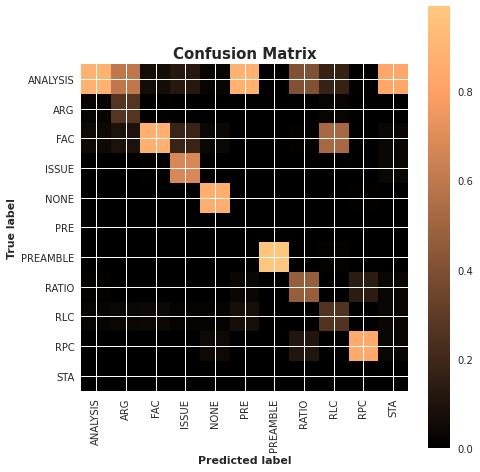

In [197]:
plot_confusion_matrix(np.divide(cm, np.sum(cm,axis=0)))

# Training with class weights (13 classes)

In [30]:
from utils import get_class_weights

In [29]:
sample_target = sample_target.long()

In [54]:
class_weights = get_class_weights(sample_target.numpy())
class_weights

tensor([ 0.2081,  1.6884,  3.2319,  0.3879,  6.0499,  1.5691,  0.5371, 14.0526,
         1.5647,  3.2991,  2.9644,  2.0597,  4.6450])

In [44]:
parameter_configs = {
    'epochs': [150],
    'learning_rate': [5e-4],
    'learning_rate_floor': [5e-5],
    'dropout': [0.25],
    'hidden_size': [256],
    'num_layers': [1]
    }

cm, loss_list, result, lrs, trained_model = grid_search_train_test(parameter_configs, class_weights= class_weights)

max_accuracy_config = max(result, key=get_accuracy_value)

print(max_accuracy_config)

Working with: 
{'epochs': 150, 'learning_rate': 0.0005, 'learning_rate_floor': 5e-05, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}
-----------------------------------------Starting Training------------------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

  1%|          | 1/150 [00:13<33:36, 13.54s/it]

Epoch: 1 	 Loss: 2.32644 	 LR: 0.00023997916493011034


  1%|▏         | 2/150 [00:29<36:44, 14.89s/it]

Epoch: 2 	 Loss: 2.12343 	 LR: 0.00023991666885939158


  2%|▏         | 3/150 [00:48<40:45, 16.63s/it]

Epoch: 3 	 Loss: 2.08154 	 LR: 0.00023981253920068584


  3%|▎         | 4/150 [01:09<45:18, 18.62s/it]

Epoch: 4 	 Loss: 2.05463 	 LR: 0.00023966682162870296


  3%|▎         | 5/150 [01:21<39:12, 16.22s/it]

Epoch: 5 	 Loss: 2.03969 	 LR: 0.000239479580059986


  4%|▍         | 6/150 [01:33<35:21, 14.73s/it]

Epoch: 6 	 Loss: 2.02568 	 LR: 0.00023925089662487546


  5%|▍         | 7/150 [01:45<32:42, 13.72s/it]

Epoch: 7 	 Loss: 2.01631 	 LR: 0.00023898087163148394


  5%|▌         | 8/150 [02:01<34:45, 14.68s/it]

Epoch: 8 	 Loss: 1.99696 	 LR: 0.000238669623521698


  6%|▌         | 9/150 [02:19<36:40, 15.60s/it]

Epoch: 9 	 Loss: 1.99393 	 LR: 0.00023831728881922547


  7%|▋         | 10/150 [02:31<33:52, 14.52s/it]

Epoch: 10 	 Loss: 1.97543 	 LR: 0.00023792402206971157


  7%|▋         | 11/150 [02:43<31:59, 13.81s/it]

Epoch: 11 	 Loss: 1.96861 	 LR: 0.00023748999577295025


  8%|▊         | 12/150 [02:55<30:33, 13.29s/it]

Epoch: 12 	 Loss: 1.95587 	 LR: 0.00023701540030722


  9%|▊         | 13/150 [03:07<29:24, 12.88s/it]

Epoch: 13 	 Loss: 1.94546 	 LR: 0.00023650044384577757


  9%|▉         | 14/150 [03:20<29:13, 12.89s/it]

Epoch: 14 	 Loss: 1.93856 	 LR: 0.00023594535226554642


 10%|█         | 15/150 [03:33<29:08, 12.96s/it]

Epoch: 15 	 Loss: 1.92113 	 LR: 0.00023535036904803966


 11%|█         | 16/150 [03:50<31:11, 13.96s/it]

Epoch: 16 	 Loss: 1.91207 	 LR: 0.00023471575517256077


 11%|█▏        | 17/150 [04:02<30:01, 13.55s/it]

Epoch: 17 	 Loss: 1.89754 	 LR: 0.00023404178900172977


 12%|█▏        | 18/150 [04:15<29:05, 13.23s/it]

Epoch: 18 	 Loss: 1.88550 	 LR: 0.00023332876615938394


 13%|█▎        | 19/150 [04:27<28:23, 13.00s/it]

Epoch: 19 	 Loss: 1.87232 	 LR: 0.00023257699940090762


 13%|█▎        | 20/150 [04:39<27:32, 12.71s/it]

Epoch: 20 	 Loss: 1.86647 	 LR: 0.00023178681847604713


 14%|█▍        | 21/150 [04:51<26:32, 12.35s/it]

Epoch: 21 	 Loss: 1.86143 	 LR: 0.0002309585699842719


 15%|█▍        | 22/150 [05:03<26:13, 12.30s/it]

Epoch: 22 	 Loss: 1.85923 	 LR: 0.00023009261722274426


 15%|█▌        | 23/150 [05:16<26:35, 12.57s/it]

Epoch: 23 	 Loss: 1.86099 	 LR: 0.0002291893400269654


 16%|█▌        | 24/150 [05:28<26:03, 12.41s/it]

Epoch: 24 	 Loss: 1.84883 	 LR: 0.00022824913460416706


 17%|█▋        | 25/150 [05:44<27:43, 13.31s/it]

Epoch: 25 	 Loss: 1.84830 	 LR: 0.0002272724133595217


 17%|█▋        | 26/150 [05:56<26:41, 12.92s/it]

Epoch: 26 	 Loss: 1.83809 	 LR: 0.00022625960471524818


 18%|█▊        | 27/150 [06:07<25:38, 12.51s/it]

Epoch: 27 	 Loss: 1.83077 	 LR: 0.00022521115292269147


 19%|█▊        | 28/150 [06:22<26:46, 13.17s/it]

Epoch: 28 	 Loss: 1.83446 	 LR: 0.0002241275178674595


 19%|█▉        | 29/150 [06:34<25:55, 12.85s/it]

Epoch: 29 	 Loss: 1.82841 	 LR: 0.00022300917486770192


 20%|██        | 30/150 [06:46<25:05, 12.55s/it]

Epoch: 30 	 Loss: 1.81919 	 LR: 0.00022185661446562005


 21%|██        | 31/150 [06:58<24:31, 12.36s/it]

Epoch: 31 	 Loss: 1.81787 	 LR: 0.0002206703422122987


 21%|██▏       | 32/150 [07:09<23:51, 12.13s/it]

Epoch: 32 	 Loss: 1.81832 	 LR: 0.00021945087844595483


 22%|██▏       | 33/150 [07:21<23:26, 12.02s/it]

Epoch: 33 	 Loss: 1.81593 	 LR: 0.00021819875806370004


 23%|██▎       | 34/150 [07:34<23:56, 12.39s/it]

Epoch: 34 	 Loss: 1.82314 	 LR: 0.00021691453028691693


 23%|██▎       | 35/150 [07:46<23:35, 12.31s/it]

Epoch: 35 	 Loss: 1.81952 	 LR: 0.00021559875842035254


 24%|██▍       | 36/150 [08:00<24:06, 12.69s/it]

Epoch: 36 	 Loss: 1.81047 	 LR: 0.00021425201960503416


 25%|██▍       | 37/150 [08:15<25:00, 13.28s/it]

Epoch: 37 	 Loss: 1.81765 	 LR: 0.00021287490456511638


 25%|██▌       | 38/150 [08:27<24:03, 12.89s/it]

Epoch: 38 	 Loss: 1.80711 	 LR: 0.0002114680173487698


 26%|██▌       | 39/150 [08:39<23:21, 12.63s/it]

Epoch: 39 	 Loss: 1.80104 	 LR: 0.0002100319750632255


 27%|██▋       | 40/150 [08:51<22:52, 12.48s/it]

Epoch: 40 	 Loss: 1.79979 	 LR: 0.00020856740760409162


 27%|██▋       | 41/150 [09:03<22:35, 12.43s/it]

Epoch: 41 	 Loss: 1.79845 	 LR: 0.0002070749573790601


 28%|██▊       | 42/150 [09:15<21:55, 12.18s/it]

Epoch: 42 	 Loss: 1.79528 	 LR: 0.00020555527902612562


 29%|██▊       | 43/150 [09:27<21:42, 12.18s/it]

Epoch: 43 	 Loss: 1.79561 	 LR: 0.0002040090391264396


 29%|██▉       | 44/150 [09:39<21:25, 12.13s/it]

Epoch: 44 	 Loss: 1.79306 	 LR: 0.00020243691591192571


 30%|███       | 45/150 [09:51<21:03, 12.03s/it]

Epoch: 45 	 Loss: 1.79181 	 LR: 0.00020083959896778503


 31%|███       | 46/150 [10:02<20:34, 11.87s/it]

Epoch: 46 	 Loss: 1.79522 	 LR: 0.00019921778893002112


 31%|███▏      | 47/150 [10:14<20:29, 11.94s/it]

Epoch: 47 	 Loss: 1.79171 	 LR: 0.00019757219717811777


 32%|███▏      | 48/150 [10:26<20:12, 11.88s/it]

Epoch: 48 	 Loss: 1.78758 	 LR: 0.00019590354552300476


 33%|███▎      | 49/150 [10:41<21:30, 12.78s/it]

Epoch: 49 	 Loss: 1.79344 	 LR: 0.00019421256589044746


 33%|███▎      | 50/150 [10:55<21:44, 13.05s/it]

Epoch: 50 	 Loss: 1.80371 	 LR: 0.00019250000000000007


 34%|███▍      | 51/150 [11:06<20:47, 12.60s/it]

Epoch: 51 	 Loss: 1.78248 	 LR: 0.00019076659903966302


 35%|███▍      | 52/150 [11:18<20:25, 12.50s/it]

Epoch: 52 	 Loss: 1.77382 	 LR: 0.00018901312333638695


 35%|███▌      | 53/150 [11:30<19:47, 12.24s/it]

Epoch: 53 	 Loss: 1.76940 	 LR: 0.00018724034202256817


 36%|███▌      | 54/150 [11:44<20:11, 12.62s/it]

Epoch: 54 	 Loss: 1.76771 	 LR: 0.00018544903269868197


 37%|███▋      | 55/150 [11:55<19:37, 12.39s/it]

Epoch: 55 	 Loss: 1.76084 	 LR: 0.00018363998109220109


 37%|███▋      | 56/150 [12:07<19:05, 12.19s/it]

Epoch: 56 	 Loss: 1.76311 	 LR: 0.00018181398071294986


 38%|███▊      | 57/150 [12:21<19:28, 12.56s/it]

Epoch: 57 	 Loss: 1.75708 	 LR: 0.0001799718325050445


 39%|███▊      | 58/150 [12:32<18:48, 12.26s/it]

Epoch: 58 	 Loss: 1.75704 	 LR: 0.0001781143444955725


 39%|███▉      | 59/150 [12:44<18:16, 12.05s/it]

Epoch: 59 	 Loss: 1.75112 	 LR: 0.00017624233144016544


 40%|████      | 60/150 [12:56<18:12, 12.14s/it]

Epoch: 60 	 Loss: 1.74991 	 LR: 0.00021794576808202508


 41%|████      | 61/150 [13:08<17:59, 12.13s/it]

Epoch: 61 	 Loss: 1.75128 	 LR: 0.00021538168423349194


 41%|████▏     | 62/150 [13:20<17:43, 12.08s/it]

Epoch: 62 	 Loss: 1.75020 	 LR: 0.00021280133475997816


 42%|████▏     | 63/150 [13:32<17:24, 12.00s/it]

Epoch: 63 	 Loss: 1.75186 	 LR: 0.00021020585148804412


 43%|████▎     | 64/150 [13:44<17:02, 11.89s/it]

Epoch: 64 	 Loss: 1.76000 	 LR: 0.0002075963728824345


 43%|████▎     | 65/150 [13:56<17:09, 12.12s/it]

Epoch: 65 	 Loss: 1.75237 	 LR: 0.00020497404354670972


 44%|████▍     | 66/150 [14:08<16:50, 12.03s/it]

Epoch: 66 	 Loss: 1.74716 	 LR: 0.00020234001372118526


 45%|████▍     | 67/150 [14:20<16:40, 12.05s/it]

Epoch: 67 	 Loss: 1.74248 	 LR: 0.00019969543877839803


 45%|████▌     | 68/150 [14:32<16:24, 12.00s/it]

Epoch: 68 	 Loss: 1.74037 	 LR: 0.00019704147871632205


 46%|████▌     | 69/150 [14:44<16:18, 12.08s/it]

Epoch: 69 	 Loss: 1.74058 	 LR: 0.00019437929764955467


 47%|████▋     | 70/150 [14:56<15:54, 11.93s/it]

Epoch: 70 	 Loss: 1.74008 	 LR: 0.00019171006329869776


 47%|████▋     | 71/150 [15:08<15:34, 11.83s/it]

Epoch: 71 	 Loss: 1.74365 	 LR: 0.00018903494647815652


 48%|████▊     | 72/150 [15:20<15:28, 11.91s/it]

Epoch: 72 	 Loss: 1.74203 	 LR: 0.00018635512058258198


 49%|████▊     | 73/150 [15:32<15:36, 12.16s/it]

Epoch: 73 	 Loss: 1.73820 	 LR: 0.00018367176107218097


 49%|████▉     | 74/150 [16:00<21:05, 16.66s/it]

Epoch: 74 	 Loss: 1.73805 	 LR: 0.00018098604495712058


 50%|█████     | 75/150 [16:14<19:53, 15.91s/it]

Epoch: 75 	 Loss: 1.73876 	 LR: 0.00017829915028125267


 51%|█████     | 76/150 [16:26<18:27, 14.97s/it]

Epoch: 76 	 Loss: 1.73586 	 LR: 0.0001756122556053848


 51%|█████▏    | 77/150 [16:40<17:44, 14.58s/it]

Epoch: 77 	 Loss: 1.73683 	 LR: 0.00017292653949032438


 52%|█████▏    | 78/150 [16:53<16:54, 14.10s/it]

Epoch: 78 	 Loss: 1.73595 	 LR: 0.0001702431799799234


 53%|█████▎    | 79/150 [17:08<17:07, 14.48s/it]

Epoch: 79 	 Loss: 1.73642 	 LR: 0.0001675633540843488


 53%|█████▎    | 80/150 [17:23<16:52, 14.47s/it]

Epoch: 80 	 Loss: 1.73505 	 LR: 0.00016488823726380764


 54%|█████▍    | 81/150 [17:37<16:24, 14.27s/it]

Epoch: 81 	 Loss: 1.74144 	 LR: 0.0001622190029129507


 55%|█████▍    | 82/150 [17:50<15:58, 14.09s/it]

Epoch: 82 	 Loss: 1.73423 	 LR: 0.00015955682184618338


 55%|█████▌    | 83/150 [18:02<14:55, 13.37s/it]

Epoch: 83 	 Loss: 1.73260 	 LR: 0.00015690286178410734


 56%|█████▌    | 84/150 [18:13<14:02, 12.77s/it]

Epoch: 84 	 Loss: 1.73216 	 LR: 0.00015425828684132017


 57%|█████▋    | 85/150 [18:26<13:44, 12.69s/it]

Epoch: 85 	 Loss: 1.73255 	 LR: 0.0001516242570157957


 57%|█████▋    | 86/150 [18:37<13:07, 12.31s/it]

Epoch: 86 	 Loss: 1.73068 	 LR: 0.00014900192768007095


 58%|█████▊    | 87/150 [18:49<12:46, 12.16s/it]

Epoch: 87 	 Loss: 1.73280 	 LR: 0.0001463924490744613


 59%|█████▊    | 88/150 [19:01<12:20, 11.95s/it]

Epoch: 88 	 Loss: 1.73044 	 LR: 0.00014379696580252733


 59%|█████▉    | 89/150 [19:12<12:04, 11.87s/it]

Epoch: 89 	 Loss: 1.73019 	 LR: 0.00014121661632901348


 60%|██████    | 90/150 [19:25<12:06, 12.12s/it]

Epoch: 90 	 Loss: 1.72986 	 LR: 0.0001386525324804804


 61%|██████    | 91/150 [19:37<11:44, 11.93s/it]

Epoch: 91 	 Loss: 1.73155 	 LR: 0.00013610583894884767


 61%|██████▏   | 92/150 [19:48<11:22, 11.77s/it]

Epoch: 92 	 Loss: 1.73028 	 LR: 0.00013357765279806735


 62%|██████▏   | 93/150 [20:00<11:16, 11.87s/it]

Epoch: 93 	 Loss: 1.72813 	 LR: 0.00013106908297414244


 63%|██████▎   | 94/150 [20:11<10:56, 11.73s/it]

Epoch: 94 	 Loss: 1.72784 	 LR: 0.00012858122981870672


 63%|██████▎   | 95/150 [20:24<11:01, 12.02s/it]

Epoch: 95 	 Loss: 1.72741 	 LR: 0.0001261151845863785


 64%|██████▍   | 96/150 [20:36<10:41, 11.87s/it]

Epoch: 96 	 Loss: 1.72711 	 LR: 0.0001236720289661003


 65%|██████▍   | 97/150 [20:51<11:25, 12.94s/it]

Epoch: 97 	 Loss: 1.72765 	 LR: 0.00012125283460667416


 65%|██████▌   | 98/150 [21:03<11:02, 12.73s/it]

Epoch: 98 	 Loss: 1.72613 	 LR: 0.00011885866264670122


 66%|██████▌   | 99/150 [21:15<10:34, 12.45s/it]

Epoch: 99 	 Loss: 1.72631 	 LR: 0.00011649056324913122


 67%|██████▋   | 100/150 [21:27<10:17, 12.36s/it]

Epoch: 100 	 Loss: 1.72683 	 LR: 0.00011414957514062647


 67%|██████▋   | 101/150 [21:41<10:29, 12.85s/it]

Epoch: 101 	 Loss: 1.72709 	 LR: 0.00011183672515594173


 68%|██████▊   | 102/150 [21:54<10:08, 12.68s/it]

Epoch: 102 	 Loss: 1.72787 	 LR: 0.0001095530277875206


 69%|██████▊   | 103/150 [22:06<09:48, 12.51s/it]

Epoch: 103 	 Loss: 1.72610 	 LR: 0.0001072994847405058


 69%|██████▉   | 104/150 [22:18<09:31, 12.43s/it]

Epoch: 104 	 Loss: 1.72470 	 LR: 0.00010507708449335805


 70%|███████   | 105/150 [22:30<09:12, 12.28s/it]

Epoch: 105 	 Loss: 1.72491 	 LR: 0.00017147800310712803


 71%|███████   | 106/150 [22:42<08:57, 12.22s/it]

Epoch: 106 	 Loss: 1.72673 	 LR: 0.00016652302645753337


 71%|███████▏  | 107/150 [22:53<08:37, 12.03s/it]

Epoch: 107 	 Loss: 1.72814 	 LR: 0.00016164620232643224


 72%|███████▏  | 108/150 [23:06<08:27, 12.08s/it]

Epoch: 108 	 Loss: 1.73412 	 LR: 0.00015684966985006902


 73%|███████▎  | 109/150 [23:17<08:10, 11.96s/it]

Epoch: 109 	 Loss: 1.73281 	 LR: 0.0001521355329461149


 73%|███████▎  | 110/150 [23:29<07:55, 11.89s/it]

Epoch: 110 	 Loss: 1.72955 	 LR: 0.00014750585939081934


 74%|███████▍  | 111/150 [23:42<07:56, 12.22s/it]

Epoch: 111 	 Loss: 1.72605 	 LR: 0.00014296267991201607


 75%|███████▍  | 112/150 [23:54<07:41, 12.14s/it]

Epoch: 112 	 Loss: 1.72465 	 LR: 0.0001385079872983779


 75%|███████▌  | 113/150 [24:06<07:23, 11.99s/it]

Epoch: 113 	 Loss: 1.72544 	 LR: 0.00013414373552531427


 76%|███████▌  | 114/150 [24:18<07:12, 12.03s/it]

Epoch: 114 	 Loss: 1.72580 	 LR: 0.0001298718388978925


 77%|███████▋  | 115/150 [24:29<06:57, 11.94s/it]

Epoch: 115 	 Loss: 1.72406 	 LR: 0.00012569417121116087


 77%|███████▋  | 116/150 [24:42<06:47, 11.99s/it]

Epoch: 116 	 Loss: 1.72478 	 LR: 0.00012161256492824026


 78%|███████▊  | 117/150 [24:53<06:33, 11.92s/it]

Epoch: 117 	 Loss: 1.72418 	 LR: 0.00011762881037654445


 79%|███████▊  | 118/150 [25:06<06:24, 12.00s/it]

Epoch: 118 	 Loss: 1.72292 	 LR: 0.00011374465496248422


 79%|███████▉  | 119/150 [25:18<06:15, 12.11s/it]

Epoch: 119 	 Loss: 1.72220 	 LR: 0.00010996180240499672


 80%|████████  | 120/150 [25:30<06:05, 12.18s/it]

Epoch: 120 	 Loss: 1.72308 	 LR: 0.00010628191198823814


 81%|████████  | 121/150 [25:42<05:52, 12.16s/it]

Epoch: 121 	 Loss: 1.72210 	 LR: 0.00010270659783376669


 81%|████████▏ | 122/150 [25:57<06:01, 12.90s/it]

Epoch: 122 	 Loss: 1.72172 	 LR: 9.923742819253588e-05


 82%|████████▏ | 123/150 [26:12<06:05, 13.52s/it]

Epoch: 123 	 Loss: 1.72146 	 LR: 9.587592475700739e-05


 83%|████████▎ | 124/150 [26:25<05:45, 13.30s/it]

Epoch: 124 	 Loss: 1.72105 	 LR: 9.262356199368684e-05


 83%|████████▎ | 125/150 [26:36<05:19, 12.79s/it]

Epoch: 125 	 Loss: 1.72132 	 LR: 8.948176649637381e-05


 84%|████████▍ | 126/150 [26:49<05:05, 12.73s/it]

Epoch: 126 	 Loss: 1.72061 	 LR: 8.645191636041062e-05


 85%|████████▍ | 127/150 [27:01<04:45, 12.43s/it]

Epoch: 127 	 Loss: 1.72083 	 LR: 8.35353405782045e-05


 85%|████████▌ | 128/150 [27:13<04:32, 12.40s/it]

Epoch: 128 	 Loss: 1.72042 	 LR: 8.073331845628732e-05


 86%|████████▌ | 129/150 [27:25<04:19, 12.37s/it]

Epoch: 129 	 Loss: 1.72070 	 LR: 7.804707905416928e-05


 87%|████████▋ | 130/150 [27:37<04:02, 12.13s/it]

Epoch: 130 	 Loss: 1.72038 	 LR: 7.547780064523325e-05


 87%|████████▋ | 131/150 [27:49<03:47, 11.98s/it]

Epoch: 131 	 Loss: 1.71955 	 LR: 7.302661019990481e-05


 88%|████████▊ | 132/150 [28:01<03:36, 12.05s/it]

Epoch: 132 	 Loss: 1.71992 	 LR: 7.069458289132604e-05


 89%|████████▊ | 133/150 [28:12<03:23, 11.95s/it]

Epoch: 133 	 Loss: 1.72009 	 LR: 6.848274162374854e-05


 89%|████████▉ | 134/150 [28:25<03:13, 12.07s/it]

Epoch: 134 	 Loss: 1.71897 	 LR: 6.639205658385437e-05


 90%|█████████ | 135/150 [28:39<03:08, 12.58s/it]

Epoch: 135 	 Loss: 1.71850 	 LR: 6.442344481519979e-05


 91%|█████████ | 136/150 [28:53<03:02, 13.02s/it]

Epoch: 136 	 Loss: 1.71908 	 LR: 6.257776981596978e-05


 91%|█████████▏| 137/150 [29:30<04:25, 20.45s/it]

Epoch: 137 	 Loss: 1.71873 	 LR: 6.085584116021914e-05


 92%|█████████▏| 138/150 [30:07<05:03, 25.31s/it]

Epoch: 138 	 Loss: 1.71849 	 LR: 5.925841414276653e-05


 93%|█████████▎| 139/150 [30:24<04:10, 22.75s/it]

Epoch: 139 	 Loss: 1.71820 	 LR: 5.778618944789725e-05


 93%|█████████▎| 140/150 [30:44<03:38, 21.86s/it]

Epoch: 140 	 Loss: 1.71791 	 LR: 5.643981284202002e-05


 94%|█████████▍| 141/150 [30:59<03:00, 20.05s/it]

Epoch: 141 	 Loss: 1.71837 	 LR: 5.5219874890412274e-05


 95%|█████████▍| 142/150 [31:11<02:19, 17.41s/it]

Epoch: 142 	 Loss: 1.71853 	 LR: 5.412691069817889e-05


 95%|█████████▌| 143/150 [31:22<01:48, 15.44s/it]

Epoch: 143 	 Loss: 1.71798 	 LR: 5.3161399675537486e-05


 96%|█████████▌| 144/150 [31:32<01:24, 14.02s/it]

Epoch: 144 	 Loss: 1.71798 	 LR: 5.2323765327532976e-05


 97%|█████████▋| 145/150 [31:43<01:05, 13.01s/it]

Epoch: 145 	 Loss: 1.71817 	 LR: 5.1614375068274444e-05


 97%|█████████▋| 146/150 [31:53<00:48, 12.22s/it]

Epoch: 146 	 Loss: 1.71755 	 LR: 5.103354005977517e-05


 98%|█████████▊| 147/150 [32:04<00:35, 11.73s/it]

Epoch: 147 	 Loss: 1.71796 	 LR: 5.058151507546672e-05


 99%|█████████▊| 148/150 [32:14<00:22, 11.33s/it]

Epoch: 148 	 Loss: 1.71792 	 LR: 5.025849838844671e-05


 99%|█████████▉| 149/150 [32:25<00:11, 11.03s/it]

Epoch: 149 	 Loss: 1.71761 	 LR: 5.006463168450991e-05


100%|██████████| 150/150 [32:35<00:00, 13.04s/it]

Epoch: 150 	 Loss: 1.71776 	 LR: 5e-05


Accuracies: [0.79659413 0.41935484 0.55555556 0.7810559  0.74509804 0.96067416
 0.99405941 0.         0.69047619 0.57894737 0.71875    0.85416667
 0.46511628] 
 Average acccuracy: 0.6584498874093968
F1 Scores: [0.82874011 0.26262622 0.37037032 0.82256741 0.7524752  0.92934778
 0.99504455 0.         0.65413529 0.59459454 0.31081078 0.8913043
 0.55555551] 
 Average F1: 0.6128901530350532
({'epochs': 150, 'learning_rate': 0.0005, 'learning_rate_floor': 5e-05, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}, (0.6584498874093968, 0.6128901530350532))


<AxesSubplot:>

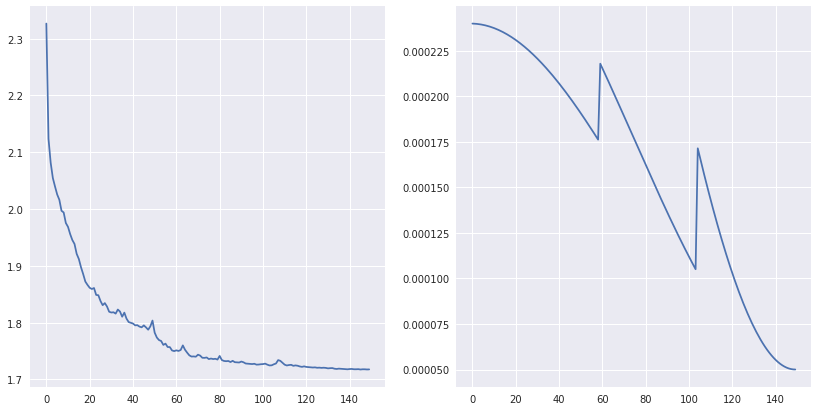

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn')
fig, ax = plt.subplots(1,2, figsize = (14,7))
sns.lineplot(ax= ax[0], x= range(len(loss_list)), y= loss_list)
sns.lineplot(ax= ax[1], x= range(len(lrs)), y= lrs)

/tmp/ipykernel_30195/1075593918.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


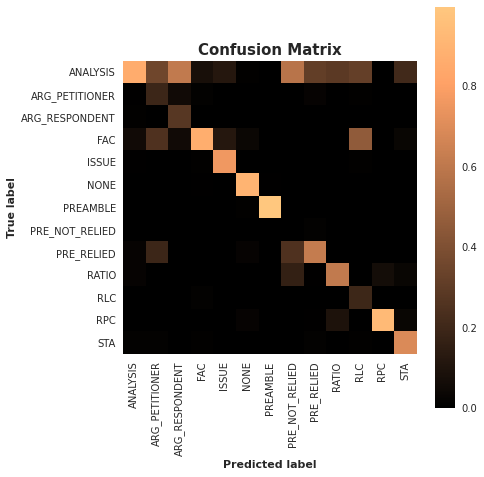

In [49]:
plot_confusion_matrix(np.divide(cm, np.sum(cm,axis=0)), label_encoder= label_encoder1)

# Training with class weights (11 classes)

In [31]:
sample_input.size()

torch.Size([91, 1, 768])

In [32]:
sample_target.size()

torch.Size([91])

In [48]:
input_size:int = 768
hidden_size:int = 256
num_layers:int = 1
output_size:int = 13
dropout:float = 0.1
        
bilstm = nn.LSTM(input_size = input_size,
                        hidden_size = hidden_size,
                        num_layers = num_layers,
                        bidirectional=True)

dense = nn.Sequential(nn.Dropout(p=dropout),
                            nn.Linear(hidden_size*2, 128),
                            nn.ReLU(),
                            nn.Linear(128, output_size),
                            nn.Softmax(dim=1))

In [39]:
x = sample_input.permute(1,0,2)

In [40]:
out, (hidden, cell) = bilstm(x)

In [41]:
out.size()

torch.Size([1, 91, 512])

In [42]:
hidden.size()

torch.Size([2, 91, 256])

In [43]:
cell.size()

torch.Size([2, 91, 256])

In [45]:
out = torch.flatten(hidden.permute(1,0,2),start_dim=1)
out.size()

torch.Size([91, 512])

In [49]:
dense(out).size()

torch.Size([91, 13])

In [64]:
sample_target.size()

torch.Size([28864])

In [31]:
remapped_target = remap_targets(sample_target, label_encoder1, label_encoder)

In [32]:
class_weights = get_class_weights(remapped_target.numpy())
class_weights

tensor([0.2460, 1.3107, 0.4584, 7.1499, 1.8544, 1.6639, 0.6347, 3.8990, 3.5033,
        2.4341, 5.4895])

In [35]:
def grid_search_train_test(parameters, class_weights = None):
    result = []
    
    parameter_configs = grid_search(parameters)
    for config in parameter_configs:
        loss_list = []
        running_lr = []
        model = BiLSTM(hidden_size=config['hidden_size'], num_layers=config['num_layers'], dropout=config['dropout'], output_size= 11)
        model_opt = torch.optim.Adam(model.parameters(), lr= config['learning_rate'])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model_opt, T_max= config['epochs'], eta_min= config['learning_rate_floor'])
        # scheduler1 = torch.optim.lr_scheduler.ConstantLR(model_opt, factor= 0.8, total_iters= config['epochs']*0.4)
        # scheduler2 = torch.optim.lr_scheduler.ConstantLR(model_opt, factor= 0.6, total_iters= config['epochs']*0.7)
        loss_function = nn.CrossEntropyLoss(weight= class_weights)
        print("Working with: ")
        print(config)
        print(f'{"Starting Training":-^100}')
        model.train()
        for epoch in tqdm(range(config['epochs'])):
            running_loss = []
            for idx in range(246):
                TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
                TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
                TRAIN_labels = remap_targets(TRAIN_labels, label_encoder1, label_encoder)
                if TRAIN_emb.size(0) == 0:
                    continue
                output = model(TRAIN_emb)
                loss = loss_function(output,TRAIN_labels)
                
                model_opt.zero_grad()
                loss.backward()
                model_opt.step()
                running_loss.append(loss.item())
            scheduler.step()
            # scheduler1.step()
            # scheduler2.step()
            running_lr.append(model_opt.state_dict()['param_groups'][0]['lr'])
            loss_list.append(np.mean(running_loss))
            print(f"Epoch: {epoch+1} \t Loss: {np.mean(running_loss):.5f} \t LR: {model_opt.state_dict()['param_groups'][0]['lr']}")
        # batch_loss.append(loss.item())
        cm = None
        for i in range(29):
            TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
            TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
            TEST_labels = remap_targets(TEST_labels, label_encoder1, label_encoder)
            conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model, num_labels= 11)
            if cm is None:
                cm = conf_matrix_helper
            else:
                cm = np.add(cm, conf_matrix_helper)
                
        accuracies = class_accuracy(cm)
        f1_scores = class_f1_score(cm)
        average_accuracy = np.mean(accuracies)
        average_f1 = np.mean(f1_scores)

        print("Accuracies: {} \n Average acccuracy: {}".format(accuracies, average_accuracy))
        print("F1 Scores: {} \n Average F1: {}".format(f1_scores, average_f1))
        result.append((config, (average_accuracy, average_f1)))
    return cm, loss_list, result, running_lr, model

In [34]:
parameter_configs = {
    'epochs': [200],
    'learning_rate': [5e-4,8e-4],
    'learning_rate_floor': [5e-6,5e-5],
    'dropout': [0.25],
    'hidden_size': [256],
    'num_layers': [1]
    }

cm, loss_list, result, lrs, trained_model = grid_search_train_test(parameter_configs, class_weights= class_weights)

max_accuracy_config = max(result, key=get_accuracy_value)

print(max_accuracy_config)

Working with: 
{'epochs': 200, 'learning_rate': 0.0005, 'learning_rate_floor': 5e-06, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}
-----------------------------------------Starting Training------------------------------------------


  0%|          | 1/200 [00:16<54:21, 16.39s/it]

Epoch: 1 	 Loss: 2.11387 	 LR: 0.00023998550431659512


  1%|          | 2/200 [00:35<59:01, 17.89s/it]

Epoch: 2 	 Loss: 1.91229 	 LR: 0.00023994202084297347


  2%|▏         | 3/200 [01:01<1:11:23, 21.74s/it]

Epoch: 3 	 Loss: 1.86808 	 LR: 0.0002398695603080315


  2%|▏         | 4/200 [01:26<1:14:27, 22.80s/it]

Epoch: 4 	 Loss: 1.85049 	 LR: 0.00023976814059032192


  2%|▎         | 5/200 [01:49<1:15:23, 23.20s/it]

Epoch: 5 	 Loss: 1.83649 	 LR: 0.00023963778671364254


  3%|▎         | 6/200 [02:13<1:14:57, 23.18s/it]

Epoch: 6 	 Loss: 1.81796 	 LR: 0.00023947853084086188


  4%|▎         | 7/200 [02:38<1:16:45, 23.86s/it]

Epoch: 7 	 Loss: 1.79558 	 LR: 0.0002392904122659836


  4%|▍         | 8/200 [03:09<1:23:24, 26.07s/it]

Epoch: 8 	 Loss: 1.77548 	 LR: 0.00023907347740445114


  4%|▍         | 9/200 [03:30<1:17:48, 24.44s/it]

Epoch: 9 	 Loss: 1.76896 	 LR: 0.00023882777978169548


  5%|▌         | 10/200 [03:51<1:14:02, 23.38s/it]

Epoch: 10 	 Loss: 1.75155 	 LR: 0.00023855338001992866


  6%|▌         | 11/200 [04:11<1:10:27, 22.37s/it]

Epoch: 11 	 Loss: 1.73291 	 LR: 0.0002382503458231859


  6%|▌         | 12/200 [04:32<1:09:07, 22.06s/it]

Epoch: 12 	 Loss: 1.72091 	 LR: 0.00023791875196062088


  6%|▋         | 13/200 [04:53<1:07:33, 21.68s/it]

Epoch: 13 	 Loss: 1.71717 	 LR: 0.00023755868024805742


  7%|▋         | 14/200 [05:17<1:09:22, 22.38s/it]

Epoch: 14 	 Loss: 1.70475 	 LR: 0.0002371702195278028


  8%|▊         | 15/200 [05:38<1:07:53, 22.02s/it]

Epoch: 15 	 Loss: 1.69732 	 LR: 0.00023675346564672696


  8%|▊         | 16/200 [05:58<1:05:36, 21.40s/it]

Epoch: 16 	 Loss: 1.68788 	 LR: 0.00023630852143261412


  8%|▊         | 17/200 [06:17<1:03:09, 20.71s/it]

Epoch: 17 	 Loss: 1.67942 	 LR: 0.00023583549666879124


  9%|▉         | 18/200 [06:37<1:01:51, 20.40s/it]

Epoch: 18 	 Loss: 1.67804 	 LR: 0.00023533450806704077


 10%|▉         | 19/200 [06:56<1:00:21, 20.01s/it]

Epoch: 19 	 Loss: 1.67046 	 LR: 0.00023480567923880372


 10%|█         | 20/200 [07:15<59:40, 19.89s/it]  

Epoch: 20 	 Loss: 1.66698 	 LR: 0.0002342491406646805


 10%|█         | 21/200 [07:41<1:04:09, 21.50s/it]

Epoch: 21 	 Loss: 1.66180 	 LR: 0.00023366502966223651


 11%|█         | 22/200 [08:01<1:03:07, 21.28s/it]

Epoch: 22 	 Loss: 1.65838 	 LR: 0.00023305349035212142


 12%|█▏        | 23/200 [08:23<1:03:25, 21.50s/it]

Epoch: 23 	 Loss: 1.65763 	 LR: 0.00023241467362250935


 12%|█▏        | 24/200 [08:45<1:03:20, 21.60s/it]

Epoch: 24 	 Loss: 1.65160 	 LR: 0.00023174873709186946


 12%|█▎        | 25/200 [09:12<1:07:39, 23.20s/it]

Epoch: 25 	 Loss: 1.64936 	 LR: 0.00023105584507007612


 13%|█▎        | 26/200 [09:34<1:05:47, 22.69s/it]

Epoch: 26 	 Loss: 1.64217 	 LR: 0.0002303361685178677


 14%|█▎        | 27/200 [09:59<1:08:03, 23.61s/it]

Epoch: 27 	 Loss: 1.65471 	 LR: 0.00022958988500466473


 14%|█▍        | 28/200 [10:24<1:08:03, 23.74s/it]

Epoch: 28 	 Loss: 1.64059 	 LR: 0.00022881717866475723


 14%|█▍        | 29/200 [10:47<1:07:31, 23.69s/it]

Epoch: 29 	 Loss: 1.63371 	 LR: 0.00022801824015187226


 15%|█▌        | 30/200 [11:02<59:58, 21.17s/it]  

Epoch: 30 	 Loss: 1.63190 	 LR: 0.00022719326659213315


 16%|█▌        | 31/200 [11:17<54:21, 19.30s/it]

Epoch: 31 	 Loss: 1.63261 	 LR: 0.00022634246153542144


 16%|█▌        | 32/200 [11:31<49:36, 17.72s/it]

Epoch: 32 	 Loss: 1.62876 	 LR: 0.0002254660349051539


 16%|█▋        | 33/200 [11:45<46:08, 16.58s/it]

Epoch: 33 	 Loss: 1.62527 	 LR: 0.0002245642029464874


 17%|█▋        | 34/200 [11:59<43:28, 15.71s/it]

Epoch: 34 	 Loss: 1.62452 	 LR: 0.00022363718817296332


 18%|█▊        | 35/200 [12:13<41:47, 15.20s/it]

Epoch: 35 	 Loss: 1.62070 	 LR: 0.0002226852193116058


 18%|█▊        | 36/200 [12:29<42:34, 15.57s/it]

Epoch: 36 	 Loss: 1.62088 	 LR: 0.00022170853124648673


 18%|█▊        | 37/200 [12:44<41:54, 15.43s/it]

Epoch: 37 	 Loss: 1.62011 	 LR: 0.00022070736496077173


 19%|█▉        | 38/200 [12:59<40:36, 15.04s/it]

Epoch: 38 	 Loss: 1.61910 	 LR: 0.00021968196747726096


 20%|█▉        | 39/200 [13:13<39:53, 14.87s/it]

Epoch: 39 	 Loss: 1.61433 	 LR: 0.0002186325917974402


 20%|██        | 40/200 [13:27<39:02, 14.64s/it]

Epoch: 40 	 Loss: 1.61409 	 LR: 0.0002175594968390563


 20%|██        | 41/200 [13:41<38:16, 14.45s/it]

Epoch: 41 	 Loss: 1.61079 	 LR: 0.00021646294737223313


 21%|██        | 42/200 [13:55<37:33, 14.26s/it]

Epoch: 42 	 Loss: 1.61136 	 LR: 0.00021534321395414357


 22%|██▏       | 43/200 [14:09<37:20, 14.27s/it]

Epoch: 43 	 Loss: 1.61133 	 LR: 0.00021420057286225373


 22%|██▏       | 44/200 [14:24<37:12, 14.31s/it]

Epoch: 44 	 Loss: 1.60949 	 LR: 0.00021303530602615522


 22%|██▎       | 45/200 [14:39<37:47, 14.63s/it]

Epoch: 45 	 Loss: 1.61321 	 LR: 0.00021184770095800364


 23%|██▎       | 46/200 [14:55<38:44, 15.10s/it]

Epoch: 46 	 Loss: 1.60546 	 LR: 0.000210638050681579


 24%|██▎       | 47/200 [15:10<37:53, 14.86s/it]

Epoch: 47 	 Loss: 1.60612 	 LR: 0.0002094066536599866


 24%|██▍       | 48/200 [15:23<36:49, 14.54s/it]

Epoch: 48 	 Loss: 1.60219 	 LR: 0.00020815381372201583


 24%|██▍       | 49/200 [15:38<36:17, 14.42s/it]

Epoch: 49 	 Loss: 1.59980 	 LR: 0.00020687983998717466


 25%|██▌       | 50/200 [15:52<35:44, 14.30s/it]

Epoch: 50 	 Loss: 1.59948 	 LR: 0.0002055850467894193


 26%|██▌       | 51/200 [16:05<35:10, 14.17s/it]

Epoch: 51 	 Loss: 1.60334 	 LR: 0.0002042697535995969


 26%|██▌       | 52/200 [16:19<34:38, 14.04s/it]

Epoch: 52 	 Loss: 1.59930 	 LR: 0.00020293428494662092


 26%|██▋       | 53/200 [16:33<34:22, 14.03s/it]

Epoch: 53 	 Loss: 1.59533 	 LR: 0.00020157897033739835


 27%|██▋       | 54/200 [16:47<33:58, 13.96s/it]

Epoch: 54 	 Loss: 1.59762 	 LR: 0.00020020414417552907


 28%|██▊       | 55/200 [17:01<34:00, 14.07s/it]

Epoch: 55 	 Loss: 1.59803 	 LR: 0.00019881014567879656


 28%|██▊       | 56/200 [17:17<35:08, 14.64s/it]

Epoch: 56 	 Loss: 1.59969 	 LR: 0.000197397318795471


 28%|██▊       | 57/200 [17:31<34:22, 14.43s/it]

Epoch: 57 	 Loss: 1.59346 	 LR: 0.00019596601211944534


 29%|██▉       | 58/200 [17:45<33:43, 14.25s/it]

Epoch: 58 	 Loss: 1.59124 	 LR: 0.0001945165788042247


 30%|██▉       | 59/200 [17:59<33:19, 14.18s/it]

Epoch: 59 	 Loss: 1.59228 	 LR: 0.00019304937647579134


 30%|███       | 60/200 [18:14<33:28, 14.35s/it]

Epoch: 60 	 Loss: 1.59105 	 LR: 0.00019156476714436558


 30%|███       | 61/200 [18:28<32:52, 14.19s/it]

Epoch: 61 	 Loss: 1.58923 	 LR: 0.0001900631171150852


 31%|███       | 62/200 [18:42<32:43, 14.23s/it]

Epoch: 62 	 Loss: 1.58752 	 LR: 0.00018854479689762535


 32%|███▏      | 63/200 [18:56<32:36, 14.28s/it]

Epoch: 63 	 Loss: 1.58936 	 LR: 0.00018701018111478047


 32%|███▏      | 64/200 [19:19<37:49, 16.69s/it]

Epoch: 64 	 Loss: 1.58979 	 LR: 0.00018545964841003206


 32%|███▎      | 65/200 [19:51<48:18, 21.47s/it]

Epoch: 65 	 Loss: 1.58708 	 LR: 0.00018389358135412396


 33%|███▎      | 66/200 [20:20<52:37, 23.56s/it]

Epoch: 66 	 Loss: 1.58537 	 LR: 0.0001823123663506686


 34%|███▎      | 67/200 [20:48<55:25, 25.00s/it]

Epoch: 67 	 Loss: 1.58575 	 LR: 0.00018071639354080786


 34%|███▍      | 68/200 [21:18<58:17, 26.50s/it]

Epoch: 68 	 Loss: 1.58390 	 LR: 0.0001791060567069515


 34%|███▍      | 69/200 [21:42<56:30, 25.88s/it]

Epoch: 69 	 Loss: 1.58425 	 LR: 0.00017748175317561736


 35%|███▌      | 70/200 [22:04<53:24, 24.65s/it]

Epoch: 70 	 Loss: 1.58778 	 LR: 0.00017584388371939672


 36%|███▌      | 71/200 [22:29<52:57, 24.63s/it]

Epoch: 71 	 Loss: 1.58690 	 LR: 0.00017419285245807


 36%|███▌      | 72/200 [22:51<50:45, 23.80s/it]

Epoch: 72 	 Loss: 1.58424 	 LR: 0.00017252906675889603


 36%|███▋      | 73/200 [23:12<48:55, 23.12s/it]

Epoch: 73 	 Loss: 1.58212 	 LR: 0.00017085293713610028


 37%|███▋      | 74/200 [23:29<44:35, 21.23s/it]

Epoch: 74 	 Loss: 1.58429 	 LR: 0.0001691648771495867


 38%|███▊      | 75/200 [23:45<40:50, 19.61s/it]

Epoch: 75 	 Loss: 1.58249 	 LR: 0.00016746530330289807


 38%|███▊      | 76/200 [24:00<38:01, 18.40s/it]

Epoch: 76 	 Loss: 1.58229 	 LR: 0.0001657546349404497


 38%|███▊      | 77/200 [24:16<35:58, 17.55s/it]

Epoch: 77 	 Loss: 1.58108 	 LR: 0.00016403329414406274


 39%|███▉      | 78/200 [24:34<35:52, 17.65s/it]

Epoch: 78 	 Loss: 1.58044 	 LR: 0.0001623017056288218


 40%|███▉      | 79/200 [24:51<35:05, 17.40s/it]

Epoch: 79 	 Loss: 1.57930 	 LR: 0.0001605602966382826


 40%|████      | 80/200 [25:07<33:50, 16.92s/it]

Epoch: 80 	 Loss: 1.57862 	 LR: 0.00019851187104882043


 40%|████      | 81/200 [25:22<32:41, 16.48s/it]

Epoch: 81 	 Loss: 1.58122 	 LR: 0.0001962978713220591


 41%|████      | 82/200 [25:38<32:16, 16.41s/it]

Epoch: 82 	 Loss: 1.58833 	 LR: 0.00019407314652750726


 42%|████▏     | 83/200 [25:54<31:25, 16.11s/it]

Epoch: 83 	 Loss: 1.58265 	 LR: 0.0001918382455827186


 42%|████▏     | 84/200 [26:09<30:53, 15.97s/it]

Epoch: 84 	 Loss: 1.58117 	 LR: 0.00018959371991605982


 42%|████▎     | 85/200 [26:25<30:31, 15.93s/it]

Epoch: 85 	 Loss: 1.58044 	 LR: 0.0001873401233306536


 43%|████▎     | 86/200 [26:41<30:31, 16.06s/it]

Epoch: 86 	 Loss: 1.57988 	 LR: 0.00018507801186773605


 44%|████▎     | 87/200 [26:58<30:38, 16.27s/it]

Epoch: 87 	 Loss: 1.57943 	 LR: 0.00018280794366946194


 44%|████▍     | 88/200 [27:15<30:47, 16.50s/it]

Epoch: 88 	 Loss: 1.57877 	 LR: 0.00018053047884119145


 44%|████▍     | 89/200 [27:32<30:24, 16.43s/it]

Epoch: 89 	 Loss: 1.57812 	 LR: 0.00017824617931329245


 45%|████▌     | 90/200 [27:50<31:01, 16.93s/it]

Epoch: 90 	 Loss: 1.57762 	 LR: 0.0001759556087024929


 46%|████▌     | 91/200 [28:06<30:34, 16.83s/it]

Epoch: 91 	 Loss: 1.57854 	 LR: 0.00017365933217281635


 46%|████▌     | 92/200 [28:22<29:53, 16.61s/it]

Epoch: 92 	 Loss: 1.57932 	 LR: 0.00017135791629613661


 46%|████▋     | 93/200 [28:38<29:20, 16.45s/it]

Epoch: 93 	 Loss: 1.57803 	 LR: 0.0001690519289123844


 47%|████▋     | 94/200 [28:54<28:50, 16.32s/it]

Epoch: 94 	 Loss: 1.57690 	 LR: 0.00016674193898944147


 48%|████▊     | 95/200 [29:10<28:04, 16.05s/it]

Epoch: 95 	 Loss: 1.57586 	 LR: 0.00016442851648275619


 48%|████▊     | 96/200 [29:28<29:10, 16.83s/it]

Epoch: 96 	 Loss: 1.57619 	 LR: 0.00016211223219471556


 48%|████▊     | 97/200 [29:45<28:34, 16.64s/it]

Epoch: 97 	 Loss: 1.57766 	 LR: 0.00015979365763380834


 49%|████▉     | 98/200 [30:01<27:57, 16.45s/it]

Epoch: 98 	 Loss: 1.57821 	 LR: 0.00015747336487361392


 50%|████▉     | 99/200 [30:17<27:27, 16.31s/it]

Epoch: 99 	 Loss: 1.57587 	 LR: 0.00015515192641165157


 50%|█████     | 100/200 [30:33<27:01, 16.22s/it]

Epoch: 100 	 Loss: 1.57521 	 LR: 0.00015282991502812532


 50%|█████     | 101/200 [30:49<26:47, 16.24s/it]

Epoch: 101 	 Loss: 1.57632 	 LR: 0.0001505079036445991


 51%|█████     | 102/200 [31:04<26:09, 16.02s/it]

Epoch: 102 	 Loss: 1.57524 	 LR: 0.00014818646518263668


 52%|█████▏    | 103/200 [31:20<25:38, 15.86s/it]

Epoch: 103 	 Loss: 1.57431 	 LR: 0.00014586617242244227


 52%|█████▏    | 104/200 [31:36<25:36, 16.01s/it]

Epoch: 104 	 Loss: 1.57558 	 LR: 0.00014354759786153507


 52%|█████▎    | 105/200 [31:54<26:02, 16.45s/it]

Epoch: 105 	 Loss: 1.57466 	 LR: 0.00014123131357349447


 53%|█████▎    | 106/200 [32:10<25:47, 16.46s/it]

Epoch: 106 	 Loss: 1.57360 	 LR: 0.00013891789106680916


 54%|█████▎    | 107/200 [32:26<25:12, 16.26s/it]

Epoch: 107 	 Loss: 1.57370 	 LR: 0.00013660790114386625


 54%|█████▍    | 108/200 [32:42<24:48, 16.18s/it]

Epoch: 108 	 Loss: 1.57473 	 LR: 0.00013430191376011407


 55%|█████▍    | 109/200 [32:58<24:14, 15.98s/it]

Epoch: 109 	 Loss: 1.57365 	 LR: 0.00013200049788343436


 55%|█████▌    | 110/200 [33:14<24:10, 16.11s/it]

Epoch: 110 	 Loss: 1.57340 	 LR: 0.0001297042213537578


 56%|█████▌    | 111/200 [33:30<23:44, 16.01s/it]

Epoch: 111 	 Loss: 1.57198 	 LR: 0.0001274136507429582


 56%|█████▌    | 112/200 [33:53<26:44, 18.23s/it]

Epoch: 112 	 Loss: 1.57192 	 LR: 0.0001251293512150593


 56%|█████▋    | 113/200 [34:10<25:52, 17.85s/it]

Epoch: 113 	 Loss: 1.57270 	 LR: 0.0001228518863867888


 57%|█████▋    | 114/200 [34:27<25:18, 17.66s/it]

Epoch: 114 	 Loss: 1.57250 	 LR: 0.0001205818181885147


 57%|█████▊    | 115/200 [34:44<24:29, 17.28s/it]

Epoch: 115 	 Loss: 1.57354 	 LR: 0.00011831970672559706


 58%|█████▊    | 116/200 [34:59<23:32, 16.82s/it]

Epoch: 116 	 Loss: 1.57095 	 LR: 0.0001160661101401908


 58%|█████▊    | 117/200 [35:16<23:09, 16.74s/it]

Epoch: 117 	 Loss: 1.57056 	 LR: 0.00011382158447353203


 59%|█████▉    | 118/200 [35:32<22:34, 16.51s/it]

Epoch: 118 	 Loss: 1.57024 	 LR: 0.00011158668352874341


 60%|█████▉    | 119/200 [35:49<22:20, 16.55s/it]

Epoch: 119 	 Loss: 1.56921 	 LR: 0.00010936195873419155


 60%|██████    | 120/200 [36:04<21:36, 16.21s/it]

Epoch: 120 	 Loss: 1.56991 	 LR: 0.00010714795900743025


 60%|██████    | 121/200 [36:20<21:20, 16.21s/it]

Epoch: 121 	 Loss: 1.56913 	 LR: 0.0001049452306197632


 61%|██████    | 122/200 [36:37<21:27, 16.50s/it]

Epoch: 122 	 Loss: 1.56890 	 LR: 0.00010275431706146005


 62%|██████▏   | 123/200 [36:54<21:17, 16.60s/it]

Epoch: 123 	 Loss: 1.56908 	 LR: 0.00010057575890765793


 62%|██████▏   | 124/200 [37:10<20:41, 16.33s/it]

Epoch: 124 	 Loss: 1.56898 	 LR: 9.84100936849828e-05


 62%|██████▎   | 125/200 [37:26<20:19, 16.26s/it]

Epoch: 125 	 Loss: 1.56868 	 LR: 9.625785573892282e-05


 63%|██████▎   | 126/200 [37:42<19:53, 16.13s/it]

Epoch: 126 	 Loss: 1.56902 	 LR: 9.411957610198651e-05


 64%|██████▎   | 127/200 [37:58<19:42, 16.20s/it]

Epoch: 127 	 Loss: 1.56887 	 LR: 9.199578236267863e-05


 64%|██████▍   | 128/200 [38:14<19:14, 16.03s/it]

Epoch: 128 	 Loss: 1.56809 	 LR: 8.988699853532527e-05


 64%|██████▍   | 129/200 [38:30<19:03, 16.10s/it]

Epoch: 129 	 Loss: 1.56779 	 LR: 8.779374493078141e-05


 65%|██████▌   | 130/200 [38:47<18:56, 16.23s/it]

Epoch: 130 	 Loss: 1.56738 	 LR: 8.5716538028052e-05


 66%|██████▌   | 131/200 [39:06<19:35, 17.04s/it]

Epoch: 131 	 Loss: 1.56739 	 LR: 8.365589034685834e-05


 66%|██████▌   | 132/200 [39:22<18:56, 16.72s/it]

Epoch: 132 	 Loss: 1.56689 	 LR: 8.161231032118157e-05


 66%|██████▋   | 133/200 [39:38<18:24, 16.49s/it]

Epoch: 133 	 Loss: 1.56657 	 LR: 7.95863021738144e-05


 67%|██████▋   | 134/200 [39:53<17:56, 16.32s/it]

Epoch: 134 	 Loss: 1.56618 	 LR: 7.757836579195133e-05


 68%|██████▊   | 135/200 [40:10<17:37, 16.27s/it]

Epoch: 135 	 Loss: 1.56642 	 LR: 7.558899660384918e-05


 68%|██████▊   | 136/200 [40:26<17:13, 16.15s/it]

Epoch: 136 	 Loss: 1.56646 	 LR: 7.361868545658749e-05


 68%|██████▊   | 137/200 [40:41<16:50, 16.04s/it]

Epoch: 137 	 Loss: 1.56648 	 LR: 7.166791849495958e-05


 69%|██████▉   | 138/200 [40:57<16:30, 15.98s/it]

Epoch: 138 	 Loss: 1.56654 	 LR: 6.973717704152319e-05


 70%|██████▉   | 139/200 [41:13<16:11, 15.93s/it]

Epoch: 139 	 Loss: 1.56623 	 LR: 6.782693747784168e-05


 70%|███████   | 140/200 [41:32<16:52, 16.88s/it]

Epoch: 140 	 Loss: 1.56635 	 LR: 0.00010989611854490641


 70%|███████   | 141/200 [41:48<16:19, 16.61s/it]

Epoch: 141 	 Loss: 1.56856 	 LR: 0.00010668090211586023


 71%|███████   | 142/200 [42:04<15:46, 16.32s/it]

Epoch: 142 	 Loss: 1.56937 	 LR: 0.00010350338400974446


 72%|███████▏  | 143/200 [42:20<15:25, 16.23s/it]

Epoch: 143 	 Loss: 1.56896 	 LR: 0.0001003643482316057


 72%|███████▏  | 144/200 [42:36<15:02, 16.11s/it]

Epoch: 144 	 Loss: 1.56759 	 LR: 9.726456929155172e-05


 72%|███████▎  | 145/200 [42:52<14:53, 16.25s/it]

Epoch: 145 	 Loss: 1.56712 	 LR: 9.420481201365305e-05


 73%|███████▎  | 146/200 [43:10<14:58, 16.64s/it]

Epoch: 146 	 Loss: 1.56595 	 LR: 9.11858313472338e-05


 74%|███████▎  | 147/200 [43:25<14:29, 16.40s/it]

Epoch: 147 	 Loss: 1.56600 	 LR: 8.820837218059939e-05


 74%|███████▍  | 148/200 [43:41<13:57, 16.11s/it]

Epoch: 148 	 Loss: 1.56576 	 LR: 8.527316915724665e-05


 74%|███████▍  | 149/200 [44:01<14:45, 17.36s/it]

Epoch: 149 	 Loss: 1.56560 	 LR: 8.238094649460115e-05


 75%|███████▌  | 150/200 [44:17<13:58, 16.77s/it]

Epoch: 150 	 Loss: 1.56603 	 LR: 7.953241780532763e-05


 76%|███████▌  | 151/200 [44:33<13:33, 16.61s/it]

Epoch: 151 	 Loss: 1.56582 	 LR: 7.672828592125672e-05


 76%|███████▌  | 152/200 [44:48<13:03, 16.32s/it]

Epoch: 152 	 Loss: 1.56580 	 LR: 7.39692427199717e-05


 76%|███████▋  | 153/200 [45:04<12:41, 16.19s/it]

Epoch: 153 	 Loss: 1.56541 	 LR: 7.125596895409793e-05


 77%|███████▋  | 154/200 [45:20<12:14, 15.97s/it]

Epoch: 154 	 Loss: 1.56547 	 LR: 6.858913408333773e-05


 78%|███████▊  | 155/200 [45:36<12:04, 16.10s/it]

Epoch: 155 	 Loss: 1.56533 	 LR: 6.596939610929068e-05


 78%|███████▊  | 156/200 [45:52<11:38, 15.88s/it]

Epoch: 156 	 Loss: 1.56569 	 LR: 6.339740141310188e-05


 78%|███████▊  | 157/200 [46:08<11:26, 15.96s/it]

Epoch: 157 	 Loss: 1.56521 	 LR: 6.0873784595977047e-05


 79%|███████▉  | 158/200 [46:26<11:39, 16.66s/it]

Epoch: 158 	 Loss: 1.56505 	 LR: 5.839916832260404e-05


 80%|███████▉  | 159/200 [46:42<11:17, 16.54s/it]

Epoch: 159 	 Loss: 1.56505 	 LR: 5.597416316751996e-05


 80%|████████  | 160/200 [46:58<10:51, 16.30s/it]

Epoch: 160 	 Loss: 1.56504 	 LR: 5.359936746446066e-05


 80%|████████  | 161/200 [47:14<10:35, 16.29s/it]

Epoch: 161 	 Loss: 1.56496 	 LR: 5.1275367158731e-05


 81%|████████  | 162/200 [47:30<10:10, 16.05s/it]

Epoch: 162 	 Loss: 1.56484 	 LR: 4.900273566263166e-05


 82%|████████▏ | 163/200 [47:46<09:54, 16.07s/it]

Epoch: 163 	 Loss: 1.56485 	 LR: 4.6782033713978224e-05


 82%|████████▏ | 164/200 [48:02<09:35, 15.98s/it]

Epoch: 164 	 Loss: 1.56469 	 LR: 4.4613809237747404e-05


 82%|████████▎ | 165/200 [48:18<09:21, 16.04s/it]

Epoch: 165 	 Loss: 1.56468 	 LR: 4.24985972108849e-05


 83%|████████▎ | 166/200 [48:34<09:04, 16.00s/it]

Epoch: 166 	 Loss: 1.56469 	 LR: 4.0436919530307614e-05


 84%|████████▎ | 167/200 [48:52<09:13, 16.78s/it]

Epoch: 167 	 Loss: 1.56467 	 LR: 3.8429284884133916e-05


 84%|████████▍ | 168/200 [49:08<08:47, 16.50s/it]

Epoch: 168 	 Loss: 1.56462 	 LR: 3.647618862617176e-05


 84%|████████▍ | 169/200 [49:24<08:25, 16.29s/it]

Epoch: 169 	 Loss: 1.56443 	 LR: 3.4578112653697955e-05


 85%|████████▌ | 170/200 [49:40<08:04, 16.16s/it]

Epoch: 170 	 Loss: 1.56448 	 LR: 3.273552528855726e-05


 86%|████████▌ | 171/200 [49:56<07:45, 16.06s/it]

Epoch: 171 	 Loss: 1.56458 	 LR: 3.094888116161072e-05


 86%|████████▌ | 172/200 [50:12<07:28, 16.01s/it]

Epoch: 172 	 Loss: 1.56439 	 LR: 2.921862110056258e-05


 86%|████████▋ | 173/200 [50:27<07:09, 15.90s/it]

Epoch: 173 	 Loss: 1.56443 	 LR: 2.7545172021192434e-05


 87%|████████▋ | 174/200 [50:43<06:52, 15.87s/it]

Epoch: 174 	 Loss: 1.56439 	 LR: 2.5928946822020285e-05


 88%|████████▊ | 175/200 [50:59<06:36, 15.87s/it]

Epoch: 175 	 Loss: 1.56433 	 LR: 2.4370344282429916e-05


 88%|████████▊ | 176/200 [51:17<06:37, 16.58s/it]

Epoch: 176 	 Loss: 1.56421 	 LR: 2.2869748964276056e-05


 88%|████████▊ | 177/200 [51:34<06:23, 16.66s/it]

Epoch: 177 	 Loss: 1.56435 	 LR: 2.1427531116999644e-05


 89%|████████▉ | 178/200 [51:49<05:57, 16.27s/it]

Epoch: 178 	 Loss: 1.56420 	 LR: 2.0044046586274148e-05


 90%|████████▉ | 179/200 [52:06<05:43, 16.35s/it]

Epoch: 179 	 Loss: 1.56418 	 LR: 1.871963672620594e-05


 90%|█████████ | 180/200 [52:21<05:22, 16.13s/it]

Epoch: 180 	 Loss: 1.56417 	 LR: 1.7454628315110443e-05


 90%|█████████ | 181/200 [52:38<05:07, 16.17s/it]

Epoch: 181 	 Loss: 1.56424 	 LR: 1.624933347488435e-05


 91%|█████████ | 182/200 [52:54<04:51, 16.17s/it]

Epoch: 182 	 Loss: 1.56409 	 LR: 1.5104049593994323e-05


 92%|█████████▏| 183/200 [53:10<04:34, 16.16s/it]

Epoch: 183 	 Loss: 1.56400 	 LR: 1.4019059254100659e-05


 92%|█████████▏| 184/200 [53:27<04:23, 16.47s/it]

Epoch: 184 	 Loss: 1.56405 	 LR: 1.2994630160334698e-05


 92%|█████████▎| 185/200 [53:45<04:11, 16.78s/it]

Epoch: 185 	 Loss: 1.56402 	 LR: 1.2031015075246426e-05


 93%|█████████▎| 186/200 [54:01<03:51, 16.52s/it]

Epoch: 186 	 Loss: 1.56394 	 LR: 1.1128451756439273e-05


 94%|█████████▎| 187/200 [54:17<03:33, 16.40s/it]

Epoch: 187 	 Loss: 1.56391 	 LR: 1.0287162897906733e-05


 94%|█████████▍| 188/200 [54:33<03:15, 16.27s/it]

Epoch: 188 	 Loss: 1.56402 	 LR: 9.507356075086268e-06


 94%|█████████▍| 189/200 [54:49<02:58, 16.21s/it]

Epoch: 189 	 Loss: 1.56391 	 LR: 8.789223693642872e-06


 95%|█████████▌| 190/200 [55:04<02:39, 15.99s/it]

Epoch: 190 	 Loss: 1.56397 	 LR: 8.132942941995989e-06


 96%|█████████▌| 191/200 [55:20<02:23, 15.95s/it]

Epoch: 191 	 Loss: 1.56387 	 LR: 7.5386757476009535e-06


 96%|█████████▌| 192/200 [55:36<02:07, 15.95s/it]

Epoch: 192 	 Loss: 1.56392 	 LR: 7.006568736995804e-06


 96%|█████████▋| 193/200 [55:53<01:54, 16.38s/it]

Epoch: 193 	 Loss: 1.56387 	 LR: 6.536753199623298e-06


 97%|█████████▋| 194/200 [56:11<01:39, 16.60s/it]

Epoch: 194 	 Loss: 1.56385 	 LR: 6.1293450554372574e-06


 98%|█████████▊| 195/200 [56:28<01:23, 16.72s/it]

Epoch: 195 	 Loss: 1.56388 	 LR: 5.784444826301127e-06


 98%|█████████▊| 196/200 [56:43<01:05, 16.46s/it]

Epoch: 196 	 Loss: 1.56385 	 LR: 5.502137611185572e-06


 98%|█████████▊| 197/200 [56:59<00:48, 16.28s/it]

Epoch: 197 	 Loss: 1.56382 	 LR: 5.28249306517169e-06


 99%|█████████▉| 198/200 [57:15<00:32, 16.13s/it]

Epoch: 198 	 Loss: 1.56384 	 LR: 5.125565382264533e-06


100%|█████████▉| 199/200 [57:31<00:16, 16.10s/it]

Epoch: 199 	 Loss: 1.56383 	 LR: 5.031393282021787e-06


100%|██████████| 200/200 [57:53<00:00, 17.37s/it]

Epoch: 200 	 Loss: 1.56378 	 LR: 5e-06


Accuracies: [0.78249097 0.52       0.8092869  0.84444444 0.96132597 0.7734375
 0.99211045 0.59459459 0.61904762 0.88764045 0.59375   ] 
 Average acccuracy: 0.7616480819629985
F1 Scores: [0.83245314 0.33766229 0.82571907 0.79999995 0.93800534 0.70714281
 0.99505435 0.60273968 0.32911388 0.89265532 0.62295077] 
 Average F1: 0.7166815088196026
Working with: 
{'epochs': 200, 'learning_rate': 0.0005, 'learning_rate_floor': 5e-05, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}
-----------------------------------------Starting Training------------------------------------------


  0%|          | 1/200 [00:18<1:01:59, 18.69s/it]

Epoch: 1 	 Loss: 2.10148 	 LR: 0.00023998828008575776


  1%|          | 2/200 [00:38<1:03:33, 19.26s/it]

Epoch: 2 	 Loss: 1.90687 	 LR: 0.0002399531232347445


  2%|▏         | 3/200 [00:54<58:30, 17.82s/it]  

Epoch: 3 	 Loss: 1.85834 	 LR: 0.00023989453812138718


  2%|▏         | 4/200 [01:10<56:03, 17.16s/it]

Epoch: 4 	 Loss: 1.83456 	 LR: 0.0002398125392006858


  2%|▎         | 5/200 [01:26<54:19, 16.71s/it]

Epoch: 5 	 Loss: 1.81453 	 LR: 0.00023970714670464716


  3%|▎         | 6/200 [01:42<53:12, 16.45s/it]

Epoch: 6 	 Loss: 1.79419 	 LR: 0.00023957838663729258


  4%|▎         | 7/200 [01:58<52:21, 16.28s/it]

Epoch: 7 	 Loss: 1.77793 	 LR: 0.00023942629076824205


  4%|▍         | 8/200 [02:14<51:45, 16.18s/it]

Epoch: 8 	 Loss: 1.76139 	 LR: 0.00023925089662487538


  4%|▍         | 9/200 [02:30<51:09, 16.07s/it]

Epoch: 9 	 Loss: 1.74932 	 LR: 0.00023905224748307292


  5%|▌         | 10/200 [02:48<53:13, 16.81s/it]

Epoch: 10 	 Loss: 1.73562 	 LR: 0.00023883039235653804


  6%|▌         | 11/200 [03:04<52:28, 16.66s/it]

Epoch: 11 	 Loss: 1.72767 	 LR: 0.00023858538598470346


  6%|▌         | 12/200 [03:20<51:22, 16.40s/it]

Epoch: 12 	 Loss: 1.71385 	 LR: 0.00023831728881922536


  6%|▋         | 13/200 [03:37<51:20, 16.47s/it]

Epoch: 13 	 Loss: 1.70479 	 LR: 0.00023802616700906767


  7%|▋         | 14/200 [03:53<50:32, 16.31s/it]

Epoch: 14 	 Loss: 1.69700 	 LR: 0.00023771209238418093


  8%|▊         | 15/200 [04:09<50:03, 16.24s/it]

Epoch: 15 	 Loss: 1.69146 	 LR: 0.0002373751424377792


  8%|▊         | 16/200 [04:24<49:08, 16.02s/it]

Epoch: 16 	 Loss: 1.68554 	 LR: 0.00023701540030721986


  8%|▊         | 17/200 [04:41<49:03, 16.09s/it]

Epoch: 17 	 Loss: 1.67736 	 LR: 0.00023663295475349072


  9%|▉         | 18/200 [04:56<48:25, 15.97s/it]

Epoch: 18 	 Loss: 1.67018 	 LR: 0.0002362279001393095


 10%|▉         | 19/200 [05:16<51:17, 17.00s/it]

Epoch: 19 	 Loss: 1.67113 	 LR: 0.00023580033640584127


 10%|█         | 20/200 [05:32<50:18, 16.77s/it]

Epoch: 20 	 Loss: 1.66318 	 LR: 0.0002353503690480395


 10%|█         | 21/200 [05:48<49:23, 16.56s/it]

Epoch: 21 	 Loss: 1.66018 	 LR: 0.0002348781090886167


 11%|█         | 22/200 [06:04<48:11, 16.25s/it]

Epoch: 22 	 Loss: 1.66306 	 LR: 0.0002343836730506513


 12%|█▏        | 23/200 [06:20<47:52, 16.23s/it]

Epoch: 23 	 Loss: 1.66316 	 LR: 0.0002338671829288373


 12%|█▏        | 24/200 [06:35<46:49, 15.97s/it]

Epoch: 24 	 Loss: 1.65155 	 LR: 0.00023332876615938375


 12%|█▎        | 25/200 [06:51<46:39, 15.99s/it]

Epoch: 25 	 Loss: 1.64547 	 LR: 0.00023276855558857212


 13%|█▎        | 26/200 [07:07<46:22, 15.99s/it]

Epoch: 26 	 Loss: 1.64356 	 LR: 0.00023218668943997806


 14%|█▎        | 27/200 [07:23<45:59, 15.95s/it]

Epoch: 27 	 Loss: 1.63808 	 LR: 0.00023158331128036715


 14%|█▍        | 28/200 [07:42<48:21, 16.87s/it]

Epoch: 28 	 Loss: 1.63663 	 LR: 0.00023095856998427172


 14%|█▍        | 29/200 [07:58<47:16, 16.59s/it]

Epoch: 29 	 Loss: 1.63283 	 LR: 0.00023031261969725834


 15%|█▌        | 30/200 [08:14<46:17, 16.34s/it]

Epoch: 30 	 Loss: 1.63088 	 LR: 0.0002296456197978948


 16%|█▌        | 31/200 [08:30<45:46, 16.25s/it]

Epoch: 31 	 Loss: 1.64399 	 LR: 0.00022895773485842578


 16%|█▌        | 32/200 [08:46<45:22, 16.20s/it]

Epoch: 32 	 Loss: 1.63134 	 LR: 0.0002282491346041669


 16%|█▋        | 33/200 [09:02<44:53, 16.13s/it]

Epoch: 33 	 Loss: 1.62772 	 LR: 0.00022751999387162804


 17%|█▋        | 34/200 [09:17<44:13, 15.99s/it]

Epoch: 34 	 Loss: 1.62199 	 LR: 0.00022677049256537453


 18%|█▊        | 35/200 [09:34<44:04, 16.03s/it]

Epoch: 35 	 Loss: 1.61729 	 LR: 0.00022600081561363866


 18%|█▊        | 36/200 [09:49<43:39, 15.97s/it]

Epoch: 36 	 Loss: 1.61619 	 LR: 0.00022521115292269134


 18%|█▊        | 37/200 [10:08<45:53, 16.89s/it]

Epoch: 37 	 Loss: 1.61439 	 LR: 0.0002244016993299856


 19%|█▉        | 38/200 [10:25<45:02, 16.68s/it]

Epoch: 38 	 Loss: 1.61823 	 LR: 0.00022357265455608328


 20%|█▉        | 39/200 [10:41<44:33, 16.61s/it]

Epoch: 39 	 Loss: 1.61230 	 LR: 0.00022272422315537714


 20%|██        | 40/200 [10:56<43:10, 16.19s/it]

Epoch: 40 	 Loss: 1.61428 	 LR: 0.00022185661446561994


 20%|██        | 41/200 [11:13<42:55, 16.20s/it]

Epoch: 41 	 Loss: 1.61110 	 LR: 0.00022097004255627355


 21%|██        | 42/200 [11:28<42:06, 15.99s/it]

Epoch: 42 	 Loss: 1.60771 	 LR: 0.0002200647261756905


 22%|██▏       | 43/200 [11:44<41:53, 16.01s/it]

Epoch: 43 	 Loss: 1.60639 	 LR: 0.00021914088869714126


 22%|██▏       | 44/200 [12:00<41:24, 15.92s/it]

Epoch: 44 	 Loss: 1.60485 	 LR: 0.0002181987580636999


 22%|██▎       | 45/200 [12:16<41:29, 16.06s/it]

Epoch: 45 	 Loss: 1.60279 	 LR: 0.00021723856673200288


 23%|██▎       | 46/200 [12:35<43:15, 16.86s/it]

Epoch: 46 	 Loss: 1.60381 	 LR: 0.0002162605516148936


 24%|██▎       | 47/200 [12:51<42:41, 16.74s/it]

Epoch: 47 	 Loss: 1.60503 	 LR: 0.00021526495402296783


 24%|██▍       | 48/200 [13:08<42:12, 16.66s/it]

Epoch: 48 	 Loss: 1.60631 	 LR: 0.00021425201960503402


 24%|██▍       | 49/200 [13:24<41:25, 16.46s/it]

Epoch: 49 	 Loss: 1.60432 	 LR: 0.00021322199828750286


 25%|██▌       | 50/200 [13:40<40:45, 16.31s/it]

Epoch: 50 	 Loss: 1.59841 	 LR: 0.00021217514421272192


 26%|██▌       | 51/200 [13:55<39:58, 16.10s/it]

Epoch: 51 	 Loss: 1.59602 	 LR: 0.00021111171567626976


 26%|██▌       | 52/200 [14:12<40:05, 16.25s/it]

Epoch: 52 	 Loss: 1.59586 	 LR: 0.00021003197506322535


 26%|██▋       | 53/200 [14:28<39:14, 16.02s/it]

Epoch: 53 	 Loss: 1.59320 	 LR: 0.00020893618878342838


 27%|██▋       | 54/200 [14:46<41:05, 16.89s/it]

Epoch: 54 	 Loss: 1.59478 	 LR: 0.00020782462720574685


 28%|██▊       | 55/200 [15:02<40:12, 16.63s/it]

Epoch: 55 	 Loss: 1.59730 	 LR: 0.00020669756459136738


 28%|██▊       | 56/200 [15:19<40:07, 16.72s/it]

Epoch: 56 	 Loss: 1.59686 	 LR: 0.00020555527902612545


 28%|██▊       | 57/200 [15:35<39:07, 16.41s/it]

Epoch: 57 	 Loss: 1.59169 	 LR: 0.00020439805235189192


 29%|██▉       | 58/200 [15:51<38:13, 16.15s/it]

Epoch: 58 	 Loss: 1.59043 	 LR: 0.00020322617009703269


 30%|██▉       | 59/200 [16:07<38:01, 16.18s/it]

Epoch: 59 	 Loss: 1.59041 	 LR: 0.0002020399214059589


 30%|███       | 60/200 [16:23<37:48, 16.20s/it]

Epoch: 60 	 Loss: 1.58913 	 LR: 0.00020083959896778487


 30%|███       | 61/200 [16:40<37:59, 16.40s/it]

Epoch: 61 	 Loss: 1.58653 	 LR: 0.00019962549894411138


 31%|███       | 62/200 [16:57<38:02, 16.54s/it]

Epoch: 62 	 Loss: 1.58941 	 LR: 0.00019839792089595235


 32%|███▏      | 63/200 [17:13<37:26, 16.40s/it]

Epoch: 63 	 Loss: 1.58582 	 LR: 0.00019715716770982245


 32%|███▏      | 64/200 [17:28<36:19, 16.02s/it]

Epoch: 64 	 Loss: 1.58674 	 LR: 0.0001959035455230046


 32%|███▎      | 65/200 [17:44<36:10, 16.08s/it]

Epoch: 65 	 Loss: 1.58688 	 LR: 0.00019463736364801508


 33%|███▎      | 66/200 [17:59<35:14, 15.78s/it]

Epoch: 66 	 Loss: 1.58682 	 LR: 0.0001933589344962852


 34%|███▎      | 67/200 [18:15<35:06, 15.84s/it]

Epoch: 67 	 Loss: 1.58476 	 LR: 0.00019206857350107865


 34%|███▍      | 68/200 [18:31<34:37, 15.73s/it]

Epoch: 68 	 Loss: 1.58619 	 LR: 0.00019076659903966285


 34%|███▍      | 69/200 [18:47<34:32, 15.82s/it]

Epoch: 69 	 Loss: 1.58668 	 LR: 0.00018945333235475438


 35%|███▌      | 70/200 [19:05<35:53, 16.57s/it]

Epoch: 70 	 Loss: 1.58310 	 LR: 0.00018812909747525686


 36%|███▌      | 71/200 [19:21<35:11, 16.37s/it]

Epoch: 71 	 Loss: 1.58392 	 LR: 0.00018679422113631185


 36%|███▌      | 72/200 [19:37<34:39, 16.25s/it]

Epoch: 72 	 Loss: 1.58144 	 LR: 0.00018544903269868184


 36%|███▋      | 73/200 [19:53<34:14, 16.18s/it]

Epoch: 73 	 Loss: 1.58210 	 LR: 0.0001840938640674853


 37%|███▋      | 74/200 [20:09<33:57, 16.17s/it]

Epoch: 74 	 Loss: 1.58689 	 LR: 0.00018272904961030408


 38%|███▊      | 75/200 [20:25<33:35, 16.13s/it]

Epoch: 75 	 Loss: 1.58435 	 LR: 0.00018135492607468346


 38%|███▊      | 76/200 [20:41<33:11, 16.06s/it]

Epoch: 76 	 Loss: 1.57976 	 LR: 0.00017997183250504435


 38%|███▊      | 77/200 [20:57<32:43, 15.97s/it]

Epoch: 77 	 Loss: 1.57859 	 LR: 0.00017858011015902937


 39%|███▉      | 78/200 [21:15<33:51, 16.65s/it]

Epoch: 78 	 Loss: 1.57913 	 LR: 0.00017718010242330265


 40%|███▉      | 79/200 [21:31<33:08, 16.43s/it]

Epoch: 79 	 Loss: 1.57776 	 LR: 0.00017577215472882416


 40%|████      | 80/200 [21:47<32:24, 16.21s/it]

Epoch: 80 	 Loss: 1.57834 	 LR: 0.00021794576808202497


 40%|████      | 81/200 [22:03<32:00, 16.14s/it]

Epoch: 81 	 Loss: 1.58142 	 LR: 0.00021602427415698037


 41%|████      | 82/200 [22:18<31:14, 15.89s/it]

Epoch: 82 	 Loss: 1.58062 	 LR: 0.00021409347212211256


 42%|████▏     | 83/200 [22:34<30:55, 15.86s/it]

Epoch: 83 	 Loss: 1.58323 	 LR: 0.00021215383837393242


 42%|████▏     | 84/200 [22:49<30:28, 15.76s/it]

Epoch: 84 	 Loss: 1.58046 	 LR: 0.000210205851488044


 42%|████▎     | 85/200 [23:05<30:16, 15.80s/it]

Epoch: 85 	 Loss: 1.57816 	 LR: 0.0002082499921010631


 43%|████▎     | 86/200 [23:21<30:01, 15.80s/it]

Epoch: 86 	 Loss: 1.57964 	 LR: 0.00020628674279202718


 44%|████▎     | 87/200 [23:40<31:18, 16.63s/it]

Epoch: 87 	 Loss: 1.57844 	 LR: 0.00020431658796332656


 44%|████▍     | 88/200 [23:55<30:31, 16.35s/it]

Epoch: 88 	 Loss: 1.57840 	 LR: 0.00020234001372118518


 44%|████▍     | 89/200 [24:11<29:43, 16.07s/it]

Epoch: 89 	 Loss: 1.57561 	 LR: 0.0002003575077557211


 45%|████▌     | 90/200 [24:26<29:18, 15.99s/it]

Epoch: 90 	 Loss: 1.57650 	 LR: 0.00019836955922061653


 46%|████▌     | 91/200 [24:43<29:11, 16.07s/it]

Epoch: 91 	 Loss: 1.57879 	 LR: 0.00019637665861242616


 46%|████▌     | 92/200 [24:59<28:49, 16.01s/it]

Epoch: 92 	 Loss: 1.58059 	 LR: 0.0001943792976495546


 46%|████▋     | 93/200 [25:15<28:32, 16.01s/it]

Epoch: 93 	 Loss: 1.57897 	 LR: 0.00019237796915093234


 47%|████▋     | 94/200 [25:30<28:12, 15.97s/it]

Epoch: 94 	 Loss: 1.57561 	 LR: 0.00019037316691441987


 48%|████▊     | 95/200 [25:49<29:11, 16.68s/it]

Epoch: 95 	 Loss: 1.57476 	 LR: 0.00018836538559497058


 48%|████▊     | 96/200 [26:05<28:41, 16.56s/it]

Epoch: 96 	 Loss: 1.57277 	 LR: 0.00018635512058258192


 48%|████▊     | 97/200 [26:21<28:01, 16.32s/it]

Epoch: 97 	 Loss: 1.57454 	 LR: 0.00018434286788006547


 49%|████▉     | 98/200 [26:37<27:24, 16.13s/it]

Epoch: 98 	 Loss: 1.57364 	 LR: 0.00018232912398066561


 50%|████▉     | 99/200 [26:53<27:04, 16.08s/it]

Epoch: 99 	 Loss: 1.57479 	 LR: 0.0001803143857455572


 50%|█████     | 100/200 [27:08<26:29, 15.90s/it]

Epoch: 100 	 Loss: 1.57158 	 LR: 0.0001782991502812526


 50%|█████     | 101/200 [27:24<26:04, 15.80s/it]

Epoch: 101 	 Loss: 1.57095 	 LR: 0.000176283914816948


 51%|█████     | 102/200 [27:40<26:00, 15.93s/it]

Epoch: 102 	 Loss: 1.57010 	 LR: 0.00017426917658183957


 52%|█████▏    | 103/200 [27:55<25:33, 15.81s/it]

Epoch: 103 	 Loss: 1.57132 	 LR: 0.00017225543268243972


 52%|█████▏    | 104/200 [28:13<26:01, 16.27s/it]

Epoch: 104 	 Loss: 1.57042 	 LR: 0.0001702431799799233


 52%|█████▎    | 105/200 [28:29<25:51, 16.33s/it]

Epoch: 105 	 Loss: 1.56979 	 LR: 0.00016823291496753466


 53%|█████▎    | 106/200 [28:46<25:36, 16.35s/it]

Epoch: 106 	 Loss: 1.57017 	 LR: 0.00016622513364808534


 54%|█████▎    | 107/200 [29:01<24:45, 15.97s/it]

Epoch: 107 	 Loss: 1.56989 	 LR: 0.0001642203314115729


 54%|█████▍    | 108/200 [29:16<24:24, 15.92s/it]

Epoch: 108 	 Loss: 1.56937 	 LR: 0.00016221900291295066


 55%|█████▍    | 109/200 [29:32<23:56, 15.78s/it]

Epoch: 109 	 Loss: 1.56973 	 LR: 0.00016022164195007914


 55%|█████▌    | 110/200 [29:48<23:54, 15.94s/it]

Epoch: 110 	 Loss: 1.57028 	 LR: 0.00015822874134188873


 56%|█████▌    | 111/200 [30:03<23:21, 15.75s/it]

Epoch: 111 	 Loss: 1.56919 	 LR: 0.00015624079280678415


 56%|█████▌    | 112/200 [30:21<23:53, 16.30s/it]

Epoch: 112 	 Loss: 1.57013 	 LR: 0.00015425828684132015


 56%|█████▋    | 113/200 [30:39<24:30, 16.90s/it]

Epoch: 113 	 Loss: 1.57077 	 LR: 0.00015228171259917876


 57%|█████▋    | 114/200 [30:55<23:45, 16.58s/it]

Epoch: 114 	 Loss: 1.56880 	 LR: 0.00015031155777047817


 57%|█████▊    | 115/200 [31:11<23:13, 16.39s/it]

Epoch: 115 	 Loss: 1.56904 	 LR: 0.0001483483084614422


 58%|█████▊    | 116/200 [31:27<22:54, 16.36s/it]

Epoch: 116 	 Loss: 1.56744 	 LR: 0.00014639244907446126


 58%|█████▊    | 117/200 [31:43<22:26, 16.22s/it]

Epoch: 117 	 Loss: 1.56806 	 LR: 0.00014444446218857287


 59%|█████▉    | 118/200 [31:59<22:02, 16.12s/it]

Epoch: 118 	 Loss: 1.56699 	 LR: 0.0001425048284403928


 60%|█████▉    | 119/200 [32:14<21:20, 15.81s/it]

Epoch: 119 	 Loss: 1.56688 	 LR: 0.000140574026405525


 60%|██████    | 120/200 [32:31<21:19, 16.00s/it]

Epoch: 120 	 Loss: 1.56595 	 LR: 0.00013865253248048043


 60%|██████    | 121/200 [32:47<21:12, 16.11s/it]

Epoch: 121 	 Loss: 1.56700 	 LR: 0.00013674082076513305


 61%|██████    | 122/200 [33:05<21:27, 16.51s/it]

Epoch: 122 	 Loss: 1.56743 	 LR: 0.0001348393629457432


 62%|██████▏   | 123/200 [33:21<21:16, 16.57s/it]

Epoch: 123 	 Loss: 1.56582 	 LR: 0.00013294862817857562


 62%|██████▏   | 124/200 [33:37<20:47, 16.42s/it]

Epoch: 124 	 Loss: 1.56758 	 LR: 0.00013106908297414244


 62%|██████▎   | 125/200 [33:53<20:18, 16.25s/it]

Epoch: 125 	 Loss: 1.56798 	 LR: 0.00012920119108209862


 63%|██████▎   | 126/200 [34:09<19:57, 16.18s/it]

Epoch: 126 	 Loss: 1.56669 	 LR: 0.0001273454133768186


 64%|██████▎   | 127/200 [34:25<19:27, 15.99s/it]

Epoch: 127 	 Loss: 1.56550 	 LR: 0.00012550220774368268


 64%|██████▍   | 128/200 [34:41<19:06, 15.92s/it]

Epoch: 128 	 Loss: 1.56623 	 LR: 0.0001236720289661003


 64%|██████▍   | 129/200 [34:57<18:55, 15.99s/it]

Epoch: 129 	 Loss: 1.56591 	 LR: 0.00012185532861329923


 65%|██████▌   | 130/200 [35:12<18:33, 15.91s/it]

Epoch: 130 	 Loss: 1.56521 	 LR: 0.00012005255492890773


 66%|██████▌   | 131/200 [35:31<19:16, 16.76s/it]

Epoch: 131 	 Loss: 1.56478 	 LR: 0.0001182641527203569


 66%|██████▌   | 132/200 [35:47<18:41, 16.50s/it]

Epoch: 132 	 Loss: 1.56431 	 LR: 0.00011649056324913122


 66%|██████▋   | 133/200 [36:02<18:01, 16.14s/it]

Epoch: 133 	 Loss: 1.56450 	 LR: 0.00011473222412189402


 67%|██████▋   | 134/200 [36:18<17:45, 16.14s/it]

Epoch: 134 	 Loss: 1.56442 	 LR: 0.0001129895691825143


 68%|██████▊   | 135/200 [36:34<17:14, 15.91s/it]

Epoch: 135 	 Loss: 1.56409 	 LR: 0.00011126302840502246


 68%|██████▊   | 136/200 [36:50<16:57, 15.89s/it]

Epoch: 136 	 Loss: 1.56409 	 LR: 0.00010955302778752052


 68%|██████▊   | 137/200 [37:05<16:34, 15.78s/it]

Epoch: 137 	 Loss: 1.56393 	 LR: 0.00010785998924707365


 69%|██████▉   | 138/200 [37:21<16:19, 15.81s/it]

Epoch: 138 	 Loss: 1.56478 	 LR: 0.00010618433051560815


 70%|██████▉   | 139/200 [37:36<15:56, 15.68s/it]

Epoch: 139 	 Loss: 1.56398 	 LR: 0.00010452646503684263


 70%|███████   | 140/200 [37:53<15:49, 15.83s/it]

Epoch: 140 	 Loss: 1.56351 	 LR: 0.00017147800310712797


 70%|███████   | 141/200 [38:11<16:20, 16.62s/it]

Epoch: 141 	 Loss: 1.56364 	 LR: 0.00016775452814184075


 71%|███████   | 142/200 [38:27<15:52, 16.42s/it]

Epoch: 142 	 Loss: 1.56913 	 LR: 0.00016407471081664163


 72%|███████▏  | 143/200 [38:43<15:21, 16.17s/it]

Epoch: 143 	 Loss: 1.57235 	 LR: 0.00016043945907139352


 72%|███████▏  | 144/200 [38:59<15:02, 16.11s/it]

Epoch: 144 	 Loss: 1.56906 	 LR: 0.00015684966985006897


 72%|███████▎  | 145/200 [39:14<14:39, 15.99s/it]

Epoch: 145 	 Loss: 1.56686 	 LR: 0.00015330622887944326


 73%|███████▎  | 146/200 [39:31<14:26, 16.05s/it]

Epoch: 146 	 Loss: 1.56512 	 LR: 0.00014981001045055416


 74%|███████▎  | 147/200 [39:46<14:04, 15.93s/it]

Epoch: 147 	 Loss: 1.56400 	 LR: 0.00014636187720298393


 74%|███████▍  | 148/200 [40:03<13:56, 16.08s/it]

Epoch: 148 	 Loss: 1.56436 	 LR: 0.00014296267991201602


 74%|███████▍  | 149/200 [40:18<13:33, 15.95s/it]

Epoch: 149 	 Loss: 1.56589 	 LR: 0.00013961325727871864


 75%|███████▌  | 150/200 [40:37<13:58, 16.78s/it]

Epoch: 150 	 Loss: 1.56300 	 LR: 0.00013631443572300806


 76%|███████▌  | 151/200 [40:53<13:31, 16.57s/it]

Epoch: 151 	 Loss: 1.56336 	 LR: 0.0001330670291797418


 76%|███████▌  | 152/200 [41:09<13:00, 16.25s/it]

Epoch: 152 	 Loss: 1.56306 	 LR: 0.00012987183889789244


 76%|███████▋  | 153/200 [41:24<12:32, 16.00s/it]

Epoch: 153 	 Loss: 1.56310 	 LR: 0.0001267296532428513


 77%|███████▋  | 154/200 [41:40<12:14, 15.97s/it]

Epoch: 154 	 Loss: 1.56459 	 LR: 0.00012364124750191137


 78%|███████▊  | 155/200 [41:56<11:54, 15.87s/it]

Epoch: 155 	 Loss: 1.56410 	 LR: 0.00012060738369297635


 78%|███████▊  | 156/200 [42:11<11:32, 15.74s/it]

Epoch: 156 	 Loss: 1.56303 	 LR: 0.00011762881037654443


 78%|███████▊  | 157/200 [42:27<11:18, 15.79s/it]

Epoch: 157 	 Loss: 1.56287 	 LR: 0.00011470626247101206


 79%|███████▉  | 158/200 [42:43<11:07, 15.89s/it]

Epoch: 158 	 Loss: 1.56222 	 LR: 0.00011184046107134385


 80%|███████▉  | 159/200 [43:01<11:22, 16.65s/it]

Epoch: 159 	 Loss: 1.56284 	 LR: 0.0001090321132711534


 80%|████████  | 160/200 [43:17<10:55, 16.40s/it]

Epoch: 160 	 Loss: 1.56247 	 LR: 0.00010628191198823815


 80%|████████  | 161/200 [43:33<10:32, 16.22s/it]

Epoch: 161 	 Loss: 1.56234 	 LR: 0.00010359053579361247


 81%|████████  | 162/200 [43:49<10:11, 16.09s/it]

Epoch: 162 	 Loss: 1.56262 	 LR: 0.00010095864874408046


 82%|████████▏ | 163/200 [44:04<09:48, 15.92s/it]

Epoch: 163 	 Loss: 1.56273 	 LR: 9.838690021838988e-05


 82%|████████▏ | 164/200 [44:20<09:30, 15.86s/it]

Epoch: 164 	 Loss: 1.56211 	 LR: 9.587592475700747e-05


 82%|████████▎ | 165/200 [44:36<09:11, 15.76s/it]

Epoch: 165 	 Loss: 1.56290 	 LR: 9.342634190555587e-05


 83%|████████▎ | 166/200 [44:52<09:01, 15.92s/it]

Epoch: 166 	 Loss: 1.56196 	 LR: 9.103875606194958e-05


 84%|████████▎ | 167/200 [45:07<08:41, 15.80s/it]

Epoch: 167 	 Loss: 1.56180 	 LR: 8.871375632726961e-05


 84%|████████▍ | 168/200 [45:28<09:08, 17.13s/it]

Epoch: 168 	 Loss: 1.56179 	 LR: 8.645191636041062e-05


 84%|████████▍ | 169/200 [45:43<08:37, 16.69s/it]

Epoch: 169 	 Loss: 1.56185 	 LR: 8.425379423653977e-05


 85%|████████▌ | 170/200 [46:00<08:16, 16.56s/it]

Epoch: 170 	 Loss: 1.56196 	 LR: 8.211993230939999e-05


 86%|████████▌ | 171/200 [46:15<07:49, 16.19s/it]

Epoch: 171 	 Loss: 1.56127 	 LR: 8.005085707749206e-05


 86%|████████▌ | 172/200 [46:31<07:30, 16.08s/it]

Epoch: 172 	 Loss: 1.56177 	 LR: 7.804707905416928e-05


 86%|████████▋ | 173/200 [46:47<07:13, 16.04s/it]

Epoch: 173 	 Loss: 1.56145 	 LR: 7.610909264167567e-05


 87%|████████▋ | 174/200 [47:02<06:54, 15.94s/it]

Epoch: 174 	 Loss: 1.56103 	 LR: 7.423737600915984e-05


 88%|████████▊ | 175/200 [47:18<06:36, 15.86s/it]

Epoch: 175 	 Loss: 1.56114 	 LR: 7.243239097469376e-05


 88%|████████▊ | 176/200 [47:36<06:35, 16.48s/it]

Epoch: 176 	 Loss: 1.56073 	 LR: 7.069458289132604e-05


 88%|████████▊ | 177/200 [47:53<06:23, 16.67s/it]

Epoch: 177 	 Loss: 1.56142 	 LR: 6.902438053719797e-05


 89%|████████▉ | 178/200 [48:09<06:03, 16.52s/it]

Epoch: 178 	 Loss: 1.56124 	 LR: 6.742219600974867e-05


 90%|████████▉ | 179/200 [48:25<05:39, 16.16s/it]

Epoch: 179 	 Loss: 1.56112 	 LR: 6.588842462403623e-05


 90%|█████████ | 180/200 [48:41<05:23, 16.17s/it]

Epoch: 180 	 Loss: 1.56079 	 LR: 6.442344481519979e-05


 90%|█████████ | 181/200 [48:56<05:01, 15.88s/it]

Epoch: 181 	 Loss: 1.56057 	 LR: 6.302761804508617e-05


 91%|█████████ | 182/200 [49:12<04:46, 15.90s/it]

Epoch: 182 	 Loss: 1.56065 	 LR: 6.170128871306478e-05


 92%|█████████▏| 183/200 [49:27<04:27, 15.73s/it]

Epoch: 183 	 Loss: 1.56089 	 LR: 6.044478407105191e-05


 92%|█████████▏| 184/200 [49:43<04:12, 15.75s/it]

Epoch: 184 	 Loss: 1.56068 	 LR: 5.925841414276654e-05


 92%|█████████▎| 185/200 [50:00<03:59, 15.98s/it]

Epoch: 185 	 Loss: 1.56083 	 LR: 5.81424716472364e-05


 93%|█████████▎| 186/200 [50:18<03:54, 16.74s/it]

Epoch: 186 	 Loss: 1.56061 	 LR: 5.709723192657413e-05


 94%|█████████▎| 187/200 [50:34<03:35, 16.57s/it]

Epoch: 187 	 Loss: 1.56059 	 LR: 5.6122952878040445e-05


 94%|█████████▍| 188/200 [50:50<03:16, 16.39s/it]

Epoch: 188 	 Loss: 1.56052 	 LR: 5.5219874890412234e-05


 94%|█████████▍| 189/200 [51:06<02:58, 16.26s/it]

Epoch: 189 	 Loss: 1.56029 	 LR: 5.438822078466986e-05


 95%|█████████▌| 190/200 [51:22<02:41, 16.20s/it]

Epoch: 190 	 Loss: 1.56013 	 LR: 5.362819575901957e-05


 96%|█████████▌| 191/200 [51:37<02:22, 15.88s/it]

Epoch: 191 	 Loss: 1.56040 	 LR: 5.293998733826395e-05


 96%|█████████▌| 192/200 [51:54<02:07, 15.98s/it]

Epoch: 192 	 Loss: 1.56015 	 LR: 5.2323765327532976e-05


 96%|█████████▋| 193/200 [52:09<01:50, 15.75s/it]

Epoch: 193 	 Loss: 1.56038 	 LR: 5.177968177038704e-05


 97%|█████████▋| 194/200 [52:26<01:37, 16.20s/it]

Epoch: 194 	 Loss: 1.56025 	 LR: 5.130787091130255e-05


 98%|█████████▊| 195/200 [52:44<01:23, 16.76s/it]

Epoch: 195 	 Loss: 1.56025 	 LR: 5.090844916254917e-05


 98%|█████████▊| 196/200 [53:00<01:06, 16.59s/it]

Epoch: 196 	 Loss: 1.56002 	 LR: 5.058151507546672e-05


 98%|█████████▊| 197/200 [53:16<00:48, 16.21s/it]

Epoch: 197 	 Loss: 1.56033 	 LR: 5.0327149316149175e-05


 99%|█████████▉| 198/200 [53:31<00:32, 16.10s/it]

Epoch: 198 	 Loss: 1.56019 	 LR: 5.014541464554142e-05


100%|█████████▉| 199/200 [53:47<00:16, 16.04s/it]

Epoch: 199 	 Loss: 1.56013 	 LR: 5.003635590395419e-05


100%|██████████| 200/200 [54:03<00:00, 16.22s/it]

Epoch: 200 	 Loss: 1.56001 	 LR: 5e-05


Accuracies: [0.79449541 0.53703704 0.79867987 0.87234043 0.97093023 0.69444444
 0.99404762 0.54929577 0.64       0.86021505 0.53571429] 
 Average acccuracy: 0.7497454685068732
F1 Scores: [0.83874087 0.36708856 0.81687759 0.84536077 0.92265188 0.67567563
 0.99404757 0.54545449 0.38554213 0.88397785 0.52631574] 
 Average F1: 0.7092484616236535
Working with: 
{'epochs': 200, 'learning_rate': 0.0008, 'learning_rate_floor': 5e-06, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}
-----------------------------------------Starting Training------------------------------------------


  0%|          | 1/200 [00:16<53:10, 16.03s/it]

Epoch: 1 	 Loss: 2.08523 	 LR: 0.0003839766218552747


  1%|          | 2/200 [00:32<52:55, 16.04s/it]

Epoch: 2 	 Loss: 1.88812 	 LR: 0.0003839064931893061


  2%|▏         | 3/200 [00:48<53:04, 16.17s/it]

Epoch: 3 	 Loss: 1.84579 	 LR: 0.00038378963130529335


  2%|▏         | 4/200 [01:05<54:39, 16.73s/it]

Epoch: 4 	 Loss: 1.82128 	 LR: 0.0003836260650371575


  2%|▎         | 5/200 [01:23<55:11, 16.98s/it]

Epoch: 5 	 Loss: 1.79056 	 LR: 0.00038341583474242776


  3%|▎         | 6/200 [01:39<54:26, 16.84s/it]

Epoch: 6 	 Loss: 1.77090 	 LR: 0.00038315899229228364


  4%|▎         | 7/200 [01:55<52:58, 16.47s/it]

Epoch: 7 	 Loss: 1.76242 	 LR: 0.00038285560105875656


  4%|▍         | 8/200 [02:11<52:09, 16.30s/it]

Epoch: 8 	 Loss: 1.75560 	 LR: 0.00038250573589909356


  4%|▍         | 9/200 [02:27<51:29, 16.18s/it]

Epoch: 9 	 Loss: 1.74852 	 LR: 0.0003821094831372876


  5%|▌         | 10/200 [02:43<50:54, 16.07s/it]

Epoch: 10 	 Loss: 1.73348 	 LR: 0.00038166694054277855


  6%|▌         | 11/200 [02:59<50:16, 15.96s/it]

Epoch: 11 	 Loss: 1.73166 	 LR: 0.0003811782173063296


  6%|▌         | 12/200 [03:14<49:40, 15.85s/it]

Epoch: 12 	 Loss: 1.72424 	 LR: 0.00038064343401308644


  6%|▋         | 13/200 [03:30<49:38, 15.93s/it]

Epoch: 13 	 Loss: 1.71611 	 LR: 0.0003800627226128245


  7%|▋         | 14/200 [03:49<52:22, 16.90s/it]

Epoch: 14 	 Loss: 1.70087 	 LR: 0.0003794362263873926


  8%|▊         | 15/200 [04:05<51:13, 16.61s/it]

Epoch: 15 	 Loss: 1.68944 	 LR: 0.00037876409991535964


  8%|▊         | 16/200 [04:21<49:56, 16.29s/it]

Epoch: 16 	 Loss: 1.68066 	 LR: 0.00037804650903387554


  8%|▊         | 17/200 [04:37<49:23, 16.19s/it]

Epoch: 17 	 Loss: 1.67463 	 LR: 0.0003772836307977527


  9%|▉         | 18/200 [04:53<48:45, 16.08s/it]

Epoch: 18 	 Loss: 1.67283 	 LR: 0.00037647565343578067


 10%|▉         | 19/200 [05:08<47:53, 15.88s/it]

Epoch: 19 	 Loss: 1.66403 	 LR: 0.0003756227763042835


 10%|█         | 20/200 [05:24<47:15, 15.75s/it]

Epoch: 20 	 Loss: 1.66015 	 LR: 0.00037472520983793155


 10%|█         | 21/200 [05:40<47:58, 16.08s/it]

Epoch: 21 	 Loss: 1.65492 	 LR: 0.00037378317549781976


 11%|█         | 22/200 [06:01<51:29, 17.36s/it]

Epoch: 22 	 Loss: 1.66260 	 LR: 0.00037279690571682565


 12%|█▏        | 23/200 [06:19<51:36, 17.49s/it]

Epoch: 23 	 Loss: 1.64983 	 LR: 0.0003717666438422598


 12%|█▏        | 24/200 [06:38<53:02, 18.08s/it]

Epoch: 24 	 Loss: 1.64644 	 LR: 0.00037069264407582354


 12%|█▎        | 25/200 [06:54<50:32, 17.33s/it]

Epoch: 25 	 Loss: 1.63977 	 LR: 0.0003695751714108887


 13%|█▎        | 26/200 [07:10<49:20, 17.01s/it]

Epoch: 26 	 Loss: 1.63721 	 LR: 0.00036841450156711424


 14%|█▎        | 27/200 [07:26<48:03, 16.67s/it]

Epoch: 27 	 Loss: 1.63409 	 LR: 0.0003672109209224167


 14%|█▍        | 28/200 [07:42<47:17, 16.49s/it]

Epoch: 28 	 Loss: 1.63026 	 LR: 0.00036596472644231053


 14%|█▍        | 29/200 [07:58<46:21, 16.27s/it]

Epoch: 29 	 Loss: 1.62987 	 LR: 0.0003646762256066365


 15%|█▌        | 30/200 [08:13<45:37, 16.11s/it]

Epoch: 30 	 Loss: 1.62794 	 LR: 0.0003633457363336955


 16%|█▌        | 31/200 [08:29<45:20, 16.10s/it]

Epoch: 31 	 Loss: 1.62827 	 LR: 0.0003619735869018073


 16%|█▌        | 32/200 [08:45<45:00, 16.07s/it]

Epoch: 32 	 Loss: 1.62426 	 LR: 0.00036056011586831196


 16%|█▋        | 33/200 [09:01<44:18, 15.92s/it]

Epoch: 33 	 Loss: 1.62322 	 LR: 0.0003591056719860371


 17%|█▋        | 34/200 [09:18<44:36, 16.12s/it]

Epoch: 34 	 Loss: 1.61669 	 LR: 0.0003576106141172472


 18%|█▊        | 35/200 [09:35<45:04, 16.39s/it]

Epoch: 35 	 Loss: 1.62197 	 LR: 0.0003560753111451004


 18%|█▊        | 36/200 [09:50<44:19, 16.22s/it]

Epoch: 36 	 Loss: 1.61563 	 LR: 0.0003545001418826318


 18%|█▊        | 37/200 [10:06<43:27, 16.00s/it]

Epoch: 37 	 Loss: 1.61218 	 LR: 0.00035288549497928715


 19%|█▉        | 38/200 [10:22<43:35, 16.15s/it]

Epoch: 38 	 Loss: 1.61661 	 LR: 0.0003512317688250294


 20%|█▉        | 39/200 [10:39<43:21, 16.16s/it]

Epoch: 39 	 Loss: 1.61086 	 LR: 0.00034953937145204187


 20%|██        | 40/200 [10:54<42:49, 16.06s/it]

Epoch: 40 	 Loss: 1.60857 	 LR: 0.0003478087204340525


 20%|██        | 41/200 [11:10<42:36, 16.08s/it]

Epoch: 41 	 Loss: 1.60744 	 LR: 0.00034604024278330365


 21%|██        | 42/200 [11:26<42:07, 16.00s/it]

Epoch: 42 	 Loss: 1.60731 	 LR: 0.00034423437484519325


 22%|██▏       | 43/200 [11:42<41:25, 15.83s/it]

Epoch: 43 	 Loss: 1.61245 	 LR: 0.00034239156219061345


 22%|██▏       | 44/200 [11:58<41:22, 15.91s/it]

Epoch: 44 	 Loss: 1.61105 	 LR: 0.000340512259506012


 22%|██▎       | 45/200 [12:14<41:36, 16.11s/it]

Epoch: 45 	 Loss: 1.60392 	 LR: 0.00033859693048120585


 23%|██▎       | 46/200 [12:30<41:19, 16.10s/it]

Epoch: 46 	 Loss: 1.60433 	 LR: 0.00033664604769497207


 24%|██▎       | 47/200 [12:46<40:45, 15.98s/it]

Epoch: 47 	 Loss: 1.60633 	 LR: 0.0003346600924984465


 24%|██▍       | 48/200 [13:02<40:32, 16.01s/it]

Epoch: 48 	 Loss: 1.60106 	 LR: 0.00033263955489635746


 24%|██▍       | 49/200 [13:17<39:38, 15.75s/it]

Epoch: 49 	 Loss: 1.59862 	 LR: 0.00033058493342612424


 25%|██▌       | 50/200 [13:34<39:44, 15.90s/it]

Epoch: 50 	 Loss: 1.59919 	 LR: 0.0003284967350348507


 26%|██▌       | 51/200 [13:49<39:23, 15.87s/it]

Epoch: 51 	 Loss: 1.59715 	 LR: 0.0003263754749542435


 26%|██▌       | 52/200 [14:06<39:29, 16.01s/it]

Epoch: 52 	 Loss: 1.59523 	 LR: 0.00032422167657348644


 26%|██▋       | 53/200 [14:21<38:47, 15.83s/it]

Epoch: 53 	 Loss: 1.59624 	 LR: 0.00032203587131010195


 27%|██▋       | 54/200 [14:38<39:01, 16.04s/it]

Epoch: 54 	 Loss: 1.59619 	 LR: 0.00031981859847883196


 28%|██▊       | 55/200 [14:53<38:09, 15.79s/it]

Epoch: 55 	 Loss: 1.59480 	 LR: 0.00031757040515856976


 28%|██▊       | 56/200 [15:09<37:59, 15.83s/it]

Epoch: 56 	 Loss: 1.59313 	 LR: 0.00031529184605737665


 28%|██▊       | 57/200 [15:24<37:29, 15.73s/it]

Epoch: 57 	 Loss: 1.59219 	 LR: 0.0003129834833756161


 29%|██▉       | 58/200 [15:41<37:43, 15.94s/it]

Epoch: 58 	 Loss: 1.59491 	 LR: 0.000310645886667239


 30%|██▉       | 59/200 [15:56<37:09, 15.81s/it]

Epoch: 59 	 Loss: 1.58992 	 LR: 0.000308279632699255


 30%|███       | 60/200 [16:12<36:58, 15.85s/it]

Epoch: 60 	 Loss: 1.59092 	 LR: 0.0003058853053094236


 30%|███       | 61/200 [16:28<36:48, 15.89s/it]

Epoch: 61 	 Loss: 1.59420 	 LR: 0.0003034634952622012


 31%|███       | 62/200 [16:44<36:32, 15.89s/it]

Epoch: 62 	 Loss: 1.59107 	 LR: 0.0003010148001029787


 32%|███▏      | 63/200 [17:00<36:16, 15.89s/it]

Epoch: 63 	 Loss: 1.59234 	 LR: 0.0002985398240106459


 32%|███▏      | 64/200 [17:16<36:12, 15.97s/it]

Epoch: 64 	 Loss: 1.58626 	 LR: 0.00029603917764851976


 32%|███▎      | 65/200 [17:32<36:04, 16.04s/it]

Epoch: 65 	 Loss: 1.58423 	 LR: 0.00029351347801367223


 33%|███▎      | 66/200 [17:49<35:55, 16.08s/it]

Epoch: 66 	 Loss: 1.58426 	 LR: 0.0002909633482846953


 34%|███▎      | 67/200 [18:05<35:48, 16.16s/it]

Epoch: 67 	 Loss: 1.58423 	 LR: 0.0002883894176679412


 34%|███▍      | 68/200 [18:22<35:54, 16.33s/it]

Epoch: 68 	 Loss: 1.58532 	 LR: 0.00028579232124227496


 34%|███▍      | 69/200 [18:39<36:25, 16.68s/it]

Epoch: 69 	 Loss: 1.58418 	 LR: 0.0002831726998023786


 35%|███▌      | 70/200 [18:55<35:31, 16.39s/it]

Epoch: 70 	 Loss: 1.58264 	 LR: 0.00028053119970064403


 36%|███▌      | 71/200 [19:11<34:56, 16.25s/it]

Epoch: 71 	 Loss: 1.58884 	 LR: 0.0002778684726876958


 36%|███▌      | 72/200 [19:26<34:17, 16.07s/it]

Epoch: 72 	 Loss: 1.58496 	 LR: 0.0002751851757515812


 36%|███▋      | 73/200 [19:42<33:59, 16.06s/it]

Epoch: 73 	 Loss: 1.58363 	 LR: 0.00027248197095566806


 37%|███▋      | 74/200 [19:58<33:26, 15.92s/it]

Epoch: 74 	 Loss: 1.58216 	 LR: 0.0002697595252752908


 38%|███▊      | 75/200 [20:14<33:05, 15.88s/it]

Epoch: 75 	 Loss: 1.57989 	 LR: 0.00026701851043318443


 38%|███▊      | 76/200 [20:30<32:53, 15.91s/it]

Epoch: 76 	 Loss: 1.57792 	 LR: 0.0002642596027337464


 38%|███▊      | 77/200 [20:46<32:43, 15.97s/it]

Epoch: 77 	 Loss: 1.57775 	 LR: 0.00026148348289616914


 39%|███▉      | 78/200 [21:02<32:16, 15.87s/it]

Epoch: 78 	 Loss: 1.57707 	 LR: 0.00025869083588648265


 40%|███▉      | 79/200 [21:17<32:04, 15.90s/it]

Epoch: 79 	 Loss: 1.57888 	 LR: 0.0002558823507485492


 40%|████      | 80/200 [21:34<31:58, 15.99s/it]

Epoch: 80 	 Loss: 1.57547 	 LR: 0.00031632340054256556


 40%|████      | 81/200 [21:50<32:08, 16.20s/it]

Epoch: 81 	 Loss: 1.57708 	 LR: 0.0003127615005929663


 41%|████      | 82/200 [22:06<31:34, 16.06s/it]

Epoch: 82 	 Loss: 1.57922 	 LR: 0.00030918234607103773


 42%|████▏     | 83/200 [22:22<31:14, 16.02s/it]

Epoch: 83 	 Loss: 1.57858 	 LR: 0.000305586820079602


 42%|████▏     | 84/200 [22:38<30:59, 16.03s/it]

Epoch: 84 	 Loss: 1.57947 	 LR: 0.0003019758097608966


 42%|████▎     | 85/200 [22:54<30:33, 15.94s/it]

Epoch: 85 	 Loss: 1.57898 	 LR: 0.00029835020607768493


 43%|████▎     | 86/200 [23:09<30:02, 15.81s/it]

Epoch: 86 	 Loss: 1.57829 	 LR: 0.0002947109035934247


 44%|████▎     | 87/200 [23:27<30:34, 16.23s/it]

Epoch: 87 	 Loss: 1.57761 	 LR: 0.0002910588002515479


 44%|████▍     | 88/200 [23:49<34:02, 18.24s/it]

Epoch: 88 	 Loss: 1.57886 	 LR: 0.0002873947971539065


 44%|████▍     | 89/200 [24:06<32:50, 17.75s/it]

Epoch: 89 	 Loss: 1.57850 	 LR: 0.0002837197983384391


 45%|████▌     | 90/200 [24:22<31:26, 17.15s/it]

Epoch: 90 	 Loss: 1.57803 	 LR: 0.0002800347105561135


 46%|████▌     | 91/200 [24:38<30:25, 16.75s/it]

Epoch: 91 	 Loss: 1.57471 	 LR: 0.0002763404430471986


 46%|████▌     | 92/200 [24:55<30:15, 16.81s/it]

Epoch: 92 	 Loss: 1.57514 	 LR: 0.00027263790731692385


 46%|████▋     | 93/200 [25:10<29:17, 16.43s/it]

Epoch: 93 	 Loss: 1.57482 	 LR: 0.00026892801691057834


 47%|████▋     | 94/200 [25:41<36:26, 20.63s/it]

Epoch: 94 	 Loss: 1.57390 	 LR: 0.00026521168718810764


 48%|████▊     | 95/200 [26:17<44:17, 25.31s/it]

Epoch: 95 	 Loss: 1.57285 	 LR: 0.00026148983509826214


 48%|████▊     | 96/200 [26:34<39:42, 22.91s/it]

Epoch: 96 	 Loss: 1.57356 	 LR: 0.0002577633789523537


 48%|████▊     | 97/200 [26:50<35:38, 20.76s/it]

Epoch: 97 	 Loss: 1.57399 	 LR: 0.0002540332381976761


 49%|████▉     | 98/200 [27:06<33:00, 19.42s/it]

Epoch: 98 	 Loss: 1.57263 	 LR: 0.0002503003331906454


 50%|████▉     | 99/200 [27:21<30:33, 18.15s/it]

Epoch: 99 	 Loss: 1.57094 	 LR: 0.0002465655849697153


 50%|█████     | 100/200 [27:38<29:22, 17.62s/it]

Epoch: 100 	 Loss: 1.57121 	 LR: 0.0002428299150281252


 50%|█████     | 101/200 [27:53<27:57, 16.94s/it]

Epoch: 101 	 Loss: 1.57181 	 LR: 0.00023909424508653513


 51%|█████     | 102/200 [28:09<27:09, 16.63s/it]

Epoch: 102 	 Loss: 1.57096 	 LR: 0.00023535949686560504


 52%|█████▏    | 103/200 [28:24<26:14, 16.23s/it]

Epoch: 103 	 Loss: 1.57076 	 LR: 0.00023162659185857432


 52%|█████▏    | 104/200 [28:40<25:48, 16.13s/it]

Epoch: 104 	 Loss: 1.57192 	 LR: 0.00022789645110389675


 52%|█████▎    | 105/200 [28:56<25:11, 15.91s/it]

Epoch: 105 	 Loss: 1.57030 	 LR: 0.00022416999495798831


 53%|█████▎    | 106/200 [29:11<24:45, 15.81s/it]

Epoch: 106 	 Loss: 1.57024 	 LR: 0.00022044814286814273


 54%|█████▎    | 107/200 [29:27<24:32, 15.83s/it]

Epoch: 107 	 Loss: 1.56940 	 LR: 0.00021673181314567203


 54%|█████▍    | 108/200 [29:43<24:25, 15.93s/it]

Epoch: 108 	 Loss: 1.56800 	 LR: 0.00021302192273932655


 55%|█████▍    | 109/200 [29:59<23:55, 15.78s/it]

Epoch: 109 	 Loss: 1.56761 	 LR: 0.0002093193870090518


 55%|█████▌    | 110/200 [30:14<23:30, 15.67s/it]

Epoch: 110 	 Loss: 1.56721 	 LR: 0.0002056251195001369


 56%|█████▌    | 111/200 [30:30<23:24, 15.78s/it]

Epoch: 111 	 Loss: 1.56930 	 LR: 0.0002019400317178112


 56%|█████▌    | 112/200 [30:46<23:23, 15.94s/it]

Epoch: 112 	 Loss: 1.56987 	 LR: 0.00019826503290234392


 56%|█████▋    | 113/200 [31:04<23:38, 16.30s/it]

Epoch: 113 	 Loss: 1.56867 	 LR: 0.00019460102980470252


 57%|█████▋    | 114/200 [31:19<23:05, 16.11s/it]

Epoch: 114 	 Loss: 1.56940 	 LR: 0.00019094892646282573


 57%|█████▊    | 115/200 [31:36<23:06, 16.31s/it]

Epoch: 115 	 Loss: 1.56876 	 LR: 0.0001873096239785654


 58%|█████▊    | 116/200 [31:52<22:37, 16.16s/it]

Epoch: 116 	 Loss: 1.56708 	 LR: 0.0001836840202953537


 58%|█████▊    | 117/200 [32:08<22:33, 16.30s/it]

Epoch: 117 	 Loss: 1.56694 	 LR: 0.0001800730099766483


 59%|█████▉    | 118/200 [32:25<22:19, 16.33s/it]

Epoch: 118 	 Loss: 1.56689 	 LR: 0.0001764774839852126


 60%|█████▉    | 119/200 [32:42<22:19, 16.53s/it]

Epoch: 119 	 Loss: 1.56780 	 LR: 0.00017289832946328404


 60%|██████    | 120/200 [32:58<21:48, 16.36s/it]

Epoch: 120 	 Loss: 1.56779 	 LR: 0.00016933642951368487


 60%|██████    | 121/200 [33:14<21:21, 16.22s/it]

Epoch: 121 	 Loss: 1.56722 	 LR: 0.0001657926629819296


 61%|██████    | 122/200 [33:29<20:47, 16.00s/it]

Epoch: 122 	 Loss: 1.56648 	 LR: 0.00016226790423938368


 62%|██████▏   | 123/200 [33:46<20:51, 16.25s/it]

Epoch: 123 	 Loss: 1.56561 	 LR: 0.00015876302296752466


 62%|██████▏   | 124/200 [34:01<20:10, 15.93s/it]

Epoch: 124 	 Loss: 1.56653 	 LR: 0.0001552788839433617


 62%|██████▎   | 125/200 [34:18<20:25, 16.34s/it]

Epoch: 125 	 Loss: 1.56530 	 LR: 0.00015181634682606465


 63%|██████▎   | 126/200 [34:34<19:47, 16.05s/it]

Epoch: 126 	 Loss: 1.56459 	 LR: 0.00014837626594485612


 64%|██████▎   | 127/200 [34:50<19:36, 16.12s/it]

Epoch: 127 	 Loss: 1.56465 	 LR: 0.00014495949008821874


 64%|██████▍   | 128/200 [35:05<19:00, 15.84s/it]

Epoch: 128 	 Loss: 1.56478 	 LR: 0.00014156686229446864


 64%|██████▍   | 129/200 [35:21<18:49, 15.91s/it]

Epoch: 129 	 Loss: 1.56428 	 LR: 0.00013819921964374897


 65%|██████▌   | 130/200 [35:38<18:39, 15.99s/it]

Epoch: 130 	 Loss: 1.56449 	 LR: 0.00013485739305149272


 66%|██████▌   | 131/200 [35:54<18:27, 16.05s/it]

Epoch: 131 	 Loss: 1.56422 	 LR: 0.00013154220706340669


 66%|██████▌   | 132/200 [36:09<18:03, 15.93s/it]

Epoch: 132 	 Loss: 1.56394 	 LR: 0.00012825447965202712


 66%|██████▋   | 133/200 [36:28<18:49, 16.86s/it]

Epoch: 133 	 Loss: 1.56411 	 LR: 0.00012499502201489764


 67%|██████▋   | 134/200 [36:45<18:35, 16.90s/it]

Epoch: 134 	 Loss: 1.56387 	 LR: 0.00012176463837441783


 68%|██████▊   | 135/200 [37:01<18:02, 16.65s/it]

Epoch: 135 	 Loss: 1.56378 	 LR: 0.00011856412577941371


 68%|██████▊   | 136/200 [37:18<17:49, 16.71s/it]

Epoch: 136 	 Loss: 1.56325 	 LR: 0.0001153942739084777


 68%|██████▊   | 137/200 [37:34<17:14, 16.42s/it]

Epoch: 137 	 Loss: 1.56375 	 LR: 0.00011225586487512764


 69%|██████▉   | 138/200 [37:50<16:56, 16.39s/it]

Epoch: 138 	 Loss: 1.56378 	 LR: 0.00010914967303483137


 70%|██████▉   | 139/200 [38:06<16:23, 16.13s/it]

Epoch: 139 	 Loss: 1.56314 	 LR: 0.00010607646479394654


 70%|███████   | 140/200 [38:22<16:01, 16.03s/it]

Epoch: 140 	 Loss: 1.56307 	 LR: 0.00017172833070103536


 70%|███████   | 141/200 [38:38<15:41, 15.96s/it]

Epoch: 141 	 Loss: 1.56435 	 LR: 0.00016661786831697755


 71%|███████   | 142/200 [38:53<15:25, 15.97s/it]

Epoch: 142 	 Loss: 1.56391 	 LR: 0.00016156732596179788


 72%|███████▏  | 143/200 [39:09<15:09, 15.96s/it]

Epoch: 143 	 Loss: 1.56413 	 LR: 0.00015657794978124985


 72%|███████▏  | 144/200 [39:25<14:45, 15.82s/it]

Epoch: 144 	 Loss: 1.56375 	 LR: 0.00015165097082924818


 72%|███████▎  | 145/200 [39:41<14:30, 15.82s/it]

Epoch: 145 	 Loss: 1.56404 	 LR: 0.00014678760476412545


 73%|███████▎  | 146/200 [39:56<14:10, 15.75s/it]

Epoch: 146 	 Loss: 1.56457 	 LR: 0.00014198905154868597


 74%|███████▎  | 147/200 [40:12<13:54, 15.74s/it]

Epoch: 147 	 Loss: 1.56388 	 LR: 0.00013725649515413331


 74%|███████▍  | 148/200 [40:28<13:37, 15.73s/it]

Epoch: 148 	 Loss: 1.56353 	 LR: 0.0001325911032679433


 74%|███████▍  | 149/200 [40:44<13:30, 15.90s/it]

Epoch: 149 	 Loss: 1.56304 	 LR: 0.00012799402700575395


 75%|███████▌  | 150/200 [40:59<13:06, 15.73s/it]

Epoch: 150 	 Loss: 1.56311 	 LR: 0.00012346640062734545


 76%|███████▌  | 151/200 [41:16<12:58, 15.89s/it]

Epoch: 151 	 Loss: 1.56270 	 LR: 0.00011900934125677835


 76%|███████▌  | 152/200 [41:32<12:49, 16.04s/it]

Epoch: 152 	 Loss: 1.56279 	 LR: 0.00011462394860675993


 76%|███████▋  | 153/200 [41:48<12:37, 16.12s/it]

Epoch: 153 	 Loss: 1.56252 	 LR: 0.00011031130470730639


 77%|███████▋  | 154/200 [42:04<12:08, 15.85s/it]

Epoch: 154 	 Loss: 1.56209 	 LR: 0.00010607247363876872


 78%|███████▊  | 155/200 [42:20<11:59, 15.99s/it]

Epoch: 155 	 Loss: 1.56255 	 LR: 0.00010190850126928597


 78%|███████▊  | 156/200 [42:36<11:39, 15.89s/it]

Epoch: 156 	 Loss: 1.56235 	 LR: 9.782041499673345e-05


 78%|███████▊  | 157/200 [42:52<11:26, 15.96s/it]

Epoch: 157 	 Loss: 1.56202 	 LR: 9.380922349522756e-05


 79%|███████▉  | 158/200 [43:07<11:08, 15.92s/it]

Epoch: 158 	 Loss: 1.56199 	 LR: 8.987591646625043e-05


 80%|███████▉  | 159/200 [43:23<10:50, 15.85s/it]

Epoch: 159 	 Loss: 1.56178 	 LR: 8.602146439445632e-05


 80%|████████  | 160/200 [43:40<10:47, 16.18s/it]

Epoch: 160 	 Loss: 1.56194 	 LR: 8.224681830821851e-05


 80%|████████  | 161/200 [43:56<10:25, 16.04s/it]

Epoch: 161 	 Loss: 1.56169 	 LR: 7.855290954497746e-05


 81%|████████  | 162/200 [44:12<10:07, 15.99s/it]

Epoch: 162 	 Loss: 1.56156 	 LR: 7.494064952144735e-05


 82%|████████▏ | 163/200 [44:28<09:51, 15.98s/it]

Epoch: 163 	 Loss: 1.56161 	 LR: 7.141092950873768e-05


 82%|████████▏ | 164/200 [44:43<09:31, 15.87s/it]

Epoch: 164 	 Loss: 1.56140 	 LR: 6.796462041244513e-05


 82%|████████▎ | 165/200 [44:59<09:14, 15.84s/it]

Epoch: 165 	 Loss: 1.56144 	 LR: 6.460257255777107e-05


 83%|████████▎ | 166/200 [45:14<08:52, 15.67s/it]

Epoch: 166 	 Loss: 1.56123 	 LR: 6.132561547971602e-05


 84%|████████▎ | 167/200 [45:30<08:41, 15.80s/it]

Epoch: 167 	 Loss: 1.56123 	 LR: 5.8134557718405193e-05


 84%|████████▍ | 168/200 [45:46<08:24, 15.77s/it]

Epoch: 168 	 Loss: 1.56108 	 LR: 5.5030186619592196e-05


 84%|████████▍ | 169/200 [46:03<08:21, 16.18s/it]

Epoch: 169 	 Loss: 1.56116 	 LR: 5.2013268140393906e-05


 85%|████████▌ | 170/200 [46:19<08:00, 16.02s/it]

Epoch: 170 	 Loss: 1.56101 	 LR: 4.908454666030206e-05


 86%|████████▌ | 171/200 [46:35<07:44, 16.00s/it]

Epoch: 171 	 Loss: 1.56097 	 LR: 4.6244744797518364e-05


 86%|████████▌ | 172/200 [46:50<07:22, 15.80s/it]

Epoch: 172 	 Loss: 1.56092 	 LR: 4.3494563230659656e-05


 86%|████████▋ | 173/200 [47:06<07:07, 15.83s/it]

Epoch: 173 	 Loss: 1.56088 	 LR: 4.083468052587566e-05


 87%|████████▋ | 174/200 [47:22<06:49, 15.73s/it]

Epoch: 174 	 Loss: 1.56098 	 LR: 3.8265752969423134e-05


 88%|████████▊ | 175/200 [47:38<06:37, 15.90s/it]

Epoch: 175 	 Loss: 1.56083 	 LR: 3.578841440573692e-05


 88%|████████▊ | 176/200 [47:53<06:18, 15.77s/it]

Epoch: 176 	 Loss: 1.56066 	 LR: 3.340327608103834e-05


 88%|████████▊ | 177/200 [48:09<06:04, 15.84s/it]

Epoch: 177 	 Loss: 1.56080 	 LR: 3.111092649251952e-05


 89%|████████▉ | 178/200 [48:25<05:45, 15.69s/it]

Epoch: 178 	 Loss: 1.56067 	 LR: 2.8911931243140314e-05


 90%|████████▉ | 179/200 [48:41<05:32, 15.83s/it]

Epoch: 179 	 Loss: 1.56072 	 LR: 2.680683290207413e-05


 90%|█████████ | 180/200 [48:56<05:12, 15.62s/it]

Epoch: 180 	 Loss: 1.56067 	 LR: 2.47961508708374e-05


 90%|█████████ | 181/200 [49:12<04:59, 15.75s/it]

Epoch: 181 	 Loss: 1.56055 	 LR: 2.2880381255134818e-05


 91%|█████████ | 182/200 [49:28<04:42, 15.72s/it]

Epoch: 182 	 Loss: 1.56050 	 LR: 2.1059996742452866e-05


 92%|█████████▏| 183/200 [49:44<04:28, 15.78s/it]

Epoch: 183 	 Loss: 1.56058 	 LR: 1.9335446485430954e-05


 92%|█████████▏| 184/200 [50:00<04:16, 16.01s/it]

Epoch: 184 	 Loss: 1.56066 	 LR: 1.7707155991040043e-05


 92%|█████████▎| 185/200 [50:16<04:00, 16.02s/it]

Epoch: 185 	 Loss: 1.56045 	 LR: 1.6175527015594932e-05


 93%|█████████▎| 186/200 [50:32<03:43, 15.94s/it]

Epoch: 186 	 Loss: 1.56044 	 LR: 1.4740937465627168e-05


 94%|█████████▎| 187/200 [50:48<03:27, 15.96s/it]

Epoch: 187 	 Loss: 1.56039 	 LR: 1.3403741304641848e-05


 94%|█████████▍| 188/200 [51:04<03:10, 15.92s/it]

Epoch: 188 	 Loss: 1.56036 	 LR: 1.2164268465782954e-05


 94%|█████████▍| 189/200 [51:20<02:55, 15.93s/it]

Epoch: 189 	 Loss: 1.56036 	 LR: 1.1022824770426787e-05


 95%|█████████▌| 190/200 [51:36<02:39, 15.91s/it]

Epoch: 190 	 Loss: 1.56036 	 LR: 9.979691852725336e-06


 96%|█████████▌| 191/200 [51:52<02:25, 16.18s/it]

Epoch: 191 	 Loss: 1.56046 	 LR: 9.03512709011732e-06


 96%|█████████▌| 192/200 [52:08<02:08, 16.09s/it]

Epoch: 192 	 Loss: 1.56045 	 LR: 8.189363539824138e-06


 96%|█████████▋| 193/200 [52:24<01:51, 15.97s/it]

Epoch: 193 	 Loss: 1.56043 	 LR: 7.442609881346357e-06


 97%|█████████▋| 194/200 [52:40<01:36, 16.02s/it]

Epoch: 194 	 Loss: 1.56044 	 LR: 6.795050364975257e-06


 98%|█████████▊| 195/200 [52:55<01:19, 15.80s/it]

Epoch: 195 	 Loss: 1.56031 	 LR: 6.246844766331932e-06


 98%|█████████▊| 196/200 [53:12<01:03, 15.91s/it]

Epoch: 196 	 Loss: 1.56033 	 LR: 5.798128346944838e-06


 98%|█████████▊| 197/200 [53:27<00:47, 15.81s/it]

Epoch: 197 	 Loss: 1.56036 	 LR: 5.449011820876204e-06


 99%|█████████▉| 198/200 [53:43<00:31, 15.77s/it]

Epoch: 198 	 Loss: 1.56028 	 LR: 5.199581327404793e-06


100%|█████████▉| 199/200 [53:58<00:15, 15.65s/it]

Epoch: 199 	 Loss: 1.56033 	 LR: 5.049898409772698e-06


100%|██████████| 200/200 [54:14<00:00, 16.27s/it]

Epoch: 200 	 Loss: 1.56029 	 LR: 5e-06


Accuracies: [0.78413284 0.48837209 0.78459119 0.78431373 0.93922652 0.72093023
 0.99211045 0.60606061 0.58695652 0.88888889 0.57692308] 
 Average acccuracy: 0.7411369230878356
F1 Scores: [0.82564347 0.28571424 0.82139913 0.79207916 0.916442   0.66192166
 0.99505435 0.57971009 0.33333329 0.89887635 0.54545449] 
 Average F1: 0.6959662031445376
Working with: 
{'epochs': 200, 'learning_rate': 0.0008, 'learning_rate_floor': 5e-05, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}
-----------------------------------------Starting Training------------------------------------------


  0%|          | 1/200 [00:16<53:50, 16.23s/it]

Epoch: 1 	 Loss: 2.08220 	 LR: 0.00038397939762443734


  1%|          | 2/200 [00:32<52:58, 16.05s/it]

Epoch: 2 	 Loss: 1.90111 	 LR: 0.0003839175955810772


  2%|▏         | 3/200 [00:47<52:01, 15.84s/it]

Epoch: 3 	 Loss: 1.84555 	 LR: 0.00038381460911864903


  2%|▏         | 4/200 [01:03<51:14, 15.69s/it]

Epoch: 4 	 Loss: 1.82515 	 LR: 0.0003836704636475214


  2%|▎         | 5/200 [01:19<51:33, 15.86s/it]

Epoch: 5 	 Loss: 1.81213 	 LR: 0.00038348519473343243


  3%|▎         | 6/200 [01:35<51:38, 15.97s/it]

Epoch: 6 	 Loss: 1.78882 	 LR: 0.0003832588480887144


  4%|▎         | 7/200 [01:52<52:29, 16.32s/it]

Epoch: 7 	 Loss: 1.76970 	 LR: 0.0003829914795610151


  4%|▍         | 8/200 [02:08<51:46, 16.18s/it]

Epoch: 8 	 Loss: 1.75821 	 LR: 0.00038268315511951785


  4%|▍         | 9/200 [02:24<50:58, 16.01s/it]

Epoch: 9 	 Loss: 1.74709 	 LR: 0.00038233395083866513


  5%|▌         | 10/200 [02:39<50:31, 15.96s/it]

Epoch: 10 	 Loss: 1.73458 	 LR: 0.000381943952879388


  6%|▌         | 11/200 [02:54<49:22, 15.68s/it]

Epoch: 11 	 Loss: 1.73109 	 LR: 0.0003815132574678472


  6%|▌         | 12/200 [03:11<49:39, 15.85s/it]

Epoch: 12 	 Loss: 1.71772 	 LR: 0.000381041970871691


  6%|▋         | 13/200 [03:26<49:11, 15.79s/it]

Epoch: 13 	 Loss: 1.71267 	 LR: 0.00038053020937383486


  7%|▋         | 14/200 [03:42<49:00, 15.81s/it]

Epoch: 14 	 Loss: 1.70002 	 LR: 0.0003799780992437708


  8%|▊         | 15/200 [03:57<48:09, 15.62s/it]

Epoch: 15 	 Loss: 1.69811 	 LR: 0.00037938577670641196


  8%|▊         | 16/200 [04:14<48:21, 15.77s/it]

Epoch: 16 	 Loss: 1.68756 	 LR: 0.00037875338790848133


  8%|▊         | 17/200 [04:29<47:37, 15.61s/it]

Epoch: 17 	 Loss: 1.68236 	 LR: 0.00037808108888245223


  9%|▉         | 18/200 [04:45<47:39, 15.71s/it]

Epoch: 18 	 Loss: 1.67875 	 LR: 0.00037736904550804943


 10%|▉         | 19/200 [05:00<46:57, 15.56s/it]

Epoch: 19 	 Loss: 1.67169 	 LR: 0.00037661743347132106


 10%|█         | 20/200 [05:16<47:15, 15.75s/it]

Epoch: 20 	 Loss: 1.66607 	 LR: 0.0003758264382212906


 10%|█         | 21/200 [05:34<48:50, 16.37s/it]

Epoch: 21 	 Loss: 1.66139 	 LR: 0.00037499625492419997


 11%|█         | 22/200 [05:50<47:56, 16.16s/it]

Epoch: 22 	 Loss: 1.66538 	 LR: 0.0003741270884153556


 12%|█▏        | 23/200 [06:05<46:50, 15.88s/it]

Epoch: 23 	 Loss: 1.65839 	 LR: 0.0003732191531485878


 12%|█▏        | 24/200 [06:22<47:57, 16.35s/it]

Epoch: 24 	 Loss: 1.65183 	 LR: 0.00037227267314333793


 12%|█▎        | 25/200 [06:38<46:59, 16.11s/it]

Epoch: 25 	 Loss: 1.64799 	 LR: 0.0003712878819293848


 13%|█▎        | 26/200 [06:54<46:50, 16.15s/it]

Epoch: 26 	 Loss: 1.63998 	 LR: 0.0003702650224892247


 14%|█▎        | 27/200 [07:10<46:20, 16.07s/it]

Epoch: 27 	 Loss: 1.64203 	 LR: 0.00036920434719811925


 14%|█▍        | 28/200 [07:26<45:50, 15.99s/it]

Epoch: 28 	 Loss: 1.64086 	 LR: 0.0003681061177618252


 14%|█▍        | 29/200 [07:41<45:18, 15.90s/it]

Epoch: 29 	 Loss: 1.63623 	 LR: 0.0003669706051520227


 15%|█▌        | 30/200 [07:57<44:30, 15.71s/it]

Epoch: 30 	 Loss: 1.63081 	 LR: 0.00036579808953945736


 16%|█▌        | 31/200 [08:14<45:27, 16.14s/it]

Epoch: 31 	 Loss: 1.62625 	 LR: 0.0003645888602248118


 16%|█▌        | 32/200 [08:30<44:45, 15.99s/it]

Epoch: 32 	 Loss: 1.62734 	 LR: 0.00036334321556732513


 16%|█▋        | 33/200 [08:46<44:36, 16.02s/it]

Epoch: 33 	 Loss: 1.62031 	 LR: 0.00036206146291117787


 17%|█▋        | 34/200 [09:01<43:39, 15.78s/it]

Epoch: 34 	 Loss: 1.62546 	 LR: 0.00036074391850965853


 18%|█▊        | 35/200 [09:17<43:26, 15.79s/it]

Epoch: 35 	 Loss: 1.62084 	 LR: 0.00035939090744713335


 18%|█▊        | 36/200 [09:32<43:06, 15.77s/it]

Epoch: 36 	 Loss: 1.61604 	 LR: 0.00035800276355883644


 18%|█▊        | 37/200 [09:49<43:12, 15.90s/it]

Epoch: 37 	 Loss: 1.61652 	 LR: 0.00035657982934850105


 19%|█▉        | 38/200 [10:04<42:35, 15.77s/it]

Epoch: 38 	 Loss: 1.61020 	 LR: 0.0003551224559038517


 20%|█▉        | 39/200 [10:20<42:30, 15.84s/it]

Epoch: 39 	 Loss: 1.60858 	 LR: 0.0003536310028099788


 20%|██        | 40/200 [10:35<41:45, 15.66s/it]

Epoch: 40 	 Loss: 1.61040 	 LR: 0.0003521058380606161


 20%|██        | 41/200 [10:51<41:42, 15.74s/it]

Epoch: 41 	 Loss: 1.61760 	 LR: 0.00035054733796734404


 21%|██        | 42/200 [11:07<41:13, 15.66s/it]

Epoch: 42 	 Loss: 1.61475 	 LR: 0.0003489558870667402


 22%|██▏       | 43/200 [11:24<41:57, 16.04s/it]

Epoch: 43 	 Loss: 1.61400 	 LR: 0.000347331878025501


 22%|██▏       | 44/200 [11:40<41:40, 16.03s/it]

Epoch: 44 	 Loss: 1.60886 	 LR: 0.0003456757115435567


 22%|██▎       | 45/200 [11:59<43:40, 16.91s/it]

Epoch: 45 	 Loss: 1.60665 	 LR: 0.0003439877962552051


 23%|██▎       | 46/200 [12:17<44:23, 17.29s/it]

Epoch: 46 	 Loss: 1.60596 	 LR: 0.00034226854862828664


 24%|██▎       | 47/200 [12:33<43:16, 16.97s/it]

Epoch: 47 	 Loss: 1.60250 	 LR: 0.0003405183928614277


 24%|██▍       | 48/200 [12:49<42:39, 16.84s/it]

Epoch: 48 	 Loss: 1.60060 	 LR: 0.0003387377607793756


 24%|██▍       | 49/200 [13:06<41:45, 16.59s/it]

Epoch: 49 	 Loss: 1.60339 	 LR: 0.00033692709172645244


 25%|██▌       | 50/200 [13:21<40:47, 16.32s/it]

Epoch: 50 	 Loss: 1.60557 	 LR: 0.0003350868324581533


 26%|██▌       | 51/200 [13:37<40:22, 16.26s/it]

Epoch: 51 	 Loss: 1.59961 	 LR: 0.00033321743703091636


 26%|██▌       | 52/200 [13:53<39:27, 16.00s/it]

Epoch: 52 	 Loss: 1.59704 	 LR: 0.0003313193666900909


 26%|██▋       | 53/200 [14:09<39:43, 16.22s/it]

Epoch: 53 	 Loss: 1.59684 	 LR: 0.00032939308975613203


 27%|██▋       | 54/200 [14:29<41:44, 17.15s/it]

Epoch: 54 	 Loss: 1.59374 	 LR: 0.00032743908150904973


 28%|██▊       | 55/200 [14:44<40:22, 16.71s/it]

Epoch: 55 	 Loss: 1.59524 	 LR: 0.00032545782407114056


 28%|██▊       | 56/200 [15:00<39:31, 16.47s/it]

Epoch: 56 	 Loss: 1.59547 	 LR: 0.0003234498062880311


 28%|██▊       | 57/200 [15:16<38:57, 16.34s/it]

Epoch: 57 	 Loss: 1.59319 	 LR: 0.0003214155236080627


 29%|██▉       | 58/200 [15:32<38:12, 16.14s/it]

Epoch: 58 	 Loss: 1.59032 	 LR: 0.000319355477960047


 30%|██▉       | 59/200 [15:48<38:01, 16.18s/it]

Epoch: 59 	 Loss: 1.59370 	 LR: 0.00031727017762942254


 30%|███       | 60/200 [16:04<37:21, 16.01s/it]

Epoch: 60 	 Loss: 1.59076 	 LR: 0.00031516013713284293


 30%|███       | 61/200 [16:20<37:03, 15.99s/it]

Epoch: 61 	 Loss: 1.59727 	 LR: 0.0003130258770912274


 31%|███       | 62/200 [16:38<38:22, 16.69s/it]

Epoch: 62 	 Loss: 1.59589 	 LR: 0.0003108679241013057


 32%|███▏      | 63/200 [16:54<37:39, 16.49s/it]

Epoch: 63 	 Loss: 1.58785 	 LR: 0.0003086868106056879


 32%|███▏      | 64/200 [17:10<36:56, 16.30s/it]

Epoch: 64 	 Loss: 1.58720 	 LR: 0.0003064830747614923


 32%|███▎      | 65/200 [17:27<37:16, 16.57s/it]

Epoch: 65 	 Loss: 1.58651 	 LR: 0.00030425726030756337


 33%|███▎      | 66/200 [17:43<36:09, 16.19s/it]

Epoch: 66 	 Loss: 1.58770 	 LR: 0.0003020099164303119


 34%|███▎      | 67/200 [17:59<36:18, 16.38s/it]

Epoch: 67 	 Loss: 1.58420 	 LR: 0.00029974159762821196


 34%|███▍      | 68/200 [18:15<35:30, 16.14s/it]

Epoch: 68 	 Loss: 1.58575 	 LR: 0.00029745286357498634


 34%|███▍      | 69/200 [18:31<35:20, 16.19s/it]

Epoch: 69 	 Loss: 1.58411 	 LR: 0.0002951442789815157


 35%|███▌      | 70/200 [18:49<36:00, 16.62s/it]

Epoch: 70 	 Loss: 1.58182 	 LR: 0.0002928164134565042


 36%|███▌      | 71/200 [19:06<35:51, 16.68s/it]

Epoch: 71 	 Loss: 1.58466 	 LR: 0.0002904698413659377


 36%|███▌      | 72/200 [19:22<35:20, 16.57s/it]

Epoch: 72 	 Loss: 1.58947 	 LR: 0.00028810514169136706


 36%|███▋      | 73/200 [19:38<34:37, 16.36s/it]

Epoch: 73 	 Loss: 1.58423 	 LR: 0.00028572289788705315


 37%|███▋      | 74/200 [19:53<33:37, 16.01s/it]

Epoch: 74 	 Loss: 1.58382 	 LR: 0.00028332369773600833


 38%|███▊      | 75/200 [20:10<33:35, 16.12s/it]

Epoch: 75 	 Loss: 1.58192 	 LR: 0.00028090813320497


 38%|███▊      | 76/200 [20:25<32:57, 15.95s/it]

Epoch: 76 	 Loss: 1.58112 	 LR: 0.00027847680029834126


 38%|███▊      | 77/200 [20:41<32:44, 15.97s/it]

Epoch: 77 	 Loss: 1.58219 	 LR: 0.000276030298911136


 39%|███▉      | 78/200 [20:57<32:11, 15.83s/it]

Epoch: 78 	 Loss: 1.57994 	 LR: 0.0002735692326809638


 40%|███▉      | 79/200 [21:16<33:58, 16.85s/it]

Epoch: 79 	 Loss: 1.57856 	 LR: 0.0002710942088390911


 40%|████      | 80/200 [21:32<33:05, 16.54s/it]

Epoch: 80 	 Loss: 1.57818 	 LR: 0.00033575729757577045


 40%|████      | 81/200 [21:48<32:44, 16.50s/it]

Epoch: 81 	 Loss: 1.57836 	 LR: 0.00033248790342788796


 41%|████      | 82/200 [22:04<31:53, 16.21s/it]

Epoch: 82 	 Loss: 1.58580 	 LR: 0.00032920267166564347


 42%|████▏     | 83/200 [22:20<31:37, 16.22s/it]

Epoch: 83 	 Loss: 1.58570 	 LR: 0.00032590241287081624


 42%|████▏     | 84/200 [22:35<30:56, 16.01s/it]

Epoch: 84 	 Loss: 1.58864 	 LR: 0.0003225879413328812


 42%|████▎     | 85/200 [22:51<30:38, 15.99s/it]

Epoch: 85 	 Loss: 1.58274 	 LR: 0.0003192600748480949


 43%|████▎     | 86/200 [23:07<30:06, 15.85s/it]

Epoch: 86 	 Loss: 1.58329 	 LR: 0.0003159196345177163


 44%|████▎     | 87/200 [23:23<30:15, 16.07s/it]

Epoch: 87 	 Loss: 1.58050 	 LR: 0.000312567444545413


 44%|████▍     | 88/200 [23:42<31:28, 16.86s/it]

Epoch: 88 	 Loss: 1.57826 	 LR: 0.0003092043320339007


 44%|████▍     | 89/200 [23:58<30:34, 16.53s/it]

Epoch: 89 	 Loss: 1.57747 	 LR: 0.0003058311267808682


 45%|████▌     | 90/200 [24:14<30:04, 16.40s/it]

Epoch: 90 	 Loss: 1.58008 	 LR: 0.0003024486610742376


 46%|████▌     | 91/200 [24:30<29:28, 16.22s/it]

Epoch: 91 	 Loss: 1.57660 	 LR: 0.0002990577694868089


 46%|████▌     | 92/200 [24:45<28:55, 16.07s/it]

Epoch: 92 	 Loss: 1.57806 	 LR: 0.0002956592886703423


 46%|████▋     | 93/200 [25:01<28:25, 15.94s/it]

Epoch: 93 	 Loss: 1.57401 	 LR: 0.00029225405714912667


 47%|████▋     | 94/200 [25:17<27:59, 15.84s/it]

Epoch: 94 	 Loss: 1.57355 	 LR: 0.0002888429151130864


 48%|████▊     | 95/200 [25:33<28:07, 16.07s/it]

Epoch: 95 	 Loss: 1.57589 	 LR: 0.0002854267042104769


 48%|████▊     | 96/200 [25:49<27:33, 15.90s/it]

Epoch: 96 	 Loss: 1.57426 	 LR: 0.00028200626734022045


 48%|████▊     | 97/200 [26:08<28:44, 16.74s/it]

Epoch: 97 	 Loss: 1.57441 	 LR: 0.0002785824484439336


 49%|████▉     | 98/200 [26:24<28:03, 16.51s/it]

Epoch: 98 	 Loss: 1.57425 	 LR: 0.00027515609229769746


 50%|████▉     | 99/200 [26:39<27:30, 16.34s/it]

Epoch: 99 	 Loss: 1.57257 	 LR: 0.00027172804430362137


 50%|█████     | 100/200 [26:55<26:56, 16.16s/it]

Epoch: 100 	 Loss: 1.57395 	 LR: 0.0002682991502812529


 50%|█████     | 101/200 [27:11<26:39, 16.16s/it]

Epoch: 101 	 Loss: 1.57351 	 LR: 0.00026487025625888445


 51%|█████     | 102/200 [27:27<26:17, 16.10s/it]

Epoch: 102 	 Loss: 1.57256 	 LR: 0.0002614422082648083


 52%|█████▏    | 103/200 [27:43<26:03, 16.12s/it]

Epoch: 103 	 Loss: 1.57298 	 LR: 0.00025801585211857216


 52%|█████▏    | 104/200 [28:01<26:16, 16.42s/it]

Epoch: 104 	 Loss: 1.57352 	 LR: 0.0002545920332222854


 52%|█████▎    | 105/200 [28:17<25:50, 16.32s/it]

Epoch: 105 	 Loss: 1.57402 	 LR: 0.0002511715963520289


 53%|█████▎    | 106/200 [28:36<26:44, 17.07s/it]

Epoch: 106 	 Loss: 1.57185 	 LR: 0.00024775538544941935


 54%|█████▎    | 107/200 [28:52<26:00, 16.78s/it]

Epoch: 107 	 Loss: 1.57528 	 LR: 0.0002443442434133791


 54%|█████▍    | 108/200 [29:08<25:21, 16.54s/it]

Epoch: 108 	 Loss: 1.57209 	 LR: 0.00024093901189216354


 55%|█████▍    | 109/200 [29:23<24:45, 16.32s/it]

Epoch: 109 	 Loss: 1.57168 	 LR: 0.000237540531075697


 55%|█████▌    | 110/200 [29:39<24:07, 16.08s/it]

Epoch: 110 	 Loss: 1.57139 	 LR: 0.0002341496394882682


 56%|█████▌    | 111/200 [29:54<23:37, 15.92s/it]

Epoch: 111 	 Loss: 1.57091 	 LR: 0.0002307671737816375


 56%|█████▌    | 112/200 [30:10<23:01, 15.70s/it]

Epoch: 112 	 Loss: 1.57065 	 LR: 0.00022739396852860513


 56%|█████▋    | 113/200 [30:26<23:02, 15.90s/it]

Epoch: 113 	 Loss: 1.57070 	 LR: 0.00022403085601709283


 57%|█████▋    | 114/200 [30:42<22:40, 15.82s/it]

Epoch: 114 	 Loss: 1.57092 	 LR: 0.00022067866604478953


 57%|█████▊    | 115/200 [31:00<23:32, 16.62s/it]

Epoch: 115 	 Loss: 1.57031 	 LR: 0.00021733822571441086


 58%|█████▊    | 116/200 [31:16<23:00, 16.44s/it]

Epoch: 116 	 Loss: 1.57313 	 LR: 0.00021401035922962447


 58%|█████▊    | 117/200 [31:32<22:39, 16.38s/it]

Epoch: 117 	 Loss: 1.56965 	 LR: 0.00021069588769168944


 59%|█████▉    | 118/200 [31:48<22:09, 16.22s/it]

Epoch: 118 	 Loss: 1.56974 	 LR: 0.00020739562889686227


 60%|█████▉    | 119/200 [32:04<21:45, 16.12s/it]

Epoch: 119 	 Loss: 1.57179 	 LR: 0.00020411039713461775


 60%|██████    | 120/200 [32:20<21:28, 16.10s/it]

Epoch: 120 	 Loss: 1.56986 	 LR: 0.00020084100298673526


 60%|██████    | 121/200 [32:36<21:00, 15.95s/it]

Epoch: 121 	 Loss: 1.56908 	 LR: 0.00019758825312729964


 61%|██████    | 122/200 [32:51<20:35, 15.84s/it]

Epoch: 122 	 Loss: 1.56892 	 LR: 0.000194352950123667


 62%|██████▏   | 123/200 [33:07<20:15, 15.78s/it]

Epoch: 123 	 Loss: 1.56830 	 LR: 0.00019113589223844252


 62%|██████▏   | 124/200 [33:26<21:21, 16.86s/it]

Epoch: 124 	 Loss: 1.56820 	 LR: 0.00018793787323252148


 62%|██████▎   | 125/200 [33:42<20:39, 16.52s/it]

Epoch: 125 	 Loss: 1.56790 	 LR: 0.00018475968216924058


 63%|██████▎   | 126/200 [33:58<20:09, 16.35s/it]

Epoch: 126 	 Loss: 1.56881 	 LR: 0.00018160210321968836


 64%|██████▎   | 127/200 [34:14<19:38, 16.14s/it]

Epoch: 127 	 Loss: 1.56851 	 LR: 0.0001784659154692229


 64%|██████▍   | 128/200 [34:30<19:18, 16.09s/it]

Epoch: 128 	 Loss: 1.56702 	 LR: 0.00017535189272524377


 64%|██████▍   | 129/200 [34:46<18:57, 16.02s/it]

Epoch: 129 	 Loss: 1.56771 	 LR: 0.00017226080332626687


 65%|██████▌   | 130/200 [35:01<18:37, 15.97s/it]

Epoch: 130 	 Loss: 1.56706 	 LR: 0.00016919340995234853


 66%|██████▌   | 131/200 [35:17<18:22, 15.98s/it]

Epoch: 131 	 Loss: 1.56707 	 LR: 0.00016615046943690534


 66%|██████▌   | 132/200 [35:34<18:15, 16.10s/it]

Epoch: 132 	 Loss: 1.56610 	 LR: 0.00016313273257997685


 66%|██████▋   | 133/200 [35:52<18:47, 16.82s/it]

Epoch: 133 	 Loss: 1.56640 	 LR: 0.00016014094396297736


 67%|██████▋   | 134/200 [36:09<18:27, 16.78s/it]

Epoch: 134 	 Loss: 1.56702 	 LR: 0.00015717584176498092


 68%|██████▊   | 135/200 [36:25<18:04, 16.68s/it]

Epoch: 135 	 Loss: 1.56595 	 LR: 0.00015423815758058712


 68%|██████▊   | 136/200 [36:42<17:37, 16.52s/it]

Epoch: 136 	 Loss: 1.56558 	 LR: 0.00015132861623941084


 68%|██████▊   | 137/200 [36:57<17:04, 16.26s/it]

Epoch: 137 	 Loss: 1.56561 	 LR: 0.00014844793562724182


 69%|██████▉   | 138/200 [37:14<16:52, 16.33s/it]

Epoch: 138 	 Loss: 1.56625 	 LR: 0.00014559682650891644


 70%|██████▉   | 139/200 [37:30<16:43, 16.44s/it]

Epoch: 139 	 Loss: 1.56549 	 LR: 0.0001427759923529476


 70%|███████   | 140/200 [37:46<16:15, 16.26s/it]

Epoch: 140 	 Loss: 1.56585 	 LR: 0.0002333102152632571


 70%|███████   | 141/200 [38:04<16:18, 16.59s/it]

Epoch: 141 	 Loss: 1.56757 	 LR: 0.00022769149434295822


 71%|███████   | 142/200 [38:20<16:01, 16.58s/it]

Epoch: 142 	 Loss: 1.56782 	 LR: 0.0002221386527686952


 72%|███████▏  | 143/200 [38:36<15:32, 16.35s/it]

Epoch: 143 	 Loss: 1.56713 	 LR: 0.00021665306062103779


 72%|███████▏  | 144/200 [38:52<15:11, 16.27s/it]

Epoch: 144 	 Loss: 1.56735 	 LR: 0.00021123607138776555


 72%|███████▎  | 145/200 [39:07<14:40, 16.01s/it]

Epoch: 145 	 Loss: 1.56768 	 LR: 0.00020588902162991577


 73%|███████▎  | 146/200 [39:24<14:32, 16.15s/it]

Epoch: 146 	 Loss: 1.56606 	 LR: 0.00020061323065200646


 74%|███████▎  | 147/200 [39:39<14:05, 15.96s/it]

Epoch: 147 	 Loss: 1.56548 	 LR: 0.00019541000017651795


 74%|███████▍  | 148/200 [39:55<13:49, 15.95s/it]

Epoch: 148 	 Loss: 1.56502 	 LR: 0.00019028061402271275


 74%|███████▍  | 149/200 [40:11<13:33, 15.96s/it]

Epoch: 149 	 Loss: 1.56621 	 LR: 0.00018522633778987152


 75%|███████▌  | 150/200 [40:30<14:01, 16.83s/it]

Epoch: 150 	 Loss: 1.56607 	 LR: 0.00018024841854502593


 76%|███████▌  | 151/200 [40:46<13:28, 16.50s/it]

Epoch: 151 	 Loss: 1.56633 	 LR: 0.0001753480845152635


 76%|███████▌  | 152/200 [41:02<13:02, 16.29s/it]

Epoch: 152 	 Loss: 1.56589 	 LR: 0.00017052654478468075


 76%|███████▋  | 153/200 [41:18<12:46, 16.30s/it]

Epoch: 153 	 Loss: 1.56551 	 LR: 0.0001657849889960598


 77%|███████▋  | 154/200 [41:35<12:33, 16.38s/it]

Epoch: 154 	 Loss: 1.56449 	 LR: 0.00016112458705734242


 78%|███████▊  | 155/200 [41:50<12:08, 16.19s/it]

Epoch: 155 	 Loss: 1.56405 	 LR: 0.0001565464888529717


 78%|███████▊  | 156/200 [42:08<12:12, 16.64s/it]

Epoch: 156 	 Loss: 1.56451 	 LR: 0.00015205182396017605


 78%|███████▊  | 157/200 [42:32<13:28, 18.79s/it]

Epoch: 157 	 Loss: 1.56425 	 LR: 0.00014764170137026263


 79%|███████▉  | 158/200 [42:50<13:05, 18.70s/it]

Epoch: 158 	 Loss: 1.56422 	 LR: 0.00014331720921499029


 80%|███████▉  | 159/200 [43:07<12:20, 18.06s/it]

Epoch: 159 	 Loss: 1.56382 	 LR: 0.0001390794144980898


 80%|████████  | 160/200 [43:24<11:45, 17.65s/it]

Epoch: 160 	 Loss: 1.56331 	 LR: 0.00013492936283199605


 80%|████████  | 161/200 [43:39<11:06, 17.10s/it]

Epoch: 161 	 Loss: 1.56335 	 LR: 0.00013086807817985898


 81%|████████  | 162/200 [43:56<10:44, 16.95s/it]

Epoch: 162 	 Loss: 1.56370 	 LR: 0.00012689656260289622


 82%|████████▏ | 163/200 [44:12<10:18, 16.71s/it]

Epoch: 163 	 Loss: 1.56336 	 LR: 0.0001230157960131494


 82%|████████▏ | 164/200 [44:29<10:03, 16.77s/it]

Epoch: 164 	 Loss: 1.56316 	 LR: 0.0001192267359317053


 82%|████████▎ | 165/200 [44:45<09:39, 16.55s/it]

Epoch: 165 	 Loss: 1.56422 	 LR: 0.00011553031725244212


 83%|████████▎ | 166/200 [45:01<09:16, 16.36s/it]

Epoch: 166 	 Loss: 1.56367 	 LR: 0.00011192745201135809


 84%|████████▎ | 167/200 [45:20<09:24, 17.11s/it]

Epoch: 167 	 Loss: 1.56293 	 LR: 0.00010841902916154097


 84%|████████▍ | 168/200 [45:36<08:53, 16.67s/it]

Epoch: 168 	 Loss: 1.56286 	 LR: 0.00010500591435383114


 84%|████████▍ | 169/200 [45:52<08:32, 16.52s/it]

Epoch: 169 	 Loss: 1.56265 	 LR: 0.0001016889497232358


 85%|████████▌ | 170/200 [46:08<08:09, 16.31s/it]

Epoch: 170 	 Loss: 1.56265 	 LR: 9.846895368114487e-05


 86%|████████▌ | 171/200 [46:24<07:50, 16.22s/it]

Epoch: 171 	 Loss: 1.56276 	 LR: 9.534672071339977e-05


 86%|████████▌ | 172/200 [46:41<07:40, 16.44s/it]

Epoch: 172 	 Loss: 1.56288 	 LR: 9.232302118426641e-05


 86%|████████▋ | 173/200 [46:57<07:27, 16.58s/it]

Epoch: 173 	 Loss: 1.56231 	 LR: 8.939860114635894e-05


 87%|████████▋ | 174/200 [47:14<07:09, 16.52s/it]

Epoch: 174 	 Loss: 1.56245 	 LR: 8.657418215656274e-05


 88%|████████▊ | 175/200 [47:30<06:47, 16.29s/it]

Epoch: 175 	 Loss: 1.56245 	 LR: 8.385046109800081e-05


 88%|████████▊ | 176/200 [47:49<06:54, 17.29s/it]

Epoch: 176 	 Loss: 1.56265 	 LR: 8.122811000808836e-05


 88%|████████▊ | 177/200 [48:05<06:27, 16.83s/it]

Epoch: 177 	 Loss: 1.56228 	 LR: 7.870777591271788e-05


 89%|████████▉ | 178/200 [48:21<06:05, 16.63s/it]

Epoch: 178 	 Loss: 1.56227 	 LR: 7.629008066661487e-05


 90%|████████▉ | 179/200 [48:37<05:44, 16.41s/it]

Epoch: 179 	 Loss: 1.56221 	 LR: 7.397562079990445e-05


 90%|█████████ | 180/200 [48:53<05:24, 16.21s/it]

Epoch: 180 	 Loss: 1.56245 	 LR: 7.176496737092677e-05


 90%|█████████ | 181/200 [49:09<05:05, 16.09s/it]

Epoch: 181 	 Loss: 1.56226 	 LR: 6.965866582533667e-05


 91%|█████████ | 182/200 [49:25<04:50, 16.15s/it]

Epoch: 182 	 Loss: 1.56209 	 LR: 6.765723586152335e-05


 92%|█████████▏| 183/200 [49:41<04:31, 15.99s/it]

Epoch: 183 	 Loss: 1.56207 	 LR: 6.576117130238223e-05


 92%|█████████▏| 184/200 [49:57<04:18, 16.13s/it]

Epoch: 184 	 Loss: 1.56212 	 LR: 6.397093997347191e-05


 92%|█████████▎| 185/200 [50:15<04:11, 16.78s/it]

Epoch: 185 	 Loss: 1.56213 	 LR: 6.228698358758493e-05


 93%|█████████▎| 186/200 [50:32<03:52, 16.62s/it]

Epoch: 186 	 Loss: 1.56197 	 LR: 6.0709717635762045e-05


 94%|█████████▎| 187/200 [50:47<03:32, 16.35s/it]

Epoch: 187 	 Loss: 1.56184 	 LR: 5.923953128477558e-05


 94%|█████████▍| 188/200 [51:04<03:16, 16.40s/it]

Epoch: 188 	 Loss: 1.56199 	 LR: 5.7876787281108936e-05


 94%|█████████▍| 189/200 [51:19<02:57, 16.17s/it]

Epoch: 189 	 Loss: 1.56203 	 LR: 5.662182186145379e-05


 95%|█████████▌| 190/200 [51:36<02:41, 16.18s/it]

Epoch: 190 	 Loss: 1.56185 	 LR: 5.547494466974893e-05


 96%|█████████▌| 191/200 [51:51<02:24, 16.01s/it]

Epoch: 191 	 Loss: 1.56183 	 LR: 5.4436438680780326e-05


 96%|█████████▌| 192/200 [52:07<02:07, 15.94s/it]

Epoch: 192 	 Loss: 1.56170 	 LR: 5.3506560130361316e-05


 96%|█████████▋| 193/200 [52:23<01:52, 16.06s/it]

Epoch: 193 	 Loss: 1.56161 	 LR: 5.26855384521101e-05


 97%|█████████▋| 194/200 [52:43<01:42, 17.03s/it]

Epoch: 194 	 Loss: 1.56172 	 LR: 5.197357622084055e-05


 98%|█████████▊| 195/200 [52:58<01:23, 16.68s/it]

Epoch: 195 	 Loss: 1.56174 	 LR: 5.137084910257998e-05


 98%|█████████▊| 196/200 [53:15<01:06, 16.53s/it]

Epoch: 196 	 Loss: 1.56158 	 LR: 5.087750581122599e-05


 98%|█████████▊| 197/200 [53:31<00:49, 16.35s/it]

Epoch: 197 	 Loss: 1.56181 	 LR: 5.049366807185369e-05


 99%|█████████▉| 198/200 [53:46<00:32, 16.20s/it]

Epoch: 198 	 Loss: 1.56164 	 LR: 5.021943059068168e-05


100%|█████████▉| 199/200 [54:02<00:16, 16.11s/it]

Epoch: 199 	 Loss: 1.56151 	 LR: 5.00548610317051e-05


100%|██████████| 200/200 [54:19<00:00, 16.30s/it]

Epoch: 200 	 Loss: 1.56181 	 LR: 5e-05


Accuracies: [0.81656805 0.55714286 0.77205882 0.81632653 0.98275862 0.77868852
 0.99407115 0.5625     0.65217391 0.86516854 0.5862069 ] 
 Average acccuracy: 0.7621512635516104
F1 Scores: [0.83257914 0.44827581 0.83399518 0.80808076 0.93956039 0.69343061
 0.99603955 0.59210521 0.37037033 0.87005645 0.58620684] 
 Average F1: 0.7246091156632667
({'epochs': 200, 'learning_rate': 0.0008, 'learning_rate_floor': 5e-05, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}, (0.7621512635516104, 0.7246091156632667))


In [36]:
max_accuracy_config = max(result, key=get_accuracy_value)
print(max_accuracy_config)

({'epochs': 200, 'learning_rate': 0.0008, 'learning_rate_floor': 5e-05, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}, (0.7621512635516104, 0.7246091156632667))


<AxesSubplot:>

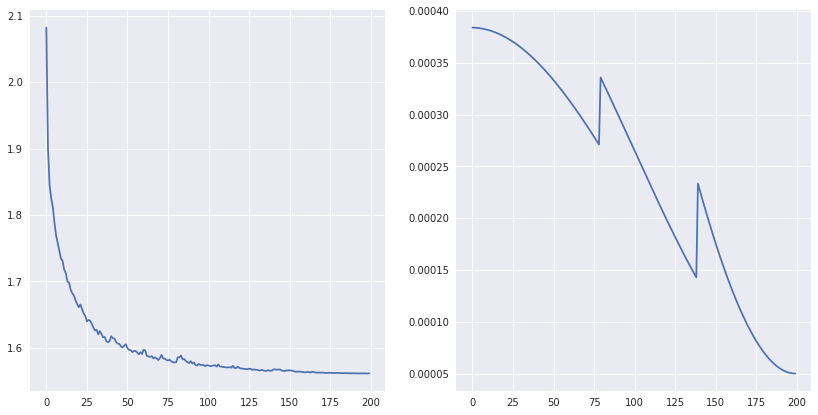

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn')
fig, ax = plt.subplots(1,2, figsize = (14,7))
sns.lineplot(ax= ax[0], x= range(len(loss_list)), y= loss_list)
sns.lineplot(ax= ax[1], x= range(len(lrs)), y= lrs)

/tmp/ipykernel_9122/520142351.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


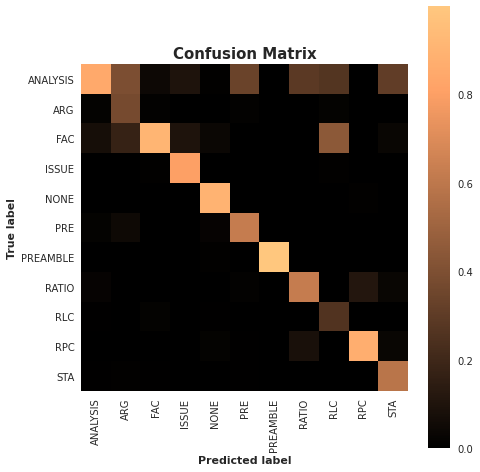

In [43]:
plot_confusion_matrix(np.divide(cm, np.sum(cm,axis=0)), label_encoder= label_encoder)

In [45]:
from utils import save_model

save_model(trained_model, '../models/BiLSTM.pth')

Model parameters saved to '../models/BiLSTM.pth'
